## Integration of larval datasets from Raj 2020 with adult using Seurat CCA

In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(RColorBrewer)

Attaching SeuratObject

Attaching sp


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Save/reload data

In [14]:
saveRDS(prog.combined, 
        file = "/local/Nina/jupyterlab/larvae_adult_int/int_prog_2dpf-ad_3000vf.rds")

In [2]:
prog.combined <- readRDS(file = "/local/Nina/jupyterlab/larvae_adult_int/int_prog_2dpf-ad_3000vf.rds")

In [3]:
dim(prog.combined)

[1]  3000 36448

#### UMAP for Fig3

In [16]:
# add metadata column with clearer names (no underscores, correct order etc)
stage_vector <- prog.combined$stage

In [17]:
head(stage_vector)

s13-2d_AAATGCCCAAAGTCAA s13-2d_AACTCAGCATTCTCAT s13-2d_AACTTTCCAAAGAATC 
          "larvae_2dpf"           "larvae_2dpf"           "larvae_2dpf" 
s13-2d_ACACCAATCTCCTATA s13-2d_ACAGCCGTCTGCTGCT s13-2d_ACATGGTCACAGGTTT 
          "larvae_2dpf"           "larvae_2dpf"           "larvae_2dpf"

In [18]:
table(stage_vector)

stage_vector
       adult larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
       15829         9782         1619         2049         2988         4181 

In [19]:
stage_vector_tidy <- plyr::mapvalues(stage_vector,
                                    from = c("adult", "larvae_15dpf", "larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf"),
                                    to = c("adult", "larvae 15 dpf", "larvae 2 dpf", "larvae 3 dpf", "larvae 5 dpf", "larvae 8 dpf"))

In [20]:
table(stage_vector_tidy)

stage_vector_tidy
        adult larvae 15 dpf  larvae 2 dpf  larvae 3 dpf  larvae 5 dpf 
        15829          9782          1619          2049          2988 
 larvae 8 dpf 
         4181 

In [21]:
prog.combined$stage_tidy <- stage_vector_tidy

In [22]:
Idents(prog.combined) <- "stage_tidy"

In [23]:
levels(prog.combined)

[1] "larvae 2 dpf"  "larvae 3 dpf"  "larvae 5 dpf"  "larvae 8 dpf" 
[5] "larvae 15 dpf" "adult"

In [24]:
# use Set2 as palette for stage
stage_colors_tidy <-  c("larvae 2 dpf" = "#8da0cb",
                  "larvae 3 dpf" = "#e78ac3",
                  "larvae 5 dpf" = "#a6d854", 
                  "larvae 8 dpf" = "#ffd92f",
                  "larvae 15 dpf" = "#fc8d62",
                   "adult" = "#66c2a5")

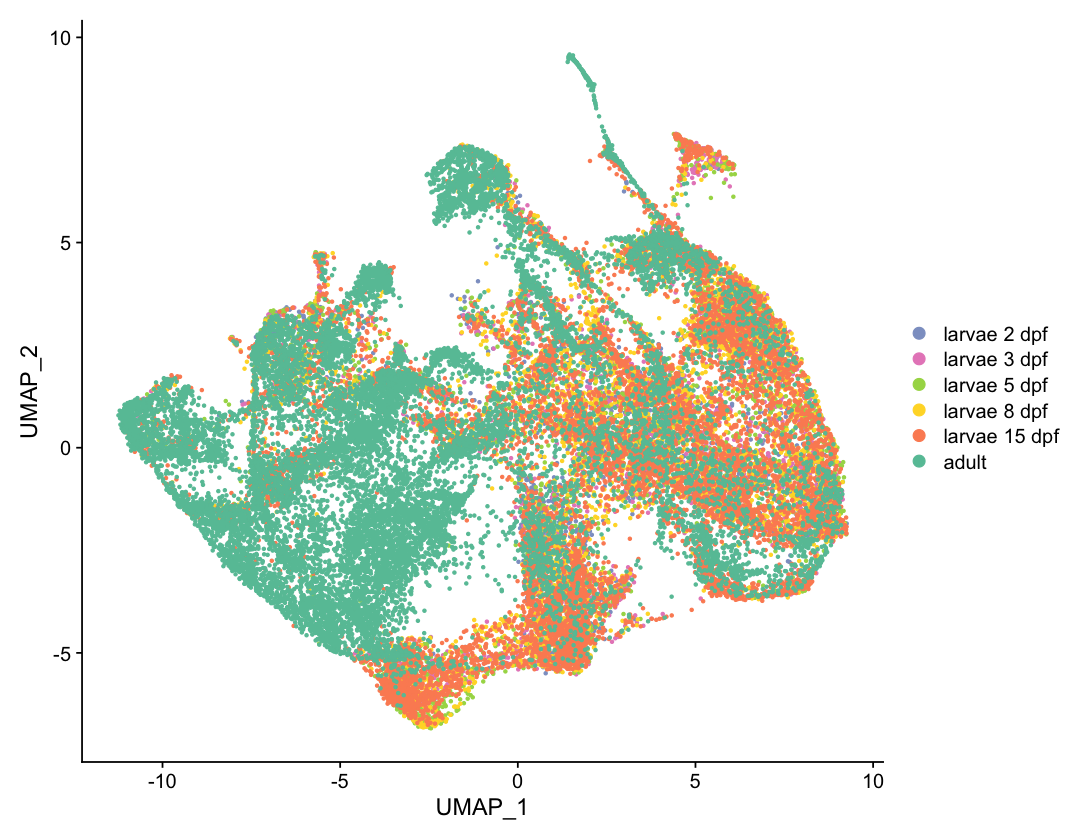

In [27]:
options(repr.plot.width=9, repr.plot.height=7)

int_umap <- DimPlot(prog.combined, reduction = "umap", label = FALSE, 
                    cols = stage_colors_tidy, pt.size = 0.6)
int_umap

In [28]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/umap_int_stages.pdf", 
    plot = int_umap, 
   units = "in", height = 6, width = 7)

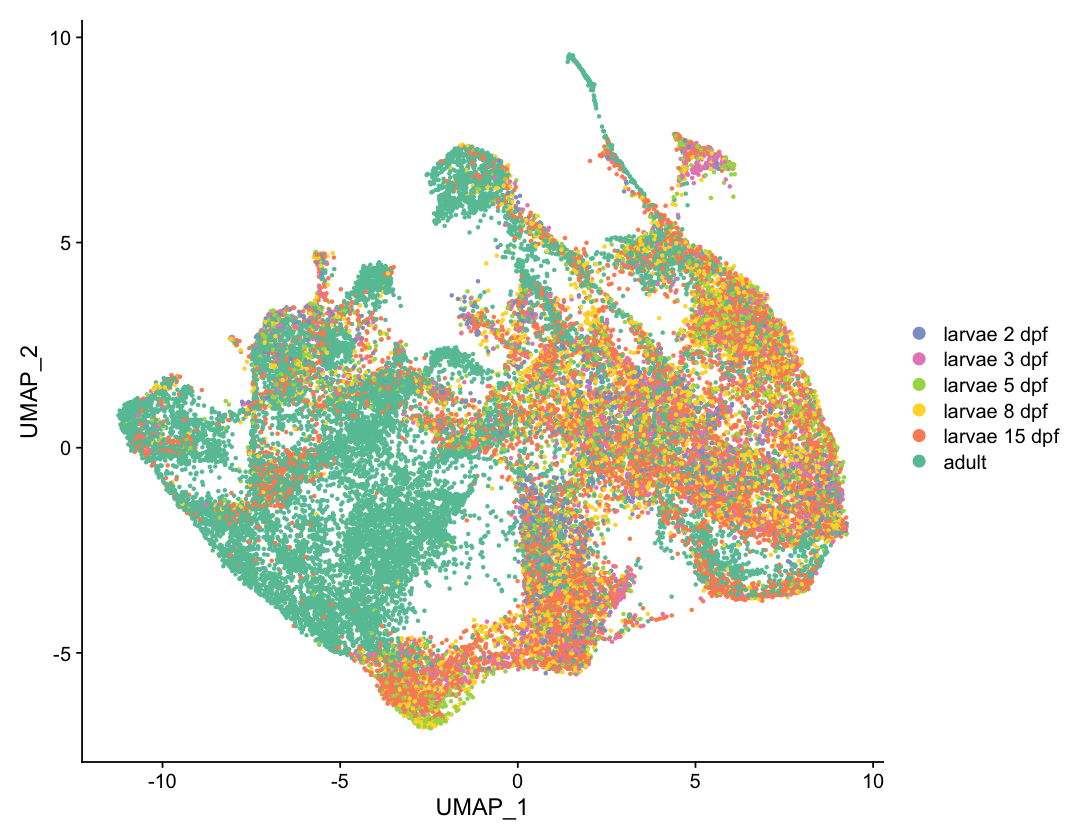

In [29]:
options(repr.plot.width=9, repr.plot.height=7)

int_umap <- DimPlot(prog.combined, reduction = "umap", label = FALSE, 
                    cols = stage_colors_tidy, pt.size = 0.6, shuffle = TRUE)
int_umap

In [30]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/umap_int_stages_shuff.pdf", 
    plot = int_umap, 
   units = "in", height = 6, width = 7)

### Quantify larval cell types that co-cluster with adult


Use adult cell types as reference to ask which larval cluster co-cluster with each specific adult cell type (especially those that are interesting in the narrative of the manuscript). Seurat clusters as the unit of co-clustering??

In [15]:
table(prog.combined$pc28_res0.8_named_detailed)


      Neuroepithelial cells   Proliferating cells mcm6+ 
                        234                         659 
 Proliferating cells mki67+     Radial glia apof+ (mes) 
                       1248                        1690 
Radial glia crabp1b+ (rhom)          Radial glia enkur+ 
                        407                         637 
   Radial glia foxn4+ (mes)          Radial glia gfap++ 
                        500                         630 
          Radial glia id2b+     Radial glia id3+ (dien) 
                       2648                         745 
          Radial glia nppc+    Radial glia nrg1+ (rhom) 
                       1155                         384 
  Radial glia ntn1b+ (dien)  Radial glia prss35+ (rhom) 
                        386                         880 
  Radial glia RP high(rhom)        Radial glia snap25a+ 
                        232                        3180 
         Radial glia stat2+    Radial glia stra6+ (mes) 
                        139   

Version 1: without normalization

In [694]:
celltype_ad.by.cluster <- table(prog.combined$pc28_res0.8_named_detailed, prog.combined$seurat_clusters)

In [695]:
celltype_ad.by.cluster[1:5,1:5]

                             
                                0   1   2   3   4
  Neuroepithelial cells         0   6   0   1   0
  Proliferating cells mcm6+     8  47  11  34   2
  Proliferating cells mki67+   12  34 241 144   4
  Radial glia apof+ (mes)       5  31   0   1  11
  Radial glia crabp1b+ (rhom)   0  38   0   1   0

In [696]:
celltype_lar.by.cluster <- table(prog.combined$celltype_assigned, prog.combined$seurat_clusters)

In [697]:
celltype_lar.by.cluster[1:5,1:5]

                        
                            0    1    2    3    4
  glia progenitors          0    0    0    0    0
  glial progenitors        21    2   23   19    4
  progenitors             282   20 1356 1248   35
  progenitors (cycling)    19    0   32  483    0
  progenitors (midbrain)   37    0  139   40    2

Version 2: row-normalize both tables (rerun code chunks below after this)

In [698]:
celltype_ad.by.cluster <- round(prop.table(celltype_ad.by.cluster, margin = 1), digits = 10) * 100

In [699]:
celltype_ad.by.cluster[1:5,1:5]

                             
                                       0          1          2          3
  Neuroepithelial cells        0.0000000  2.5641026  0.0000000  0.4273504
  Proliferating cells mcm6+    1.2139605  7.1320182  1.6691958  5.1593323
  Proliferating cells mki67+   0.9615385  2.7243590 19.3108974 11.5384615
  Radial glia apof+ (mes)      0.2958580  1.8343195  0.0000000  0.0591716
  Radial glia crabp1b+ (rhom)  0.0000000  9.3366093  0.0000000  0.2457003
                             
                                       4
  Neuroepithelial cells        0.0000000
  Proliferating cells mcm6+    0.3034901
  Proliferating cells mki67+   0.3205128
  Radial glia apof+ (mes)      0.6508876
  Radial glia crabp1b+ (rhom)  0.0000000

In [700]:
celltype_lar.by.cluster <- round(prop.table(celltype_lar.by.cluster, margin = 1), digits = 10) * 1000

In [701]:
celltype_lar.by.cluster[1:5,1:5]

                        
                                  0          1          2          3          4
  glia progenitors         0.000000   0.000000   0.000000   0.000000   0.000000
  glial progenitors       27.631579   2.631579  30.263158  25.000000   5.263158
  progenitors             34.020992   2.412836 163.590300 150.560984   4.222463
  progenitors (cycling)   11.216057   0.000000  18.890201 285.123967   0.000000
  progenitors (midbrain)  54.172767   0.000000 203.513909  58.565154   2.928258

#### Manually pick for snap25a+ - test case

In [18]:
celltype_ad.by.cluster[c("Radial glia snap25a+"),]

0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
 15 777   1  35  60 123 133   0   1   5  33 317  18  11   5 275 411  17   0  31 
 20  21  22  23  24  25  26  27  28  29  30 
785  53   5   1  14   1  13  17  22   1   0

In [19]:
rownames(celltype_ad.by.cluster)

[1] "Neuroepithelial cells"       "Proliferating cells mcm6+"  
 [3] "Proliferating cells mki67+"  "Radial glia apof+ (mes)"    
 [5] "Radial glia crabp1b+ (rhom)" "Radial glia enkur+"         
 [7] "Radial glia foxn4+ (mes)"    "Radial glia gfap++"         
 [9] "Radial glia id2b+"           "Radial glia id3+ (dien)"    
[11] "Radial glia nppc+"           "Radial glia nrg1+ (rhom)"   
[13] "Radial glia ntn1b+ (dien)"   "Radial glia prss35+ (rhom)" 
[15] "Radial glia RP high(rhom)"   "Radial glia snap25a+"       
[17] "Radial glia stat2+"          "Radial glia stra6+ (mes)"

In [20]:
nrow(celltype_ad.by.cluster)

[1] 18

In [29]:
sort(celltype_ad.by.cluster[c("Radial glia snap25a+"),])

7  18  30   2   8  23  25  29   9  14  22  13  26  24   0  17  27  12  28  19 
  0   0   0   1   1   1   1   1   5   5   5  11  13  14  15  17  17  18  22  31 
 10   3  21   4   5   6  15  11  16   1  20 
 33  35  53  60 123 133 275 317 411 777 785

In [32]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia snap25a+"),]))
cumsum_vector

7   18   30    2    8   23   25   29    9   14   22   13   26   24    0   17 
   0    0    0    1    2    3    4    5   10   15   20   31   44   58   73   90 
  27   12   28   19   10    3   21    4    5    6   15   11   16    1   20 
 107  125  147  178  211  246  299  359  482  615  890 1207 1618 2395 3180

In [34]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia snap25a+"),])
cutoff_0.1

[1] 318

In [35]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
clusters_snap25 <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
clusters_snap25

[1] "4"  "5"  "6"  "15" "11" "16" "1"  "20"

In [41]:
sub_snap25 <- celltype_lar.by.cluster[, clusters_snap25]

In [42]:
sub_snap25

                                                       
                                                          4   5   6  15  11  16
  glia progenitors                                        0   0   0   0   0   0
  glial progenitors                                       4  37   1   4   1   0
  progenitors                                            35 565   8 567  26   2
  progenitors (cycling)                                   0  56   0  15   0   0
  progenitors (midbrain)                                  2  12   0   4   0   0
  progenitors (ventral)                                 110  29   3   1  14   0
  progenitors/differentiating                             0 245   0   5   0   0
  progenitors/differentiating granule cells (hindbrain)   0 325   0   0   0   0
  progenitors/neurons (differentiating)                   0 119   0   1   0   0
  radial glia                                           417 128 269  52 410 126
  URL progenitors                                         0  65 

In [45]:
sum_snap25 <- rowSums(sub_snap25)

In [46]:
sum_snap25

glia progenitors 
                                                    0 
                                    glial progenitors 
                                                   50 
                                          progenitors 
                                                 1228 
                                progenitors (cycling) 
                                                   71 
                               progenitors (midbrain) 
                                                   18 
                                progenitors (ventral) 
                                                  173 
                         progenitors/differentiating  
                                                  252 
progenitors/differentiating granule cells (hindbrain) 
                                                  327 
                progenitors/neurons (differentiating) 
                                                  121 
                                          radial glia 
                                                 1442 
                                      URL progenitors 
                                                   92

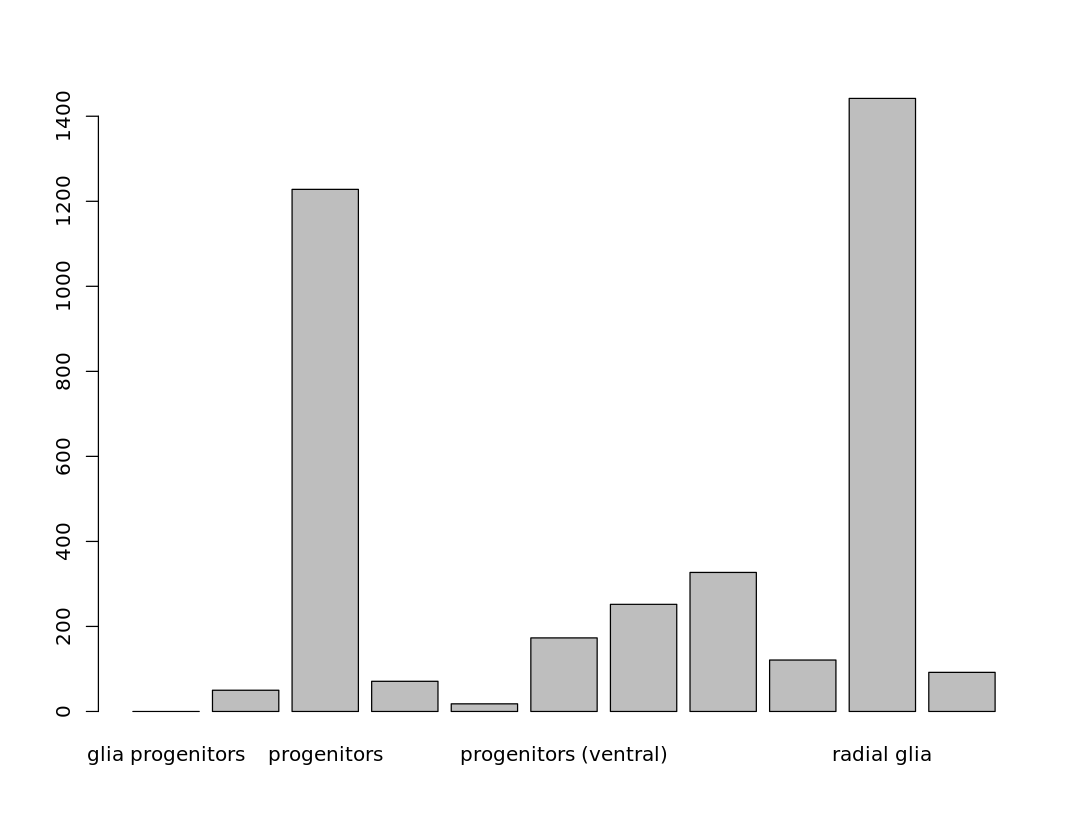

In [47]:
barplot(sum_snap25)

In [51]:
df_snap25 <- data.frame("Celltype_larval" = names(sum_snap25),
                       "Nr_cells" = sum_snap25,
                       "Celltype_adult" = "Radial glia snap25a+")
head(df_snap25)

Celltype_larval        Nr_cells Celltype_adult      
glia progenitors       glia progenitors          0     Radial glia snap25a+
glial progenitors      glial progenitors        50     Radial glia snap25a+
progenitors            progenitors            1228     Radial glia snap25a+
progenitors (cycling)  progenitors (cycling)    71     Radial glia snap25a+
progenitors (midbrain) progenitors (midbrain)   18     Radial glia snap25a+
progenitors (ventral)  progenitors (ventral)   173     Radial glia snap25a+

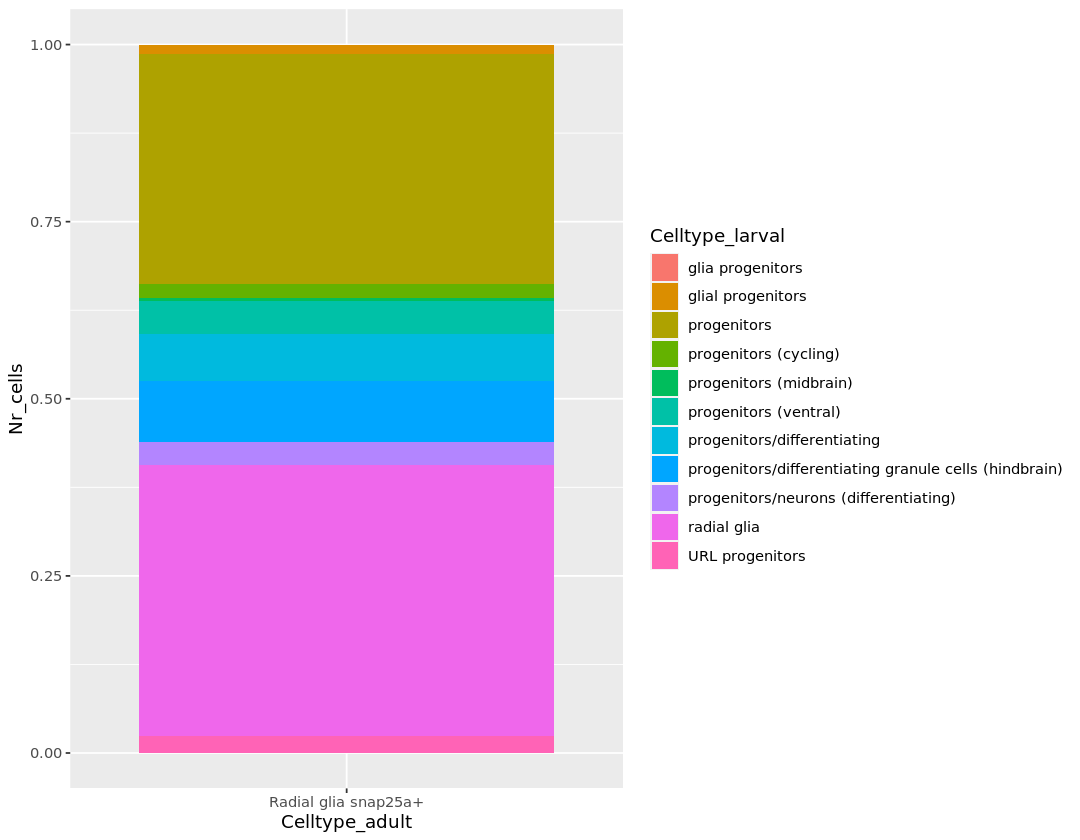

In [56]:
ggplot(data = df_snap25, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") 

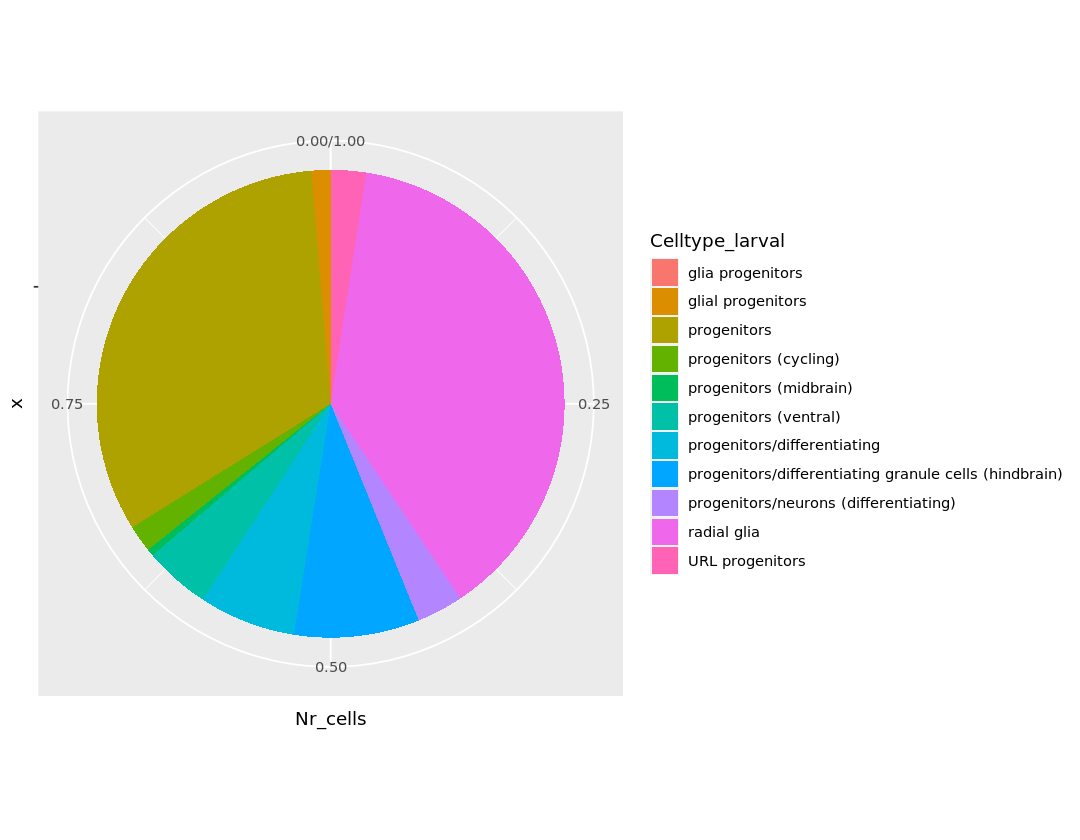

In [54]:
ggplot(data = df_snap25, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    coord_polar("y", start=0)

#### Add calculation for all RG types

In [15]:
table(prog.combined$pc28_res0.8_named_detailed)


      Neuroepithelial cells   Proliferating cells mcm6+ 
                        234                         659 
 Proliferating cells mki67+     Radial glia apof+ (mes) 
                       1248                        1690 
Radial glia crabp1b+ (rhom)          Radial glia enkur+ 
                        407                         637 
   Radial glia foxn4+ (mes)          Radial glia gfap++ 
                        500                         630 
          Radial glia id2b+     Radial glia id3+ (dien) 
                       2648                         745 
          Radial glia nppc+    Radial glia nrg1+ (rhom) 
                       1155                         384 
  Radial glia ntn1b+ (dien)  Radial glia prss35+ (rhom) 
                        386                         880 
  Radial glia RP high(rhom)        Radial glia snap25a+ 
                        232                        3180 
         Radial glia stat2+    Radial glia stra6+ (mes) 
                        139   

##### Neuroepithelial cells

In [702]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Neuroepithelial cells"),]))
cumsum_vector

0           2           4           7           9          10 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         11          12          13          16          17          18 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         19          22          23          25          26          29 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         30           3           5           6           8          20 
  0.0000000   0.4273504   0.8547009   1.2820513   1.7094017   2.1367521 
         27          15          21          28           1          14 
  2.5641026   3.4188034   4.2735043   5.9829060   8.5470085  11.5384615 
         24 
100.0000000

In [703]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Neuroepithelial cells"),])
cutoff_0.1

[1] 10

In [704]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "14" "24"

In [705]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [706]:
sub_table

                                                       
                                                                14         24
  glia progenitors                                      359.375000 625.000000
  glial progenitors                                     202.631579  27.631579
  progenitors                                            45.843889   2.774762
  progenitors (cycling)                                   2.361275  47.815821
  progenitors (midbrain)                                 21.961933   0.000000
  progenitors (ventral)                                  82.991803   0.000000
  progenitors/differentiating                             3.929273   0.000000
  progenitors/differentiating granule cells (hindbrain)   0.000000   0.000000
  progenitors/neurons (differentiating)                   3.121099   0.000000
  radial glia                                             8.097166   0.000000
  URL progenitors                                        36.379769   0.000000

In [707]:
sub_rowsum <- rowSums(sub_table)

In [708]:
sub_rowsum

glia progenitors 
                                           984.375000 
                                    glial progenitors 
                                           230.263158 
                                          progenitors 
                                            48.618651 
                                progenitors (cycling) 
                                            50.177096 
                               progenitors (midbrain) 
                                            21.961933 
                                progenitors (ventral) 
                                            82.991803 
                         progenitors/differentiating  
                                             3.929273 
progenitors/differentiating granule cells (hindbrain) 
                                             0.000000 
                progenitors/neurons (differentiating) 
                                             3.121099 
                                          radial glia 
                                             8.097166 
                                      URL progenitors 
                                            36.379769

In [709]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Neuroepithelial cells")
head(sub_df)

Celltype_larval        Nr_cells  Celltype_adult       
glia progenitors       glia progenitors       984.37500 Neuroepithelial cells
glial progenitors      glial progenitors      230.26316 Neuroepithelial cells
progenitors            progenitors             48.61865 Neuroepithelial cells
progenitors (cycling)  progenitors (cycling)   50.17710 Neuroepithelial cells
progenitors (midbrain) progenitors (midbrain)  21.96193 Neuroepithelial cells
progenitors (ventral)  progenitors (ventral)   82.99180 Neuroepithelial cells

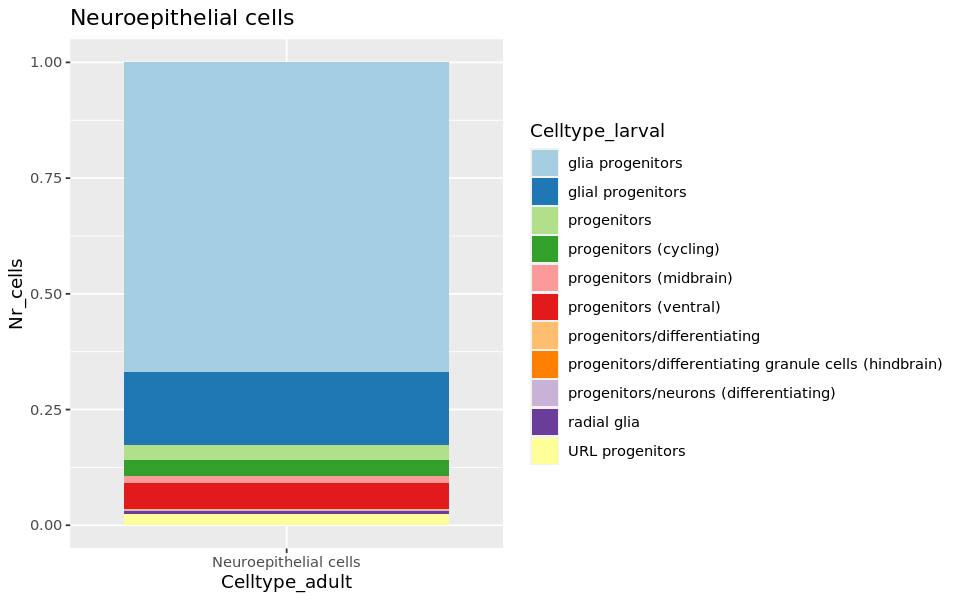

In [710]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Neuroepithelial cells")

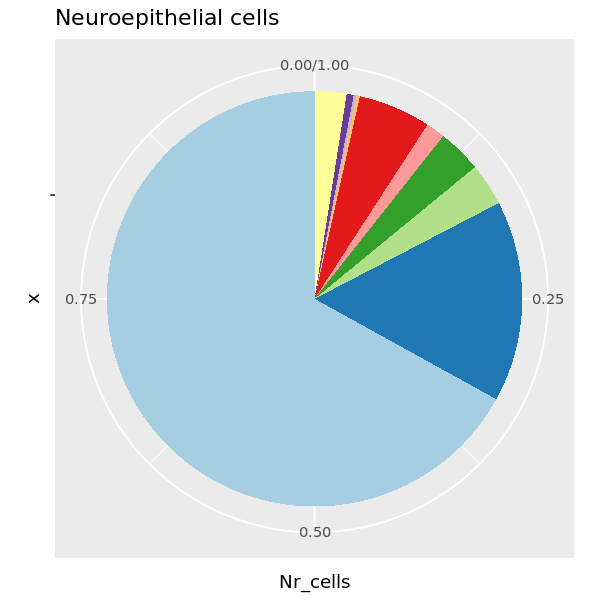

In [711]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Neuroepithelial cells") +
    coord_polar("y", start=0) +
    NoLegend()

##### Proliferating cells mcm6+

In [712]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Proliferating cells mcm6+"),]))
cumsum_vector

6          11          12          16          19          20 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         24          25          28          29          30           7 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.1517451 
         15          23           4          14          17          22 
  0.3034901   0.4552352   0.7587254   1.0622155   1.3657056   1.6691958 
         27          18          21           0           2           5 
  1.9726859   2.4279211   3.1866465   4.4006070   6.0698028   8.0424886 
         10           3           1          26           8          13 
 11.5326252  16.6919575  23.8239757  34.9013657  52.8072838  75.8725342 
          9 
100.0000000

In [713]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Proliferating cells mcm6+"),])
cutoff_0.1

[1] 10

In [714]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "10" "3"  "1"  "26" "8"  "13" "9"

In [715]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [716]:
sub_table

                                                       
                                                                 10           3
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                       7.8947368  25.0000000
  progenitors                                            50.9108457 150.5609844
  progenitors (cycling)                                   0.5903188 285.1239669
  progenitors (midbrain)                                 17.5695461  58.5651537
  progenitors (ventral)                                  80.9426230   4.0983607
  progenitors/differentiating                             5.8939096   7.8585462
  progenitors/differentiating granule cells (hindbrain)   0.0000000   0.0000000
  progenitors/neurons (differentiating)                 190.0749064   4.0574282
  radial glia                                             8.0971660  10.1214575
  URL progenitors                                         0.0000

In [717]:
sub_rowsum <- rowSums(sub_table)

In [718]:
sub_rowsum

glia progenitors 
                                             0.000000 
                                    glial progenitors 
                                           355.263158 
                                          progenitors 
                                           447.701773 
                                progenitors (cycling) 
                                           321.133412 
                               progenitors (midbrain) 
                                           478.770132 
                                progenitors (ventral) 
                                           363.729508 
                         progenitors/differentiating  
                                            19.646365 
progenitors/differentiating granule cells (hindbrain) 
                                             8.595989 
                progenitors/neurons (differentiating) 
                                           259.363296 
                                          radial glia 
                                            76.585695 
                                      URL progenitors 
                                           430.346051

In [719]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Proliferating cells mcm6+")
head(sub_df)

Celltype_larval        Nr_cells
glia progenitors       glia progenitors         0.0000
glial progenitors      glial progenitors      355.2632
progenitors            progenitors            447.7018
progenitors (cycling)  progenitors (cycling)  321.1334
progenitors (midbrain) progenitors (midbrain) 478.7701
progenitors (ventral)  progenitors (ventral)  363.7295
                       Celltype_adult           
glia progenitors       Proliferating cells mcm6+
glial progenitors      Proliferating cells mcm6+
progenitors            Proliferating cells mcm6+
progenitors (cycling)  Proliferating cells mcm6+
progenitors (midbrain) Proliferating cells mcm6+
progenitors (ventral)  Proliferating cells mcm6+

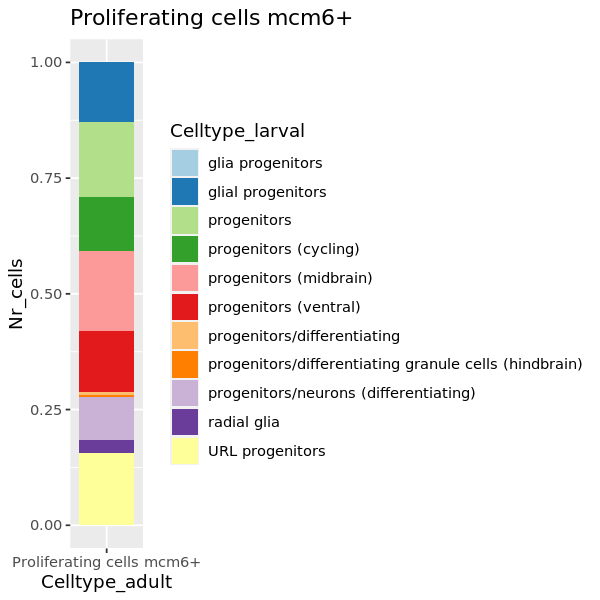

In [720]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Proliferating cells mcm6+")

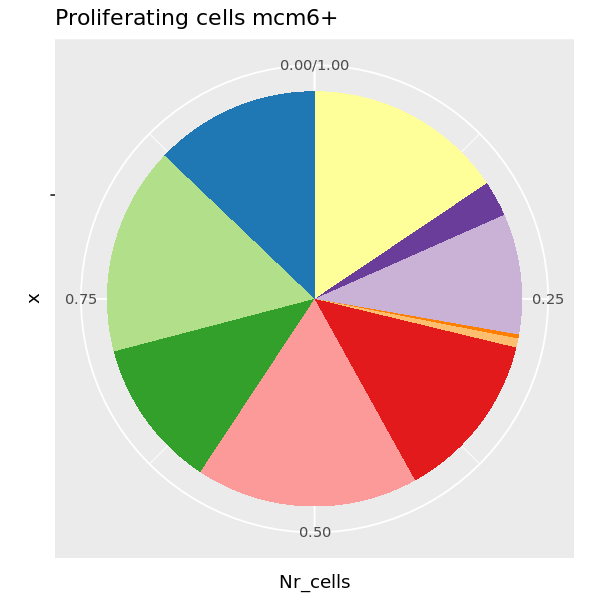

In [721]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Proliferating cells mcm6+") +
    coord_polar("y", start=0) + 
    NoLegend()

##### Proliferating cells mki67+

In [722]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Proliferating cells mki67+"),]))
cumsum_vector

6           12           16           20           23           24 
  0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000 
          25           28           29           30           14           17 
  0.00000000   0.00000000   0.00000000   0.00000000   0.08012821   0.16025642 
          22           11           19           27            4           10 
  0.24038463   0.40064104   0.56089745   0.80128207   1.12179489   1.44230771 
          15           21            9           13            0            8 
  1.76282053   2.08333335   2.64423079   3.20512823   4.16666669   5.92948720 
           5            1            3           26            2            7 
  7.85256412  10.57692309  22.11538463  37.01923078  56.33012822  75.80128207 
          18 
100.00000002

In [723]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Proliferating cells mki67+"),])
cutoff_0.1

[1] 10

In [724]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "1"  "3"  "26" "2"  "7"  "18"

In [725]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [726]:
sub_table

                                                       
                                                                  1           3
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                       2.6315789  25.0000000
  progenitors                                             2.4128363 150.5609844
  progenitors (cycling)                                   0.0000000 285.1239669
  progenitors (midbrain)                                  0.0000000  58.5651537
  progenitors (ventral)                                  16.3934426   4.0983607
  progenitors/differentiating                             1.9646365   7.8585462
  progenitors/differentiating granule cells (hindbrain)   5.7306590   0.0000000
  progenitors/neurons (differentiating)                   0.3121099   4.0574282
  radial glia                                             5.7354926  10.1214575
  URL progenitors                                         0.8873

In [727]:
sub_rowsum <- rowSums(sub_table)

In [728]:
sub_rowsum

glia progenitors 
                                             0.000000 
                                    glial progenitors 
                                           213.157895 
                                          progenitors 
                                           390.155628 
                                progenitors (cycling) 
                                           777.449823 
                               progenitors (midbrain) 
                                           449.487555 
                                progenitors (ventral) 
                                           143.442623 
                         progenitors/differentiating  
                                            11.787819 
progenitors/differentiating granule cells (hindbrain) 
                                             5.730659 
                progenitors/neurons (differentiating) 
                                           119.850187 
                                          radial glia 
                                            45.883941 
                                      URL progenitors 
                                           460.514641

In [729]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Proliferating cells mki67+")
head(sub_df)

Celltype_larval        Nr_cells
glia progenitors       glia progenitors         0.0000
glial progenitors      glial progenitors      213.1579
progenitors            progenitors            390.1556
progenitors (cycling)  progenitors (cycling)  777.4498
progenitors (midbrain) progenitors (midbrain) 449.4876
progenitors (ventral)  progenitors (ventral)  143.4426
                       Celltype_adult            
glia progenitors       Proliferating cells mki67+
glial progenitors      Proliferating cells mki67+
progenitors            Proliferating cells mki67+
progenitors (cycling)  Proliferating cells mki67+
progenitors (midbrain) Proliferating cells mki67+
progenitors (ventral)  Proliferating cells mki67+

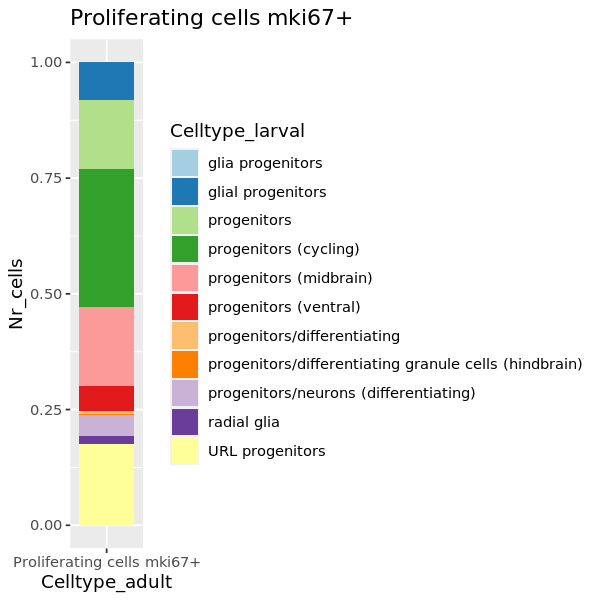

In [730]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Proliferating cells mki67+")

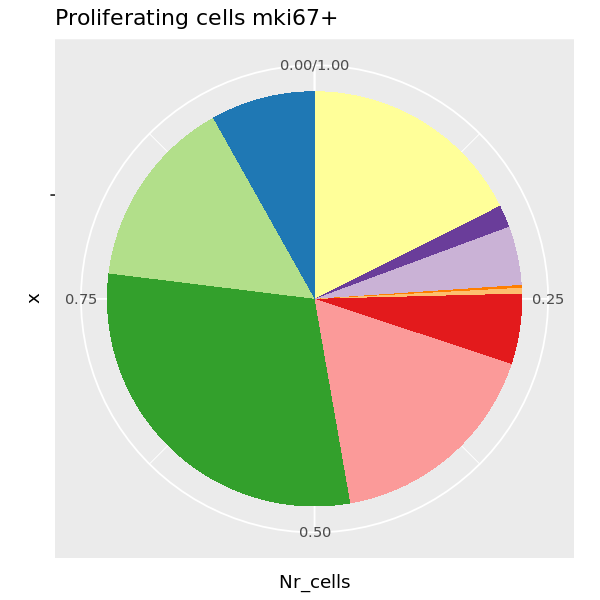

In [731]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Proliferating cells mki67+") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia apof+ (mes)

In [732]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia apof+ (mes)"),]))
cumsum_vector

2           5           7           9          10          13 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         17          18          19          23          24          25 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         26          27          29          30           3          14 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0591716   0.1183432 
         15          21          22           0          28           8 
  0.1775148   0.2366864   0.4142012   0.7100592   1.0059172   1.4201184 
         12           4          20          11           1          16 
  1.8343195   2.4852071   3.6094675   5.0295858   6.8639053  36.3905326 
          6 
100.0000000

In [733]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia apof+ (mes)"),])
cutoff_0.1

[1] 10

In [734]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "16" "6"

In [735]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [736]:
sub_table

                                                       
                                                                16          6
  glia progenitors                                       0.0000000  0.0000000
  glial progenitors                                      0.0000000  1.3157895
  progenitors                                            0.2412836  0.9651345
  progenitors (cycling)                                  0.0000000  0.0000000
  progenitors (midbrain)                                 0.0000000  0.0000000
  progenitors (ventral)                                  0.0000000  3.0737705
  progenitors/differentiating                            0.0000000  0.0000000
  progenitors/differentiating granule cells (hindbrain)  0.0000000  0.0000000
  progenitors/neurons (differentiating)                  0.0000000  0.0000000
  radial glia                                           42.5101215 90.7557355
  URL progenitors                                        0.0000000  0.0000000

In [737]:
sub_rowsum <- rowSums(sub_table)

In [738]:
sub_rowsum

glia progenitors 
                                             0.000000 
                                    glial progenitors 
                                             1.315790 
                                          progenitors 
                                             1.206418 
                                progenitors (cycling) 
                                             0.000000 
                               progenitors (midbrain) 
                                             0.000000 
                                progenitors (ventral) 
                                             3.073771 
                         progenitors/differentiating  
                                             0.000000 
progenitors/differentiating granule cells (hindbrain) 
                                             0.000000 
                progenitors/neurons (differentiating) 
                                             0.000000 
                                          radial glia 
                                           133.265857 
                                      URL progenitors 
                                             0.000000

In [739]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia apof+ (mes)")
head(sub_df)

Celltype_larval        Nr_cells Celltype_adult         
glia progenitors       glia progenitors       0.000000 Radial glia apof+ (mes)
glial progenitors      glial progenitors      1.315790 Radial glia apof+ (mes)
progenitors            progenitors            1.206418 Radial glia apof+ (mes)
progenitors (cycling)  progenitors (cycling)  0.000000 Radial glia apof+ (mes)
progenitors (midbrain) progenitors (midbrain) 0.000000 Radial glia apof+ (mes)
progenitors (ventral)  progenitors (ventral)  3.073771 Radial glia apof+ (mes)

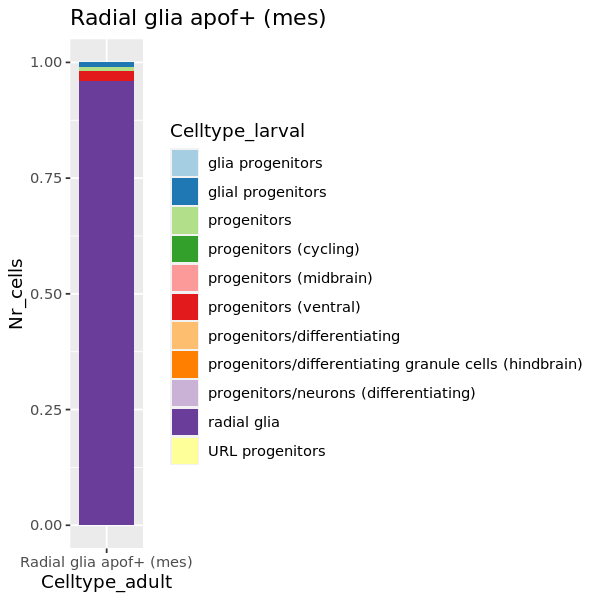

In [740]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia apof+ (mes)")

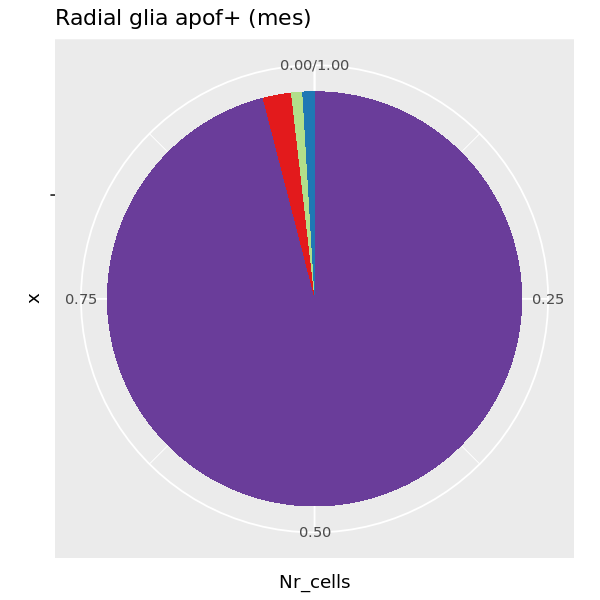

In [741]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia apof+ (mes)") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia crabp1b+ (rhom)

In [742]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia crabp1b+ (rhom)"),]))
cumsum_vector

0           2           4           5           6           7 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
          9          12          16          17          18          20 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         24          27          29          30           3          10 
  0.0000000   0.0000000   0.0000000   0.0000000   0.2457003   0.4914005 
         11          21          25          23          28          14 
  0.7371007   0.9828010   1.2285013   1.9656020   2.7027027   3.9312040 
         22          26           8          19          15           1 
  5.1597052   6.6339067   8.5995086  12.5307126  16.7076167  26.0442261 
         13 
100.0000000

In [743]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia crabp1b+ (rhom)"),])
cutoff_0.1

[1] 10

In [744]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "19" "15" "1"  "13"

In [745]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [746]:
sub_table

                                                       
                                                                 19          15
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                      82.8947368   5.2631579
  progenitors                                             0.1206418  68.4039088
  progenitors (cycling)                                   0.0000000   8.8547816
  progenitors (midbrain)                                  0.0000000   5.8565154
  progenitors (ventral)                                   0.0000000   1.0245902
  progenitors/differentiating                             0.0000000   9.8231827
  progenitors/differentiating granule cells (hindbrain)   0.0000000   0.0000000
  progenitors/neurons (differentiating)                   0.0000000   0.3121099
  radial glia                                             3.7112011  17.5438596
  URL progenitors                                        57.6752

In [747]:
sub_rowsum <- rowSums(sub_table)

In [748]:
sub_rowsum

glia progenitors 
                                             0.000000 
                                    glial progenitors 
                                           298.684210 
                                          progenitors 
                                            87.344674 
                                progenitors (cycling) 
                                            12.987013 
                               progenitors (midbrain) 
                                            14.641289 
                                progenitors (ventral) 
                                            18.442623 
                         progenitors/differentiating  
                                            11.787819 
progenitors/differentiating granule cells (hindbrain) 
                                             8.595989 
                progenitors/neurons (differentiating) 
                                             3.433209 
                                          radial glia 
                                            32.726046 
                                      URL progenitors 
                                           373.558119

In [749]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia crabp1b+ (rhom)")
head(sub_df)

Celltype_larval        Nr_cells 
glia progenitors       glia progenitors         0.00000
glial progenitors      glial progenitors      298.68421
progenitors            progenitors             87.34467
progenitors (cycling)  progenitors (cycling)   12.98701
progenitors (midbrain) progenitors (midbrain)  14.64129
progenitors (ventral)  progenitors (ventral)   18.44262
                       Celltype_adult             
glia progenitors       Radial glia crabp1b+ (rhom)
glial progenitors      Radial glia crabp1b+ (rhom)
progenitors            Radial glia crabp1b+ (rhom)
progenitors (cycling)  Radial glia crabp1b+ (rhom)
progenitors (midbrain) Radial glia crabp1b+ (rhom)
progenitors (ventral)  Radial glia crabp1b+ (rhom)

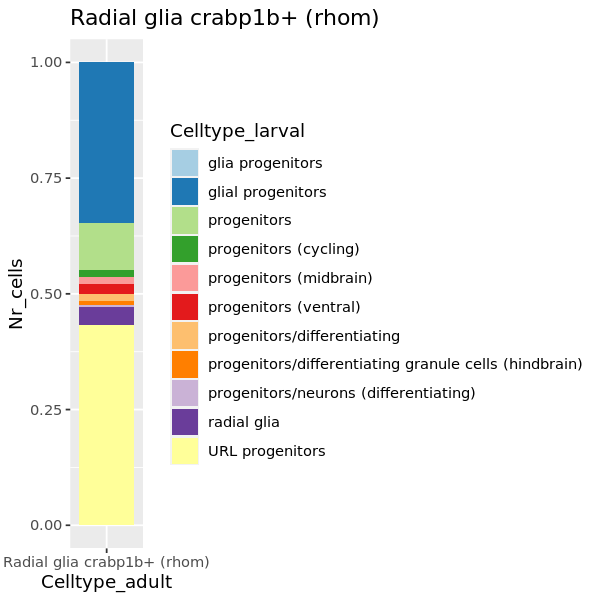

In [750]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia crabp1b+ (rhom)")

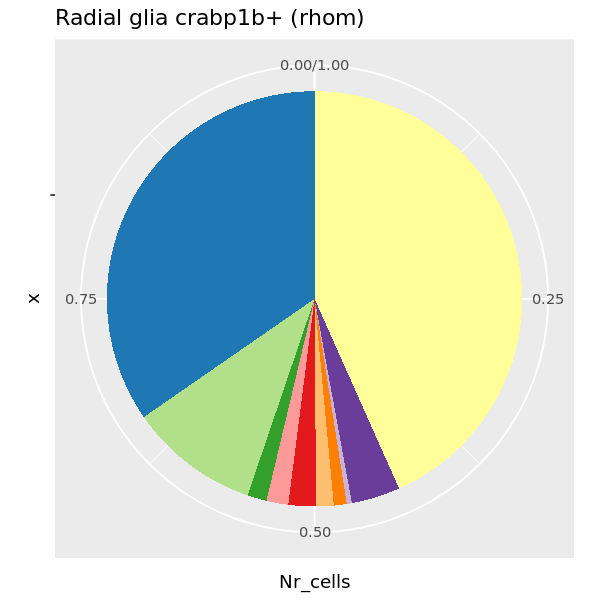

In [751]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia crabp1b+ (rhom)") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia enkur+

In [752]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia enkur+"),]))
cumsum_vector

2           3           7           8           9          18 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         19          21          25          26          30           0 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.1569859 
         14          22          10          16          24          27 
  0.3139717   0.4709576   0.7849293   1.0989011   1.4128728   1.7268446 
          6          13           5          17          29          20 
  2.1978022   2.6687598   3.4536891   4.3956044   5.3375196   6.4364207 
         12           4          11          28          15           1 
  7.8492936   9.4191523  11.4599686  14.2857143  19.1522763  38.4615384 
         23 
100.0000000

In [753]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia enkur+"),])
cutoff_0.1

[1] 10

In [754]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "11" "28" "15" "1"  "23"

In [755]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [756]:
sub_table

                                                       
                                                                 11          28
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                       1.3157895   0.0000000
  progenitors                                             3.1366872   0.1206418
  progenitors (cycling)                                   0.0000000   0.0000000
  progenitors (midbrain)                                  0.0000000   0.0000000
  progenitors (ventral)                                  14.3442623   0.0000000
  progenitors/differentiating                             0.0000000   0.0000000
  progenitors/differentiating granule cells (hindbrain)   0.0000000   0.0000000
  progenitors/neurons (differentiating)                   0.0000000   0.0000000
  radial glia                                           138.3265857   0.0000000
  URL progenitors                                         0.8873

In [757]:
sub_rowsum <- rowSums(sub_table)

In [758]:
sub_rowsum

glia progenitors 
                                           15.6250000 
                                    glial progenitors 
                                           10.5263158 
                                          progenitors 
                                           74.5566414 
                                progenitors (cycling) 
                                            8.8547816 
                               progenitors (midbrain) 
                                            5.8565154 
                                progenitors (ventral) 
                                           43.0327869 
                         progenitors/differentiating  
                                           11.7878192 
progenitors/differentiating granule cells (hindbrain) 
                                            5.7306590 
                progenitors/neurons (differentiating) 
                                            0.6242198 
                                          radial glia 
                                          189.6086370 
                                      URL progenitors 
                                           27.5066548

In [759]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia enkur+")
head(sub_df)

Celltype_larval        Nr_cells  Celltype_adult    
glia progenitors       glia progenitors       15.625000 Radial glia enkur+
glial progenitors      glial progenitors      10.526316 Radial glia enkur+
progenitors            progenitors            74.556641 Radial glia enkur+
progenitors (cycling)  progenitors (cycling)   8.854782 Radial glia enkur+
progenitors (midbrain) progenitors (midbrain)  5.856515 Radial glia enkur+
progenitors (ventral)  progenitors (ventral)  43.032787 Radial glia enkur+

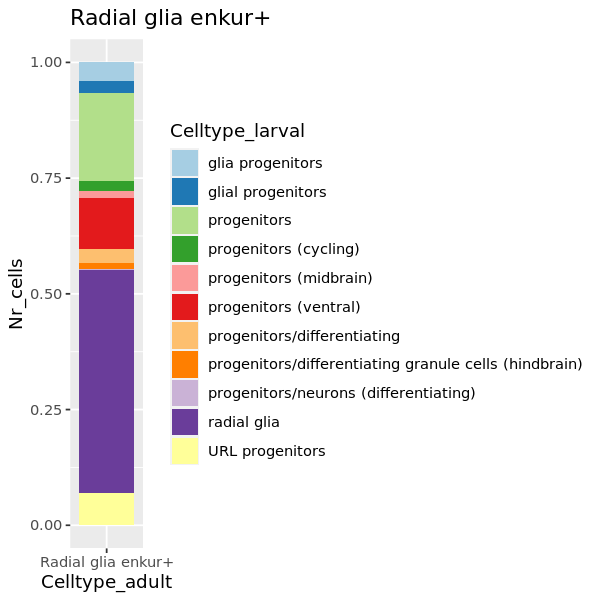

In [760]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia enkur+")

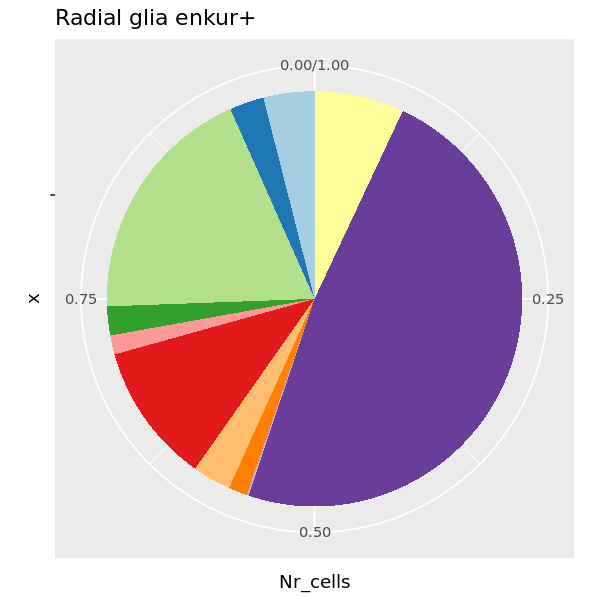

In [761]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia enkur+") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia foxn4+ (mes)

In [762]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia foxn4+ (mes)"),]))
cumsum_vector

3     7    16    21    25    27    29    30     4    17    23    26    12 
  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.2   0.4   0.6   0.8   1.2 
   18    19    20    24    10    13     2     5    11    15    22     6     0 
  1.6   2.0   2.4   2.8   3.4   4.0   4.8   5.6   6.4   7.2   8.0   9.2  10.8 
    9    28     1     8    14 
 12.4  15.0  21.8  30.2 100.0

In [763]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia foxn4+ (mes)"),])
cutoff_0.1

[1] 10

In [764]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "0"  "9"  "28" "1"  "8"  "14"

In [765]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [766]:
sub_table

                                                       
                                                                  0           9
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                      27.6315789  68.4210526
  progenitors                                            34.0209917  98.8056460
  progenitors (cycling)                                  11.2160567   2.9515939
  progenitors (midbrain)                                 54.1727672  83.4553441
  progenitors (ventral)                                  10.2459016 251.0245902
  progenitors/differentiating                           310.4125737   1.9646365
  progenitors/differentiating granule cells (hindbrain)  54.4412607   0.0000000
  progenitors/neurons (differentiating)                 534.3320849  34.0199750
  radial glia                                             2.3616734  33.7381916
  URL progenitors                                        19.5208

In [767]:
sub_rowsum <- rowSums(sub_table)

In [768]:
sub_rowsum

glia progenitors 
                                            359.37500 
                                    glial progenitors 
                                            343.42105 
                                          progenitors 
                                            307.99855 
                                progenitors (cycling) 
                                             44.27391 
                               progenitors (midbrain) 
                                            469.98536 
                                progenitors (ventral) 
                                            370.90164 
                         progenitors/differentiating  
                                            320.23576 
progenitors/differentiating granule cells (hindbrain) 
                                             60.17192 
                progenitors/neurons (differentiating) 
                                            598.93883 
                                          radial glia 
                                             63.09042 
                                      URL progenitors 
                                             74.53416

In [769]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia foxn4+ (mes)")
head(sub_df)

Celltype_larval        Nr_cells 
glia progenitors       glia progenitors       359.37500
glial progenitors      glial progenitors      343.42105
progenitors            progenitors            307.99855
progenitors (cycling)  progenitors (cycling)   44.27391
progenitors (midbrain) progenitors (midbrain) 469.98536
progenitors (ventral)  progenitors (ventral)  370.90164
                       Celltype_adult          
glia progenitors       Radial glia foxn4+ (mes)
glial progenitors      Radial glia foxn4+ (mes)
progenitors            Radial glia foxn4+ (mes)
progenitors (cycling)  Radial glia foxn4+ (mes)
progenitors (midbrain) Radial glia foxn4+ (mes)
progenitors (ventral)  Radial glia foxn4+ (mes)

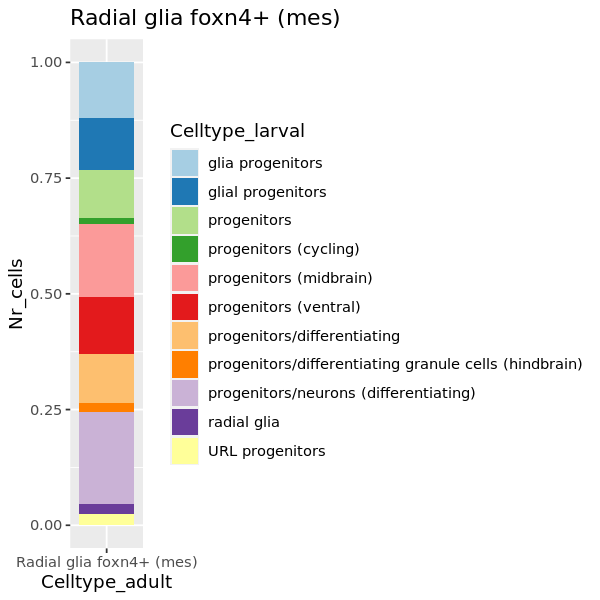

In [770]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia foxn4+ (mes)")

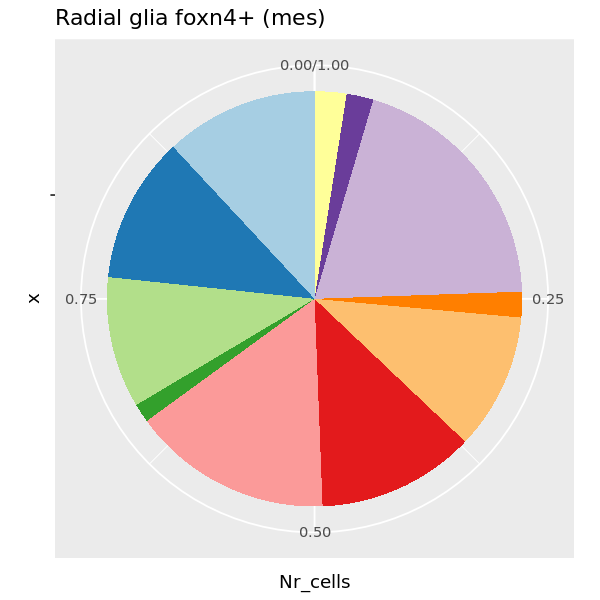

In [771]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia foxn4+ (mes)") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia gfap++

In [772]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia gfap++"),]))
cumsum_vector

7          11          12          16          18          19 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         20          23          24          25          28          29 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         30           3          15          22          26           6 
  0.0000000   0.1587302   0.3174603   0.4761905   0.6349206   0.9523810 
         21          13           5          17           8          27 
  1.2698413   1.7460318   2.3809524   3.0158730   3.8095238   4.6031746 
          2          14           9           4           1           0 
  5.5555556   6.5079365  10.4761905  16.1904762  31.9047619  49.2063492 
         10 
100.0000000

In [773]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia gfap++"),])
cutoff_0.1

[1] 10

In [774]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "9"  "4"  "1"  "0"  "10"

In [775]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [776]:
sub_table

                                                       
                                                                  9           4
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                      68.4210526   5.2631579
  progenitors                                            98.8056460   4.2224635
  progenitors (cycling)                                   2.9515939   0.0000000
  progenitors (midbrain)                                 83.4553441   2.9282577
  progenitors (ventral)                                 251.0245902 112.7049180
  progenitors/differentiating                             1.9646365   0.0000000
  progenitors/differentiating granule cells (hindbrain)   0.0000000   0.0000000
  progenitors/neurons (differentiating)                  34.0199750   0.0000000
  radial glia                                            33.7381916 140.6882591
  URL progenitors                                         6.2111

In [777]:
sub_rowsum <- rowSums(sub_table)

In [778]:
sub_rowsum

glia progenitors 
                                              0.00000 
                                    glial progenitors 
                                            111.84211 
                                          progenitors 
                                            190.37278 
                                progenitors (cycling) 
                                             14.75797 
                               progenitors (midbrain) 
                                            158.12592 
                                progenitors (ventral) 
                                            471.31148 
                         progenitors/differentiating  
                                            320.23576 
progenitors/differentiating granule cells (hindbrain) 
                                             60.17192 
                progenitors/neurons (differentiating) 
                                            758.73908 
                                          radial glia 
                                            190.62078 
                                      URL progenitors 
                                             26.61934

In [779]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia gfap++")
head(sub_df)

Celltype_larval        Nr_cells  Celltype_adult    
glia progenitors       glia progenitors         0.00000 Radial glia gfap++
glial progenitors      glial progenitors      111.84211 Radial glia gfap++
progenitors            progenitors            190.37278 Radial glia gfap++
progenitors (cycling)  progenitors (cycling)   14.75797 Radial glia gfap++
progenitors (midbrain) progenitors (midbrain) 158.12592 Radial glia gfap++
progenitors (ventral)  progenitors (ventral)  471.31148 Radial glia gfap++

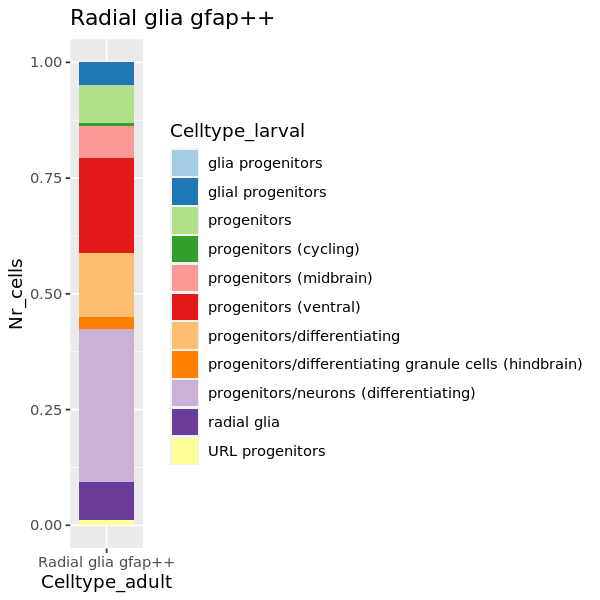

In [780]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia gfap++")

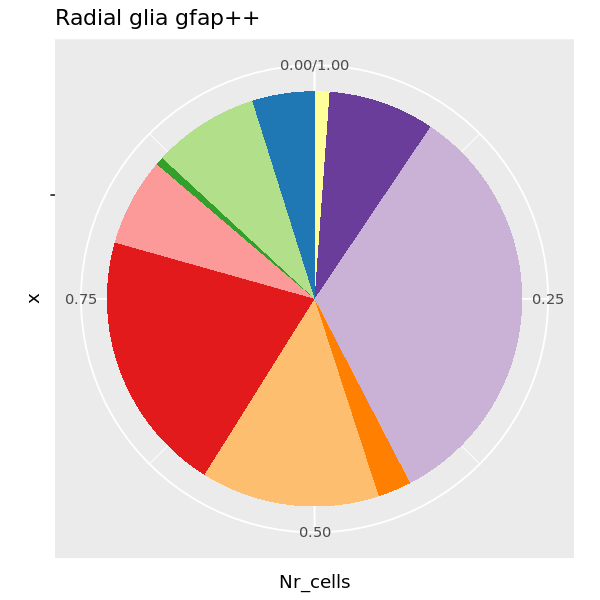

In [781]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia gfap++") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia id2b+

In [782]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia id2b+"),]))
cumsum_vector

0           2           3           7          18          21 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         30          25          26          29           5           8 
  0.0000000   0.0755287   0.1510574   0.2265861   0.3398792   0.4531722 
         23          16          13          15          24          19 
  0.6419940   0.9063444   1.2839879   1.6616314   2.1903323   2.7567976 
         17           9          20          22          14          12 
  3.5876133   4.6827794   5.7779456   6.9864048   8.4592145  10.0075528 
         10          28          11           6          27           1 
 12.3489426  14.8791541  19.2598187  25.6419939  33.8368580  63.7462236 
          4 
100.0000000

In [783]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia id2b+"),])
cutoff_0.1

[1] 10

In [784]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "12" "10" "28" "11" "6"  "27" "1"  "4"

In [785]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [786]:
sub_table

                                                       
                                                                 12          10
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                       0.0000000   7.8947368
  progenitors                                             0.0000000  50.9108457
  progenitors (cycling)                                   0.0000000   0.5903188
  progenitors (midbrain)                                  0.0000000  17.5695461
  progenitors (ventral)                                   4.0983607  80.9426230
  progenitors/differentiating                             0.0000000   5.8939096
  progenitors/differentiating granule cells (hindbrain)   0.0000000   0.0000000
  progenitors/neurons (differentiating)                   0.0000000 190.0749064
  radial glia                                           200.0674764   8.0971660
  URL progenitors                                         0.0000

In [787]:
sub_rowsum <- rowSums(sub_table)

In [788]:
sub_rowsum

glia progenitors 
                                            0.0000000 
                                    glial progenitors 
                                           18.4210526 
                                          progenitors 
                                           61.8892508 
                                progenitors (cycling) 
                                            0.5903188 
                               progenitors (midbrain) 
                                           20.4978038 
                                progenitors (ventral) 
                                          231.5573771 
                         progenitors/differentiating  
                                            7.8585461 
progenitors/differentiating granule cells (hindbrain) 
                                            5.7306590 
                progenitors/neurons (differentiating) 
                                          190.3870163 
                                          radial glia 
                                          583.6707153 
                                      URL progenitors 
                                            1.7746228

In [789]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia id2b+")
head(sub_df)

Celltype_larval        Nr_cells    Celltype_adult   
glia progenitors       glia progenitors         0.0000000 Radial glia id2b+
glial progenitors      glial progenitors       18.4210526 Radial glia id2b+
progenitors            progenitors             61.8892508 Radial glia id2b+
progenitors (cycling)  progenitors (cycling)    0.5903188 Radial glia id2b+
progenitors (midbrain) progenitors (midbrain)  20.4978038 Radial glia id2b+
progenitors (ventral)  progenitors (ventral)  231.5573771 Radial glia id2b+

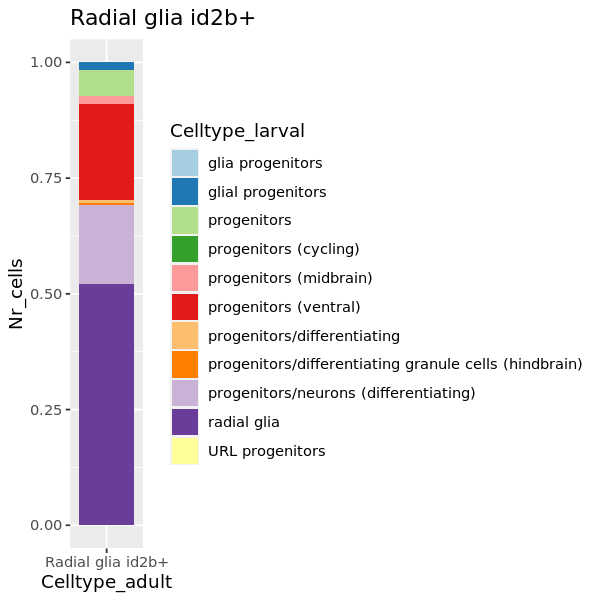

In [790]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia id2b+")

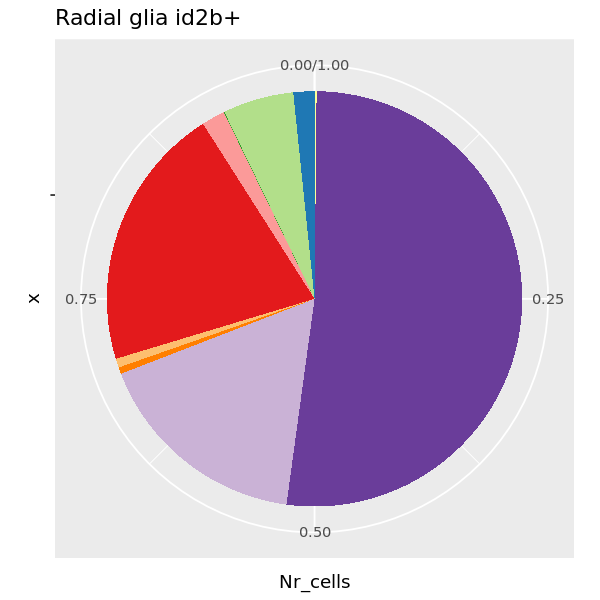

In [791]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia id2b+") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia id3+ (dien)

In [792]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia id3+ (dien)"),]))
cumsum_vector

0           3           6           7           8          13 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         16          18          19          26          27          29 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         30           2          21          22          24          12 
  0.0000000   0.1342282   0.2684564   0.4026846   0.5369128   0.8053691 
         20          23           5          15          25          10 
  1.0738255   1.4765101   2.1476510   2.9530201   3.8926175   5.1006712 
         14           9          11           4          28           1 
  6.7114094   8.7248322  10.7382551  20.4026846  30.0671141  44.8322148 
         17 
100.0000000

In [793]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia id3+ (dien)"),])
cutoff_0.1

[1] 10

In [794]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "11" "4"  "28" "1"  "17"

In [795]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [796]:
sub_table

                                                       
                                                                 11           4
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                       1.3157895   5.2631579
  progenitors                                             3.1366872   4.2224635
  progenitors (cycling)                                   0.0000000   0.0000000
  progenitors (midbrain)                                  0.0000000   2.9282577
  progenitors (ventral)                                  14.3442623 112.7049180
  progenitors/differentiating                             0.0000000   0.0000000
  progenitors/differentiating granule cells (hindbrain)   0.0000000   0.0000000
  progenitors/neurons (differentiating)                   0.0000000   0.0000000
  radial glia                                           138.3265857 140.6882591
  URL progenitors                                         0.8873

In [797]:
sub_rowsum <- rowSums(sub_table)

In [798]:
sub_rowsum

glia progenitors 
                                             0.000000 
                                    glial progenitors 
                                             9.210526 
                                          progenitors 
                                            21.232959 
                                progenitors (cycling) 
                                             0.000000 
                               progenitors (midbrain) 
                                             5.856515 
                                progenitors (ventral) 
                                           325.819672 
                         progenitors/differentiating  
                                             1.964636 
progenitors/differentiating granule cells (hindbrain) 
                                             5.730659 
                progenitors/neurons (differentiating) 
                                             1.872659 
                                          radial glia 
                                           360.998650 
                                      URL progenitors 
                                             1.774623

In [799]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia id3+ (dien)")
head(sub_df)

Celltype_larval        Nr_cells  
glia progenitors       glia progenitors         0.000000
glial progenitors      glial progenitors        9.210526
progenitors            progenitors             21.232959
progenitors (cycling)  progenitors (cycling)    0.000000
progenitors (midbrain) progenitors (midbrain)   5.856515
progenitors (ventral)  progenitors (ventral)  325.819672
                       Celltype_adult         
glia progenitors       Radial glia id3+ (dien)
glial progenitors      Radial glia id3+ (dien)
progenitors            Radial glia id3+ (dien)
progenitors (cycling)  Radial glia id3+ (dien)
progenitors (midbrain) Radial glia id3+ (dien)
progenitors (ventral)  Radial glia id3+ (dien)

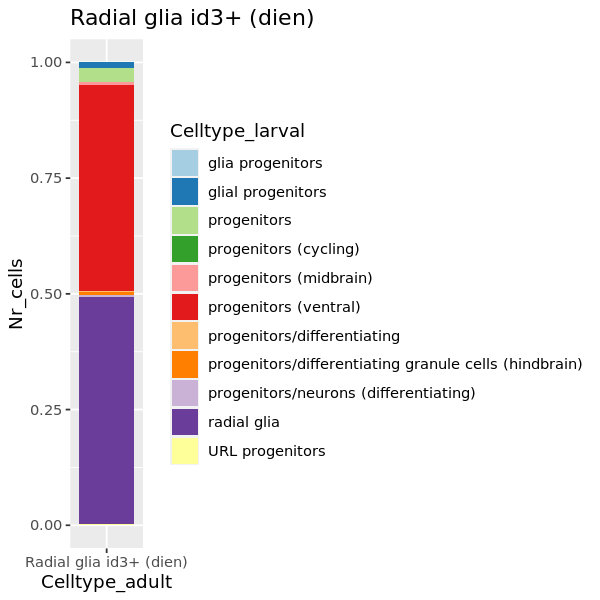

In [800]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia id3+ (dien)")

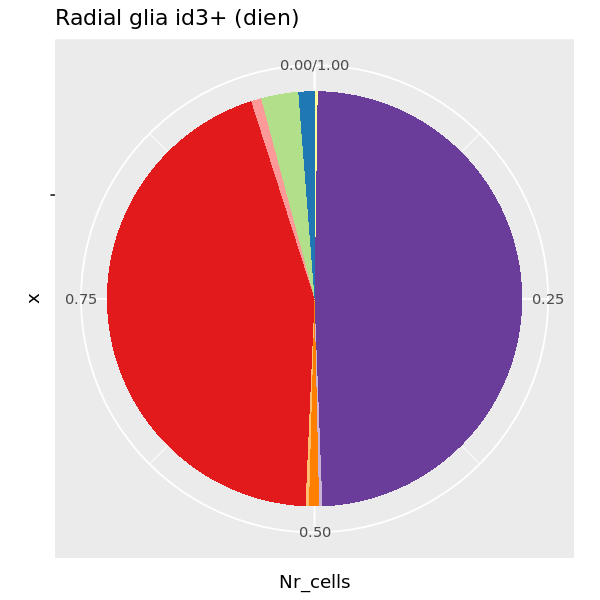

In [801]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia id3+ (dien)") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia nppc+

In [802]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia nppc+"),]))
cumsum_vector

0            2            3            7            9           17 
  0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000 
          18           19           21           24           25           26 
  0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000 
          10           14           29            5            8           27 
  0.08658009   0.17316018   0.25974027   0.43290044   0.60606061   0.77922078 
          28           15           13           30           23           20 
  0.95238095   1.21212121   1.64502164   2.07792207   2.59740259   3.54978354 
           6           16           22            4            1           11 
  4.67532467   5.80086580   9.95670996  14.28571429  20.77922078  47.96536797 
          12 
100.00000000

In [803]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia nppc+"),])
cutoff_0.1

[1] 10

In [804]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "4"  "1"  "11" "12"

In [805]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [806]:
sub_table

                                                       
                                                                  4           1
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                       5.2631579   2.6315789
  progenitors                                             4.2224635   2.4128363
  progenitors (cycling)                                   0.0000000   0.0000000
  progenitors (midbrain)                                  2.9282577   0.0000000
  progenitors (ventral)                                 112.7049180  16.3934426
  progenitors/differentiating                             0.0000000   1.9646365
  progenitors/differentiating granule cells (hindbrain)   0.0000000   5.7306590
  progenitors/neurons (differentiating)                   0.0000000   0.3121099
  radial glia                                           140.6882591   5.7354926
  URL progenitors                                         0.0000

In [807]:
sub_rowsum <- rowSums(sub_table)

In [808]:
sub_rowsum

glia progenitors 
                                            0.0000000 
                                    glial progenitors 
                                            9.2105263 
                                          progenitors 
                                            9.7719870 
                                progenitors (cycling) 
                                            0.0000000 
                               progenitors (midbrain) 
                                            2.9282577 
                                progenitors (ventral) 
                                          147.5409836 
                         progenitors/differentiating  
                                            1.9646365 
progenitors/differentiating granule cells (hindbrain) 
                                            5.7306590 
                progenitors/neurons (differentiating) 
                                            0.3121099 
                                          radial glia 
                                          484.8178138 
                                      URL progenitors 
                                            1.7746228

In [809]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia nppc+")
head(sub_df)

Celltype_larval        Nr_cells   Celltype_adult   
glia progenitors       glia progenitors         0.000000 Radial glia nppc+
glial progenitors      glial progenitors        9.210526 Radial glia nppc+
progenitors            progenitors              9.771987 Radial glia nppc+
progenitors (cycling)  progenitors (cycling)    0.000000 Radial glia nppc+
progenitors (midbrain) progenitors (midbrain)   2.928258 Radial glia nppc+
progenitors (ventral)  progenitors (ventral)  147.540984 Radial glia nppc+

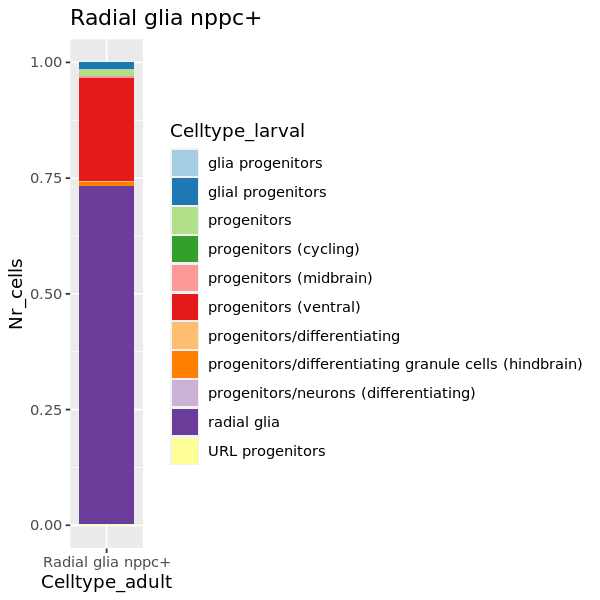

In [810]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia nppc+")

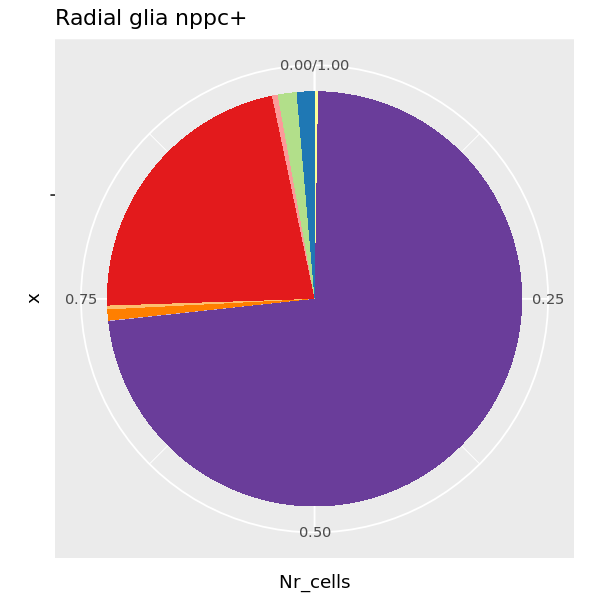

In [811]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia nppc+") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia nrg1+ (rhom)

In [812]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia nrg1+ (rhom)"),]))
cumsum_vector

0           2           3           5           7           8 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
          9          10          15          16          17          18 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         21          25          26          27          28          29 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         30          14          19          23          24          13 
  0.0000000   0.2604167   0.5208333   0.7812500   1.0416667   1.8229167 
         20           6          11          12           4           1 
  2.6041667   3.6458334   5.2083334  10.9375000  17.9687500  31.5104167 
         22 
100.0000000

In [813]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia nrg1+ (rhom)"),])
cutoff_0.1

[1] 10

In [814]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "12" "4"  "1"  "22"

In [815]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [816]:
sub_table

                                                       
                                                                 12           4
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                       0.0000000   5.2631579
  progenitors                                             0.0000000   4.2224635
  progenitors (cycling)                                   0.0000000   0.0000000
  progenitors (midbrain)                                  0.0000000   2.9282577
  progenitors (ventral)                                   4.0983607 112.7049180
  progenitors/differentiating                             0.0000000   0.0000000
  progenitors/differentiating granule cells (hindbrain)   0.0000000   0.0000000
  progenitors/neurons (differentiating)                   0.0000000   0.0000000
  radial glia                                           200.0674764 140.6882591
  URL progenitors                                         0.0000

In [817]:
sub_rowsum <- rowSums(sub_table)

In [818]:
sub_rowsum

glia progenitors 
                                             0.000000 
                                    glial progenitors 
                                            57.894737 
                                          progenitors 
                                            13.029316 
                                progenitors (cycling) 
                                             0.000000 
                               progenitors (midbrain) 
                                             7.320644 
                                progenitors (ventral) 
                                           193.647541 
                         progenitors/differentiating  
                                             1.964636 
progenitors/differentiating granule cells (hindbrain) 
                                             5.730659 
                progenitors/neurons (differentiating) 
                                             2.184769 
                                          radial glia 
                                           392.712551 
                                      URL progenitors 
                                             7.098491

In [819]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia nrg1+ (rhom)")
head(sub_df)

Celltype_larval        Nr_cells  
glia progenitors       glia progenitors         0.000000
glial progenitors      glial progenitors       57.894737
progenitors            progenitors             13.029316
progenitors (cycling)  progenitors (cycling)    0.000000
progenitors (midbrain) progenitors (midbrain)   7.320644
progenitors (ventral)  progenitors (ventral)  193.647541
                       Celltype_adult          
glia progenitors       Radial glia nrg1+ (rhom)
glial progenitors      Radial glia nrg1+ (rhom)
progenitors            Radial glia nrg1+ (rhom)
progenitors (cycling)  Radial glia nrg1+ (rhom)
progenitors (midbrain) Radial glia nrg1+ (rhom)
progenitors (ventral)  Radial glia nrg1+ (rhom)

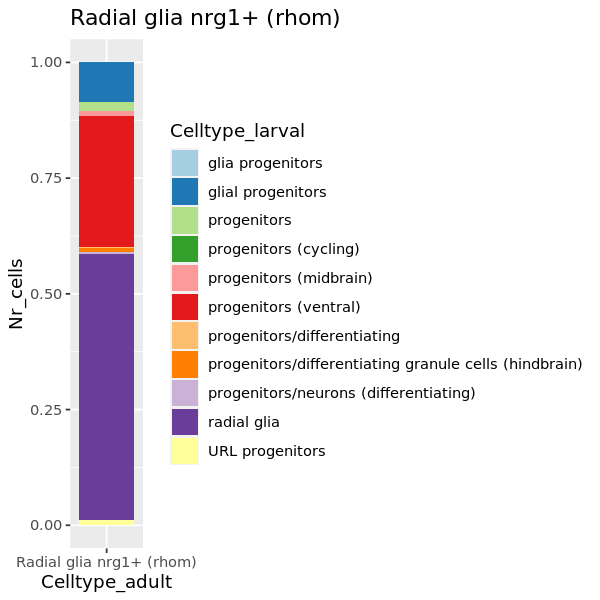

In [820]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia nrg1+ (rhom)")

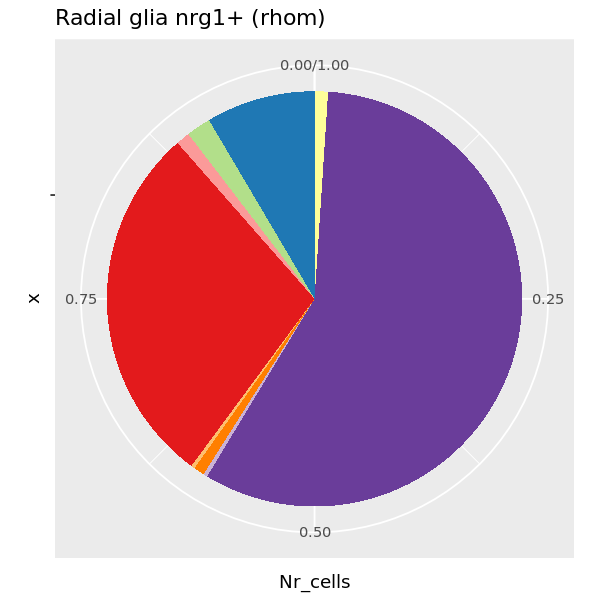

In [821]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia nrg1+ (rhom)") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia ntn1b+ (dien)

In [822]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia ntn1b+ (dien)"),]))
cumsum_vector

0           3           7           8          13          15 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         16          18          21          22          23          24 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         25          26          30           5           6          20 
  0.0000000   0.0000000   0.0000000   0.2590674   0.5181347   0.7772021 
         27          28          29           2          10          14 
  1.0362694   1.2953368   1.5544042   2.0725389   2.5906736   3.1088083 
         19           9          12          11           1          17 
  3.6269430   4.4041451   6.4766840  12.6943006  30.3108809  53.8860104 
          4 
100.0000000

In [823]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia ntn1b+ (dien)"),])
cutoff_0.1

[1] 10

In [824]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "11" "1"  "17" "4"

In [825]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [826]:
sub_table

                                                       
                                                                 11           1
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                       1.3157895   2.6315789
  progenitors                                             3.1366872   2.4128363
  progenitors (cycling)                                   0.0000000   0.0000000
  progenitors (midbrain)                                  0.0000000   0.0000000
  progenitors (ventral)                                  14.3442623  16.3934426
  progenitors/differentiating                             0.0000000   1.9646365
  progenitors/differentiating granule cells (hindbrain)   0.0000000   5.7306590
  progenitors/neurons (differentiating)                   0.0000000   0.3121099
  radial glia                                           138.3265857   5.7354926
  URL progenitors                                         0.8873

In [827]:
sub_rowsum <- rowSums(sub_table)

In [828]:
sub_rowsum

glia progenitors 
                                             0.000000 
                                    glial progenitors 
                                             9.210526 
                                          progenitors 
                                            21.112318 
                                progenitors (cycling) 
                                             0.000000 
                               progenitors (midbrain) 
                                             5.856515 
                                progenitors (ventral) 
                                           325.819672 
                         progenitors/differentiating  
                                             1.964636 
progenitors/differentiating granule cells (hindbrain) 
                                             5.730659 
                progenitors/neurons (differentiating) 
                                             1.872659 
                                          radial glia 
                                           360.998650 
                                      URL progenitors 
                                             1.774623

In [829]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia ntn1b+ (dien)")
head(sub_df)

Celltype_larval        Nr_cells  
glia progenitors       glia progenitors         0.000000
glial progenitors      glial progenitors        9.210526
progenitors            progenitors             21.112318
progenitors (cycling)  progenitors (cycling)    0.000000
progenitors (midbrain) progenitors (midbrain)   5.856515
progenitors (ventral)  progenitors (ventral)  325.819672
                       Celltype_adult           
glia progenitors       Radial glia ntn1b+ (dien)
glial progenitors      Radial glia ntn1b+ (dien)
progenitors            Radial glia ntn1b+ (dien)
progenitors (cycling)  Radial glia ntn1b+ (dien)
progenitors (midbrain) Radial glia ntn1b+ (dien)
progenitors (ventral)  Radial glia ntn1b+ (dien)

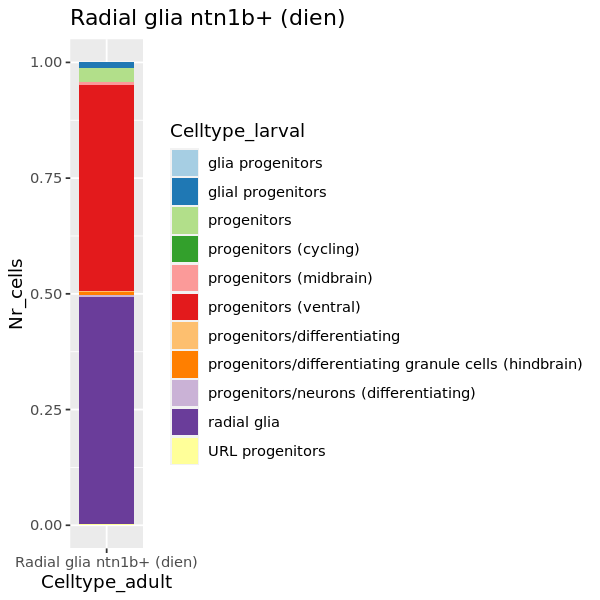

In [830]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia ntn1b+ (dien)")

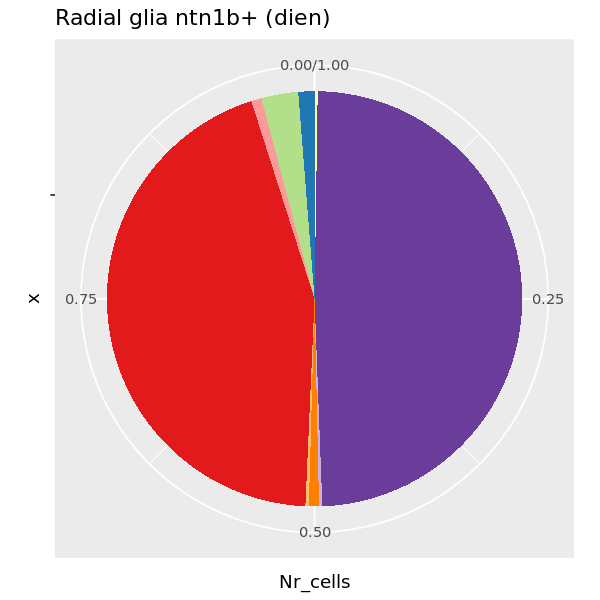

In [831]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia ntn1b+ (dien)") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia prss35+ (rhom)

In [832]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia prss35+ (rhom)"),]))
cumsum_vector

2           3           7           8           9          10 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         11          12          16          17          18          23 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         24          25          26          27          29          30 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
          6          14          28           4          15          21 
  0.1136364   0.2272727   0.3409091   0.6818182   1.0227273   1.3636363 
          5          20           0          22          13           1 
  1.9318182   2.5000000   3.2954545   4.6590909   6.2500000  14.5454545 
         19 
100.0000000

In [833]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia prss35+ (rhom)"),])
cutoff_0.1

[1] 10

In [834]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "1"  "19"

In [835]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [836]:
sub_table

                                                       
                                                                 1         19
  glia progenitors                                       0.0000000  0.0000000
  glial progenitors                                      2.6315789 82.8947368
  progenitors                                            2.4128363  0.1206418
  progenitors (cycling)                                  0.0000000  0.0000000
  progenitors (midbrain)                                 0.0000000  0.0000000
  progenitors (ventral)                                 16.3934426  0.0000000
  progenitors/differentiating                            1.9646365  0.0000000
  progenitors/differentiating granule cells (hindbrain)  5.7306590  0.0000000
  progenitors/neurons (differentiating)                  0.3121099  0.0000000
  radial glia                                            5.7354926  3.7112011
  URL progenitors                                        0.8873114 57.6752440

In [837]:
sub_rowsum <- rowSums(sub_table)

In [838]:
sub_rowsum

glia progenitors 
                                            0.0000000 
                                    glial progenitors 
                                           85.5263157 
                                          progenitors 
                                            2.5334781 
                                progenitors (cycling) 
                                            0.0000000 
                               progenitors (midbrain) 
                                            0.0000000 
                                progenitors (ventral) 
                                           16.3934426 
                         progenitors/differentiating  
                                            1.9646365 
progenitors/differentiating granule cells (hindbrain) 
                                            5.7306590 
                progenitors/neurons (differentiating) 
                                            0.3121099 
                                          radial glia 
                                            9.4466937 
                                      URL progenitors 
                                           58.5625554

In [839]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia prss35+ (rhom)")
head(sub_df)

Celltype_larval        Nr_cells 
glia progenitors       glia progenitors        0.000000
glial progenitors      glial progenitors      85.526316
progenitors            progenitors             2.533478
progenitors (cycling)  progenitors (cycling)   0.000000
progenitors (midbrain) progenitors (midbrain)  0.000000
progenitors (ventral)  progenitors (ventral)  16.393443
                       Celltype_adult            
glia progenitors       Radial glia prss35+ (rhom)
glial progenitors      Radial glia prss35+ (rhom)
progenitors            Radial glia prss35+ (rhom)
progenitors (cycling)  Radial glia prss35+ (rhom)
progenitors (midbrain) Radial glia prss35+ (rhom)
progenitors (ventral)  Radial glia prss35+ (rhom)

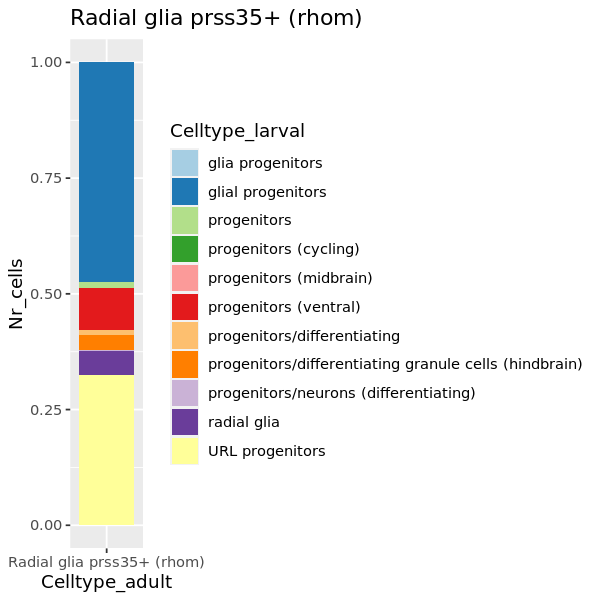

In [840]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia prss35+ (rhom)")

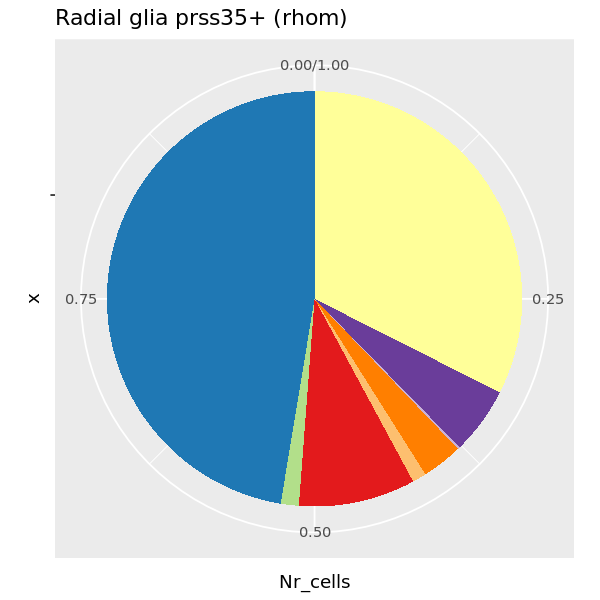

In [841]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia prss35+ (rhom)") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia RP high(rhom)

In [842]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia RP high(rhom)"),]))
cumsum_vector

7          17          18          19          20          22 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         23          24          25          26          27          28 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         29          30           2           6          16          12 
  0.0000000   0.0000000   0.4310345   0.8620690   1.2931034   2.1551724 
          8           9          10           0          13           5 
  3.4482759   4.7413793   6.0344828   7.7586207   9.9137931  12.5000000 
          4          11          14          21           1           3 
 15.5172414  18.5344828  21.5517241  25.4310345  30.6034483  44.3965517 
         15 
100.0000000

In [843]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia RP high(rhom)"),])
cutoff_0.1

[1] 10

In [844]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "5"  "4"  "11" "14" "21" "1"  "3"  "15"

In [845]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [846]:
sub_table

                                                       
                                                                  5           4
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                      48.6842105   5.2631579
  progenitors                                            68.1626252   4.2224635
  progenitors (cycling)                                  33.0578512   0.0000000
  progenitors (midbrain)                                 17.5695461   2.9282577
  progenitors (ventral)                                  29.7131148 112.7049180
  progenitors/differentiating                           481.3359528   0.0000000
  progenitors/differentiating granule cells (hindbrain) 931.2320917   0.0000000
  progenitors/neurons (differentiating)                  37.1410737   0.0000000
  radial glia                                            43.1848853 140.6882591
  URL progenitors                                        57.6752

In [847]:
sub_rowsum <- rowSums(sub_table)

In [848]:
sub_rowsum

glia progenitors 
                                            359.37500 
                                    glial progenitors 
                                            293.42105 
                                          progenitors 
                                            390.03499 
                                progenitors (cycling) 
                                            410.27155 
                               progenitors (midbrain) 
                                            118.59444 
                                progenitors (ventral) 
                                            262.29508 
                         progenitors/differentiating  
                                            548.13360 
progenitors/differentiating granule cells (hindbrain) 
                                            942.69341 
                progenitors/neurons (differentiating) 
                                             61.48564 
                                          radial glia 
                                            372.13225 
                                      URL progenitors 
                                            202.30701

In [849]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia RP high(rhom)")
head(sub_df)

Celltype_larval        Nr_cells
glia progenitors       glia progenitors       359.3750
glial progenitors      glial progenitors      293.4211
progenitors            progenitors            390.0350
progenitors (cycling)  progenitors (cycling)  410.2715
progenitors (midbrain) progenitors (midbrain) 118.5944
progenitors (ventral)  progenitors (ventral)  262.2951
                       Celltype_adult           
glia progenitors       Radial glia RP high(rhom)
glial progenitors      Radial glia RP high(rhom)
progenitors            Radial glia RP high(rhom)
progenitors (cycling)  Radial glia RP high(rhom)
progenitors (midbrain) Radial glia RP high(rhom)
progenitors (ventral)  Radial glia RP high(rhom)

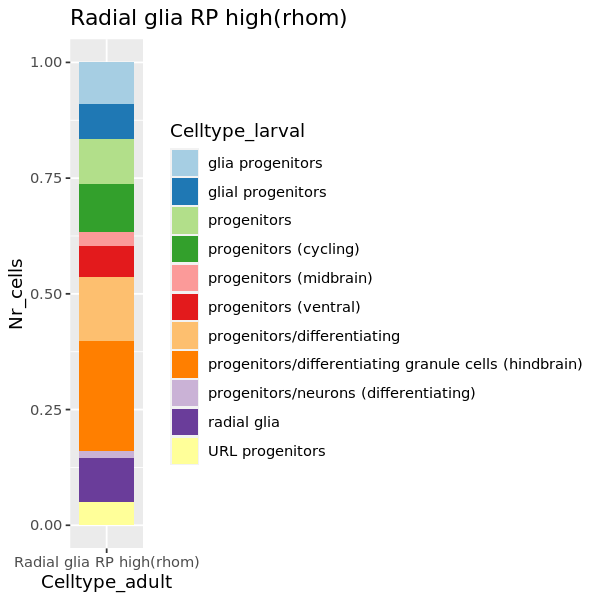

In [850]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia RP high(rhom)")

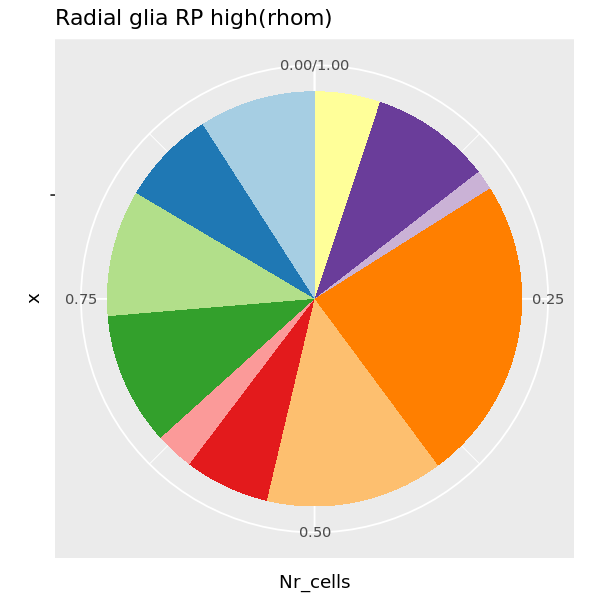

In [851]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia RP high(rhom)") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia snap25a+

In [852]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia snap25a+"),]))
cumsum_vector

7           18           30            2            8           23 
  0.00000000   0.00000000   0.00000000   0.03144654   0.06289308   0.09433962 
          25           29            9           14           22           13 
  0.12578616   0.15723270   0.31446540   0.47169810   0.62893080   0.97484275 
          26           24            0           17           27           12 
  1.38364778   1.82389935   2.29559746   2.83018865   3.36477984   3.93081758 
          28           19           10            3           21            4 
  4.62264148   5.59748425   6.63522010   7.73584903   9.40251570  11.28930815 
           5            6           15           11           16            1 
 15.15723268  19.33962262  27.98742136  37.95597482  50.88050312  75.31446538 
          20 
 99.99999997

In [853]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia snap25a+"),])
cutoff_0.1

[1] 10

In [854]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "4"  "5"  "6"  "15" "11" "16" "1"  "20"

In [855]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [856]:
sub_table

                                                       
                                                                  4           5
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                       5.2631579  48.6842105
  progenitors                                             4.2224635  68.1626252
  progenitors (cycling)                                   0.0000000  33.0578512
  progenitors (midbrain)                                  2.9282577  17.5695461
  progenitors (ventral)                                 112.7049180  29.7131148
  progenitors/differentiating                             0.0000000 481.3359528
  progenitors/differentiating granule cells (hindbrain)   0.0000000 931.2320917
  progenitors/neurons (differentiating)                   0.0000000  37.1410737
  radial glia                                           140.6882591  43.1848853
  URL progenitors                                         0.0000

In [857]:
sub_rowsum <- rowSums(sub_table)

In [858]:
sub_rowsum

glia progenitors 
                                              0.00000 
                                    glial progenitors 
                                             65.78947 
                                          progenitors 
                                            148.14815 
                                progenitors (cycling) 
                                             41.91263 
                               progenitors (midbrain) 
                                             26.35432 
                                progenitors (ventral) 
                                            177.25410 
                         progenitors/differentiating  
                                            495.08841 
progenitors/differentiating granule cells (hindbrain) 
                                            936.96275 
                progenitors/neurons (differentiating) 
                                             37.76529 
                                          radial glia 
                                            486.50472 
                                      URL progenitors 
                                             81.63265

In [859]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia snap25a+")
head(sub_df)

Celltype_larval        Nr_cells  Celltype_adult      
glia progenitors       glia progenitors         0.00000 Radial glia snap25a+
glial progenitors      glial progenitors       65.78947 Radial glia snap25a+
progenitors            progenitors            148.14815 Radial glia snap25a+
progenitors (cycling)  progenitors (cycling)   41.91263 Radial glia snap25a+
progenitors (midbrain) progenitors (midbrain)  26.35432 Radial glia snap25a+
progenitors (ventral)  progenitors (ventral)  177.25410 Radial glia snap25a+

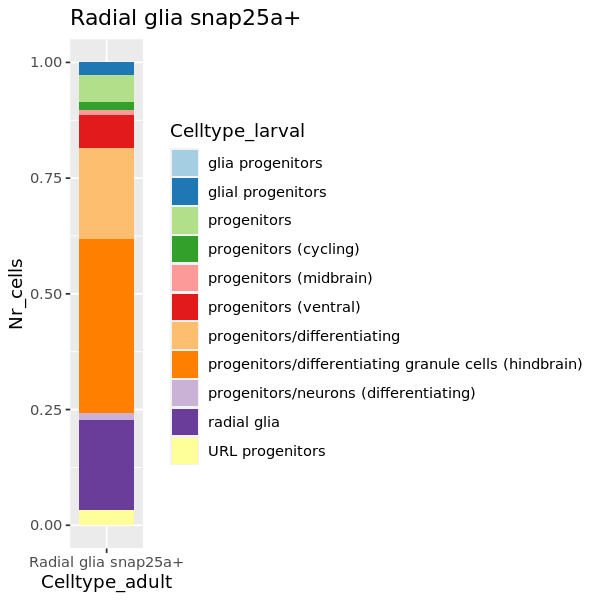

In [860]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia snap25a+")

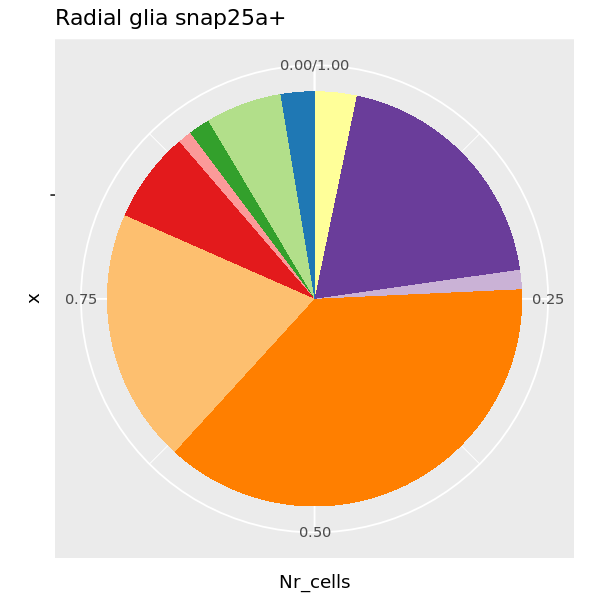

In [861]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia snap25a+") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia stat2+

In [862]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia stat2+"),]))
cumsum_vector

0           2           3           7           8           9 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         10          13          14          18          19          21 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         24          25          26          29          30           5 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.7194245 
         12          17          22          23          27          28 
  1.4388489   2.1582734   2.8776978   3.5971223   4.3165468   5.0359712 
          1          15          20           6          16          11 
  7.9136691  11.5107914  18.7050360  31.6546762  47.4820144  69.7841727 
          4 
100.0000000

In [863]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia stat2+"),])
cutoff_0.1

[1] 10

In [864]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "15" "20" "6"  "16" "11" "4"

In [865]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [866]:
sub_table

                                                       
                                                                 15          20
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                       5.2631579   1.3157895
  progenitors                                            68.4039088   0.6032091
  progenitors (cycling)                                   8.8547816   0.0000000
  progenitors (midbrain)                                  5.8565154   0.0000000
  progenitors (ventral)                                   1.0245902   0.0000000
  progenitors/differentiating                             9.8231827   1.9646365
  progenitors/differentiating granule cells (hindbrain)   0.0000000   0.0000000
  progenitors/neurons (differentiating)                   0.3121099   0.0000000
  radial glia                                            17.5438596   7.7597841
  URL progenitors                                        22.1827

In [867]:
sub_rowsum <- rowSums(sub_table)

In [868]:
sub_rowsum

glia progenitors 
                                            0.0000000 
                                    glial progenitors 
                                           14.4736843 
                                          progenitors 
                                           77.5726867 
                                progenitors (cycling) 
                                            8.8547816 
                               progenitors (midbrain) 
                                            8.7847731 
                                progenitors (ventral) 
                                          131.1475410 
                         progenitors/differentiating  
                                           11.7878192 
progenitors/differentiating granule cells (hindbrain) 
                                            0.0000000 
                progenitors/neurons (differentiating) 
                                            0.3121099 
                                          radial glia 
                                          437.5843455 
                                      URL progenitors 
                                           23.0700976

In [869]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia stat2+")
head(sub_df)

Celltype_larval        Nr_cells   Celltype_adult    
glia progenitors       glia progenitors         0.000000 Radial glia stat2+
glial progenitors      glial progenitors       14.473684 Radial glia stat2+
progenitors            progenitors             77.572687 Radial glia stat2+
progenitors (cycling)  progenitors (cycling)    8.854782 Radial glia stat2+
progenitors (midbrain) progenitors (midbrain)   8.784773 Radial glia stat2+
progenitors (ventral)  progenitors (ventral)  131.147541 Radial glia stat2+

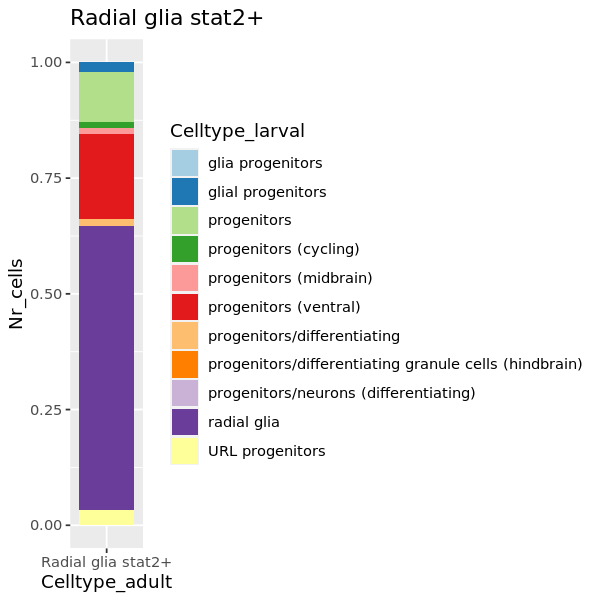

In [870]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia stat2+")

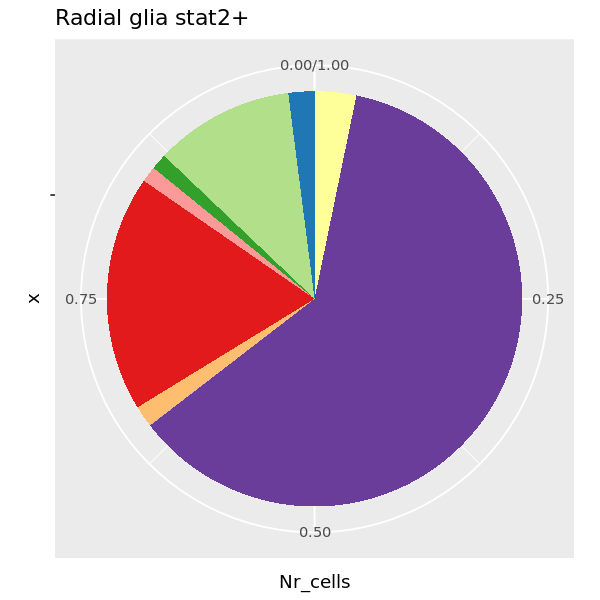

In [871]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia stat2+") +
    coord_polar("y", start=0) +
    NoLegend()

##### Radial glia stra6+ (mes)

In [872]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia stra6+ (mes)"),]))
cumsum_vector

0          2          3          5          7          8          9 
  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000 
        13         15         17         18         19         21         22 
  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000 
        23         24         25         26         27         29         30 
  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000 
        10         11         28          4         12         16         20 
  1.333333   2.666667   4.000000   6.666667   9.333333  13.333333  20.000000 
        14          1          6 
 28.000000  37.333333 100.000000

In [873]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia stra6+ (mes)"),])
cutoff_0.1

[1] 10

In [874]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "16" "20" "14" "1"  "6"

In [875]:
sub_table <- celltype_lar.by.cluster[, sub_clusters]

In [876]:
sub_table

                                                       
                                                                 16          20
  glia progenitors                                        0.0000000   0.0000000
  glial progenitors                                       0.0000000   1.3157895
  progenitors                                             0.2412836   0.6032091
  progenitors (cycling)                                   0.0000000   0.0000000
  progenitors (midbrain)                                  0.0000000   0.0000000
  progenitors (ventral)                                   0.0000000   0.0000000
  progenitors/differentiating                             0.0000000   1.9646365
  progenitors/differentiating granule cells (hindbrain)   0.0000000   0.0000000
  progenitors/neurons (differentiating)                   0.0000000   0.0000000
  radial glia                                            42.5101215   7.7597841
  URL progenitors                                         0.0000

In [877]:
sub_rowsum <- rowSums(sub_table)

In [878]:
sub_rowsum

glia progenitors 
                                           359.375000 
                                    glial progenitors 
                                           207.894737 
                                          progenitors 
                                            50.066353 
                                progenitors (cycling) 
                                             2.361275 
                               progenitors (midbrain) 
                                            21.961933 
                                progenitors (ventral) 
                                           102.459016 
                         progenitors/differentiating  
                                             7.858546 
progenitors/differentiating granule cells (hindbrain) 
                                             5.730659 
                progenitors/neurons (differentiating) 
                                             3.433208 
                                          radial glia 
                                           154.858300 
                                      URL progenitors 
                                            37.267081

In [879]:
sub_df <- data.frame("Celltype_larval" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia stra6+ (mes)")
head(sub_df)

Celltype_larval        Nr_cells  
glia progenitors       glia progenitors       359.375000
glial progenitors      glial progenitors      207.894737
progenitors            progenitors             50.066353
progenitors (cycling)  progenitors (cycling)    2.361275
progenitors (midbrain) progenitors (midbrain)  21.961933
progenitors (ventral)  progenitors (ventral)  102.459016
                       Celltype_adult          
glia progenitors       Radial glia stra6+ (mes)
glial progenitors      Radial glia stra6+ (mes)
progenitors            Radial glia stra6+ (mes)
progenitors (cycling)  Radial glia stra6+ (mes)
progenitors (midbrain) Radial glia stra6+ (mes)
progenitors (ventral)  Radial glia stra6+ (mes)

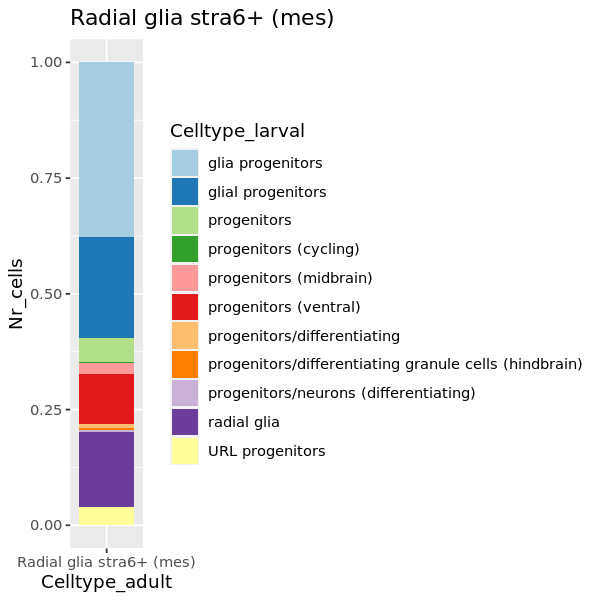

In [880]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia stra6+ (mes)")

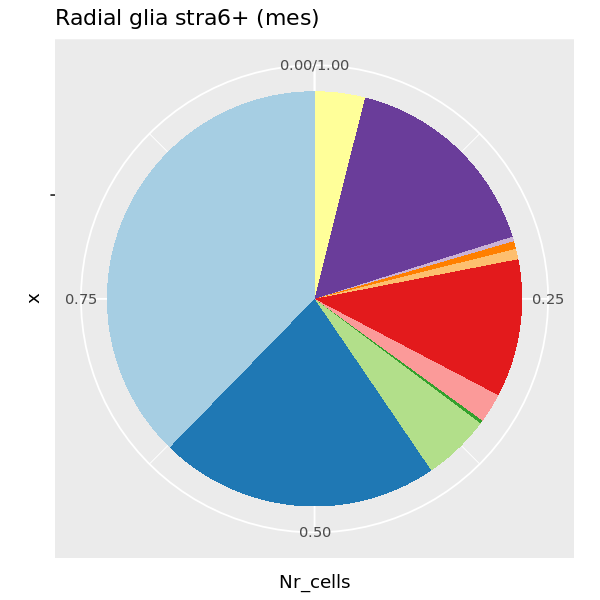

In [881]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia stra6+ (mes)") +
    coord_polar("y", start=0) +
    NoLegend()

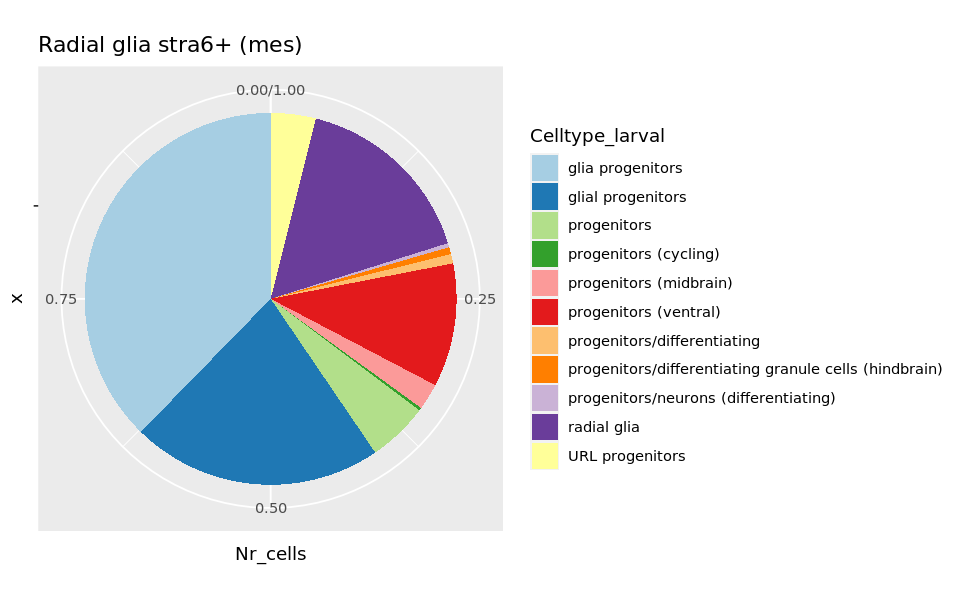

In [882]:
options(repr.plot.width=8, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = Celltype_larval)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "Paired") +
    ggtitle("Radial glia stra6+ (mes)") +
    coord_polar("y", start=0) 

### Quantify timepoint of larval data that co-cluster with adult cell types


Use adult cell types as reference to ask which stage co-cluster with each specific adult cell type (especially those that are interesting in the narrative of the manuscript). Seurat clusters as the unit of co-clustering. Question is, is there an observable trend? (eg some adult clusters co-cluster more with early stages, some with late?)  

In [4]:
table(prog.combined$stage)


       adult larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
       15829         9782         1619         2049         2988         4181 

Version 1: without normalization

Do with and without adult timepoint, for comparison (rerun code)

In [5]:
celltype_ad.by.cluster <- table(prog.combined$pc28_res0.8_named_detailed, prog.combined$seurat_clusters)

In [6]:
celltype_ad.by.cluster[1:5,1:5]

                            
                               0   1   2   3   4
  Neuroepithelial cells        0   6   0   1   0
  Proliferating cells mcm6+    8  47  11  34   2
  Proliferating cells mki67+  12  34 241 144   4
  Radial glia RP high(rhom)    4  12   1  32   7
  Radial glia apof+ (mes)      5  31   0   1  11

In [7]:
stage.by.cluster <- table(prog.combined$stage, prog.combined$seurat_clusters)

In [8]:
stage.by.cluster[1:5,1:5]

              
                  0    1    2    3    4
  adult         169 2382  267  249 1465
  larvae_15dpf 1165   36  896  828  304
  larvae_2dpf   274    2  199   26   50
  larvae_3dpf   186    4  221  219   39
  larvae_5dpf   197    8  184  408   78

In [9]:
stage.by.cluster <- stage.by.cluster[-1,]

In [10]:
stage.by.cluster[1:5,1:5]

              
                  0    1    2    3    4
  larvae_15dpf 1165   36  896  828  304
  larvae_2dpf   274    2  199   26   50
  larvae_3dpf   186    4  221  219   39
  larvae_5dpf   197    8  184  408   78
  larvae_8dpf   465   10  455  434   97

Version 2: row-normalize both tables (rerun code chunks below after this)

In [11]:
celltype_ad.by.cluster <- round(prop.table(celltype_ad.by.cluster, margin = 1), digits = 10) * 100

In [12]:
celltype_ad.by.cluster[1:5,1:5]

                            
                                      0          1          2          3
  Neuroepithelial cells       0.0000000  2.5641026  0.0000000  0.4273504
  Proliferating cells mcm6+   1.2139605  7.1320182  1.6691958  5.1593323
  Proliferating cells mki67+  0.9615385  2.7243590 19.3108974 11.5384615
  Radial glia RP high(rhom)   1.7241379  5.1724138  0.4310345 13.7931035
  Radial glia apof+ (mes)     0.2958580  1.8343195  0.0000000  0.0591716
                            
                                      4
  Neuroepithelial cells       0.0000000
  Proliferating cells mcm6+   0.3034901
  Proliferating cells mki67+  0.3205128
  Radial glia RP high(rhom)   3.0172414
  Radial glia apof+ (mes)     0.6508876

In [13]:
stage.by.cluster <- round(prop.table(stage.by.cluster, margin = 1), digits = 10) * 1000

In [14]:
stage.by.cluster[1:5,1:5]

              
                        0          1          2          3          4
  larvae_15dpf 119.096299   3.680229  91.596811  84.645267  31.077489
  larvae_2dpf  169.240272   1.235330 122.915380  16.059296  30.883261
  larvae_3dpf   90.775988   1.952172 107.857491 106.881406  19.033675
  larvae_5dpf   65.930388   2.677376  61.579652 136.546185  26.104418
  larvae_8dpf  111.217412   2.391772 108.825640 103.802918  23.200191

#### Manually pick for snap25a+ - test case

In [15]:
celltype_ad.by.cluster[c("Radial glia snap25a+"),]

0           1           2           3           4           5 
 0.47169811 24.43396226  0.03144654  1.10062893  1.88679245  3.86792453 
          6           7           8           9          10          11 
 4.18238994  0.00000000  0.03144654  0.15723270  1.03773585  9.96855346 
         12          13          14          15          16          17 
 0.56603774  0.34591195  0.15723270  8.64779874 12.92452830  0.53459119 
         18          19          20          21          22          23 
 0.00000000  0.97484277 24.68553459  1.66666667  0.15723270  0.03144654 
         24          25          26          27          28          29 
 0.44025157  0.03144654  0.40880503  0.53459119  0.69182390  0.03144654 
         30 
 0.00000000

In [16]:
rownames(celltype_ad.by.cluster)

[1] "Neuroepithelial cells"       "Proliferating cells mcm6+"  
 [3] "Proliferating cells mki67+"  "Radial glia RP high(rhom)"  
 [5] "Radial glia apof+ (mes)"     "Radial glia crabp1b+ (rhom)"
 [7] "Radial glia enkur+"          "Radial glia foxn4+ (mes)"   
 [9] "Radial glia gfap++"          "Radial glia id2b+"          
[11] "Radial glia id3+ (dien)"     "Radial glia nppc+"          
[13] "Radial glia nrg1+ (rhom)"    "Radial glia ntn1b+ (dien)"  
[15] "Radial glia prss35+ (rhom)"  "Radial glia snap25a+"       
[17] "Radial glia stat2+"          "Radial glia stra6+ (mes)"

In [17]:
nrow(celltype_ad.by.cluster)

[1] 18

In [18]:
sort(celltype_ad.by.cluster[c("Radial glia snap25a+"),])

7          18          30           2           8          23 
 0.00000000  0.00000000  0.00000000  0.03144654  0.03144654  0.03144654 
         25          29           9          14          22          13 
 0.03144654  0.03144654  0.15723270  0.15723270  0.15723270  0.34591195 
         26          24           0          17          27          12 
 0.40880503  0.44025157  0.47169811  0.53459119  0.53459119  0.56603774 
         28          19          10           3          21           4 
 0.69182390  0.97484277  1.03773585  1.10062893  1.66666667  1.88679245 
          5           6          15          11          16           1 
 3.86792453  4.18238994  8.64779874  9.96855346 12.92452830 24.43396226 
         20 
24.68553459

In [19]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia snap25a+"),]))
cumsum_vector

7           18           30            2            8           23 
  0.00000000   0.00000000   0.00000000   0.03144654   0.06289308   0.09433962 
          25           29            9           14           22           13 
  0.12578616   0.15723270   0.31446540   0.47169810   0.62893080   0.97484275 
          26           24            0           17           27           12 
  1.38364778   1.82389935   2.29559746   2.83018865   3.36477984   3.93081758 
          28           19           10            3           21            4 
  4.62264148   5.59748425   6.63522010   7.73584903   9.40251570  11.28930815 
           5            6           15           11           16            1 
 15.15723268  19.33962262  27.98742136  37.95597482  50.88050312  75.31446538 
          20 
 99.99999997

In [20]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia snap25a+"),])
cutoff_0.1

[1] 10

In [21]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
clusters_snap25 <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
clusters_snap25

[1] "4"  "5"  "6"  "15" "11" "16" "1"  "20"

In [22]:
sub_snap25 <- stage.by.cluster[, clusters_snap25]

In [23]:
sub_snap25

              
                         4           5           6          15          11
  larvae_15dpf  31.0774893  80.7605807  17.2766305  29.9529749  35.7800041
  larvae_2dpf   30.8832613   8.6473132   3.7059914   1.8529957   0.0000000
  larvae_3dpf   19.0336750  56.6129819  11.2249878  38.0673499   1.4641288
  larvae_5dpf   26.1044177 137.8848728  11.3788487  38.8219545  12.3828648
  larvae_8dpf   23.2001913  59.5551304  11.7196843  44.0086104  14.8289883
              
                        16           1          20
  larvae_15dpf  10.2228583   3.6802290   2.1468002
  larvae_2dpf    0.0000000   1.2353305   0.0000000
  larvae_3dpf    0.4880429   1.9521718   1.4641288
  larvae_5dpf    3.0120482   2.6773762   1.6733601
  larvae_8dpf    4.3051901   2.3917723   0.2391772

In [24]:
sum_snap25 <- rowSums(sub_snap25)

In [25]:
sum_snap25

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
   210.89757     46.32489    130.30747    233.93574    160.24874

In [26]:
df_snap25 <- data.frame("Stage" = names(sum_snap25),
                       "Nr_cells" = sum_snap25,
                       "Celltype_adult" = "Radial glia snap25a+")
head(df_snap25)

Stage        Nr_cells  Celltype_adult      
larvae_15dpf larvae_15dpf 210.89757 Radial glia snap25a+
larvae_2dpf  larvae_2dpf   46.32489 Radial glia snap25a+
larvae_3dpf  larvae_3dpf  130.30747 Radial glia snap25a+
larvae_5dpf  larvae_5dpf  233.93574 Radial glia snap25a+
larvae_8dpf  larvae_8dpf  160.24874 Radial glia snap25a+

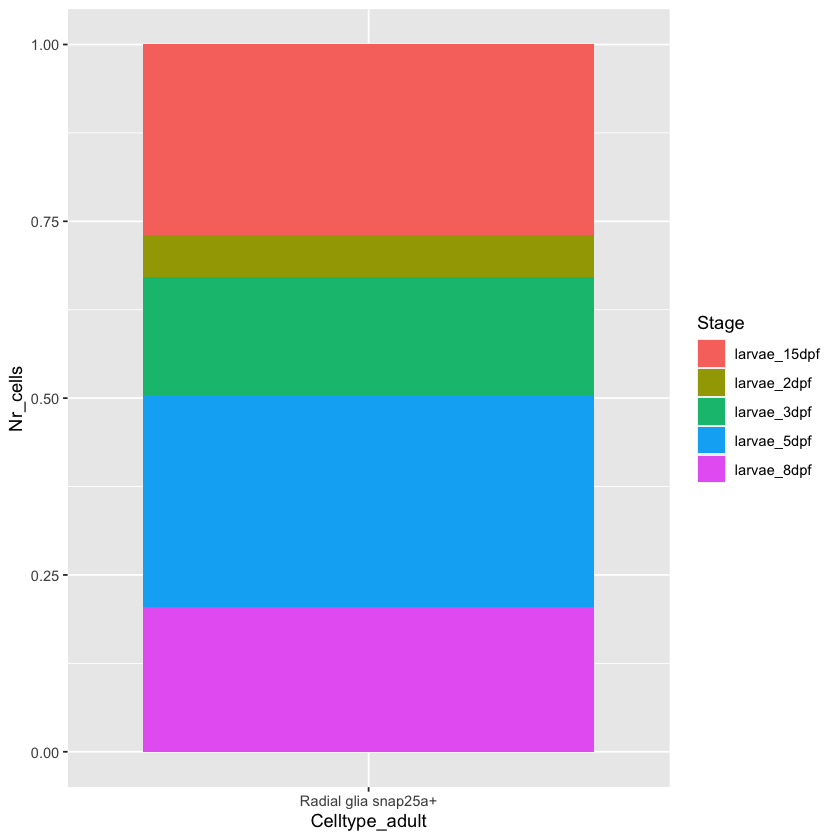

In [27]:
ggplot(data = df_snap25, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") 

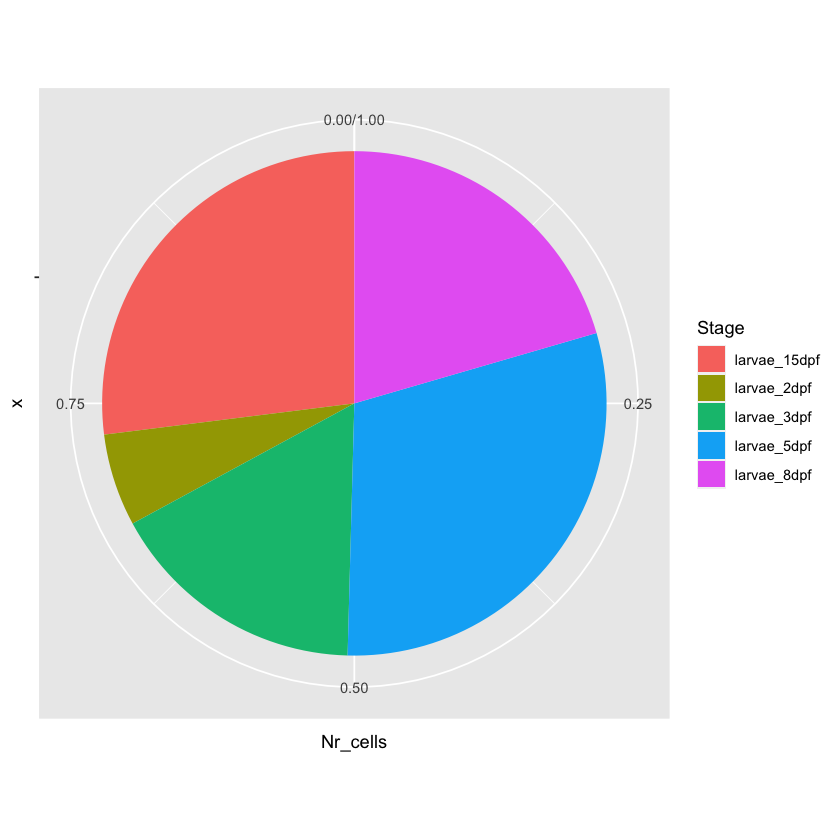

In [28]:
ggplot(data = df_snap25, aes(x = "", y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    coord_polar("y", start=0)

#### Add calculation for all RG types

In [29]:
table(prog.combined$pc28_res0.8_named_detailed)


      Neuroepithelial cells   Proliferating cells mcm6+ 
                        234                         659 
 Proliferating cells mki67+   Radial glia RP high(rhom) 
                       1248                         232 
    Radial glia apof+ (mes) Radial glia crabp1b+ (rhom) 
                       1690                         407 
         Radial glia enkur+    Radial glia foxn4+ (mes) 
                        637                         500 
         Radial glia gfap++           Radial glia id2b+ 
                        630                        2648 
    Radial glia id3+ (dien)           Radial glia nppc+ 
                        745                        1155 
   Radial glia nrg1+ (rhom)   Radial glia ntn1b+ (dien) 
                        384                         386 
 Radial glia prss35+ (rhom)        Radial glia snap25a+ 
                        880                        3180 
         Radial glia stat2+    Radial glia stra6+ (mes) 
                        139   

In [31]:
# use Set2 as palette for stage
stage_colors <-  c("larvae_2dpf" = "#8da0cb",
                  "larvae_3dpf" = "#e78ac3",
                  "larvae_5dpf" = "#a6d854", 
                  "larvae_8dpf" = "#ffd92f",
                  "larvae_15dpf" = "#fc8d62",
                  "adult" = "#66c2a5")

##### Neuroepithelial cells

In [32]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Neuroepithelial cells"),]))
cumsum_vector

0           2           4           7           9          10 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         11          12          13          16          17          18 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         19          22          23          25          26          29 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         30           3           5           6           8          20 
  0.0000000   0.4273504   0.8547009   1.2820513   1.7094017   2.1367521 
         27          15          21          28           1          14 
  2.5641026   3.4188034   4.2735043   5.9829060   8.5470085  11.5384615 
         24 
100.0000000

In [33]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Neuroepithelial cells"),])
cutoff_0.1

[1] 10

In [34]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "14" "24"

In [35]:
sub_table <- stage.by.cluster[, sub_clusters]

In [36]:
sub_table

              
                      14        24
  larvae_15dpf 31.895318 10.836230
  larvae_2dpf  40.765905  5.558987
  larvae_3dpf  37.091264  2.928258
  larvae_5dpf  35.475234  8.366801
  larvae_8dpf  41.616838  4.544367

In [37]:
sub_rowsum <- rowSums(sub_table)

In [38]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    42.73155     46.32489     40.01952     43.84203     46.16121

In [39]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Neuroepithelial cells")
head(sub_df)

Stage        Nr_cells Celltype_adult       
larvae_15dpf larvae_15dpf 42.73155 Neuroepithelial cells
larvae_2dpf  larvae_2dpf  46.32489 Neuroepithelial cells
larvae_3dpf  larvae_3dpf  40.01952 Neuroepithelial cells
larvae_5dpf  larvae_5dpf  43.84203 Neuroepithelial cells
larvae_8dpf  larvae_8dpf  46.16121 Neuroepithelial cells

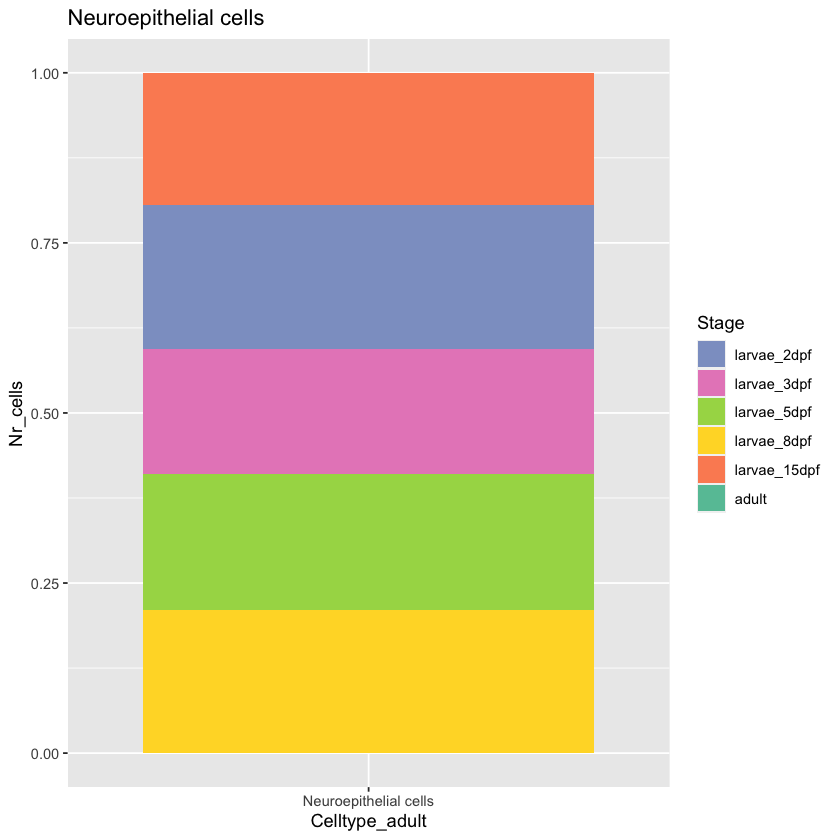

In [40]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Neuroepithelial cells")

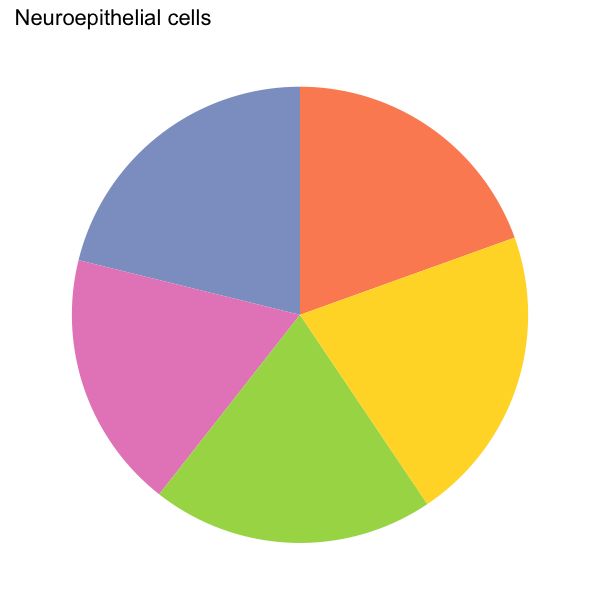

In [47]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Neuroepithelial cells") +
    coord_polar("y", start=0) +
    theme_void() + NoLegend()

In [48]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_neuroepithelial.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("NE") +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    coord_polar("y", start=0) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Proliferating cells mcm6+

In [49]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Proliferating cells mcm6+"),]))
cumsum_vector

6          11          12          16          19          20 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         24          25          28          29          30           7 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.1517451 
         15          23           4          14          17          22 
  0.3034901   0.4552352   0.7587254   1.0622155   1.3657056   1.6691958 
         27          18          21           0           2           5 
  1.9726859   2.4279211   3.1866465   4.4006070   6.0698028   8.0424886 
         10           3           1          26           8          13 
 11.5326252  16.6919575  23.8239757  34.9013657  52.8072838  75.8725342 
          9 
100.0000000

In [50]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Proliferating cells mcm6+"),])
cutoff_0.1

[1] 10

In [51]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "10" "3"  "1"  "26" "8"  "13" "9"

In [52]:
sub_table <- stage.by.cluster[, sub_clusters]

In [53]:
sub_table

              
                        10           3           1          26           8
  larvae_15dpf  48.5585770  84.6452668   3.6802290   6.8493151  62.5638929
  larvae_2dpf  175.4169240  16.0592959   1.2353305   0.6176652  96.9734404
  larvae_3dpf   40.9956076 106.8814056   1.9521718   0.4880429  94.6803319
  larvae_5dpf   40.1606426 136.5461847   2.6773762   1.6733601  52.8781794
  larvae_8dpf   46.1612055 103.8029180   2.3917723   1.4350634  88.7347525
              
                        13           9
  larvae_15dpf  38.2334901  60.0081783
  larvae_2dpf   17.9122915  82.1494750
  larvae_3dpf   18.5456320  73.2064422
  larvae_5dpf   29.7858099  61.2449799
  larvae_8dpf   32.2889261  81.7986128

In [54]:
sub_rowsum <- rowSums(sub_table)

In [55]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    304.5389     390.3644     336.7496     324.9665     356.6133

In [56]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Proliferating cells mcm6+")
head(sub_df)

Stage        Nr_cells Celltype_adult           
larvae_15dpf larvae_15dpf 304.5389 Proliferating cells mcm6+
larvae_2dpf  larvae_2dpf  390.3644 Proliferating cells mcm6+
larvae_3dpf  larvae_3dpf  336.7496 Proliferating cells mcm6+
larvae_5dpf  larvae_5dpf  324.9665 Proliferating cells mcm6+
larvae_8dpf  larvae_8dpf  356.6133 Proliferating cells mcm6+

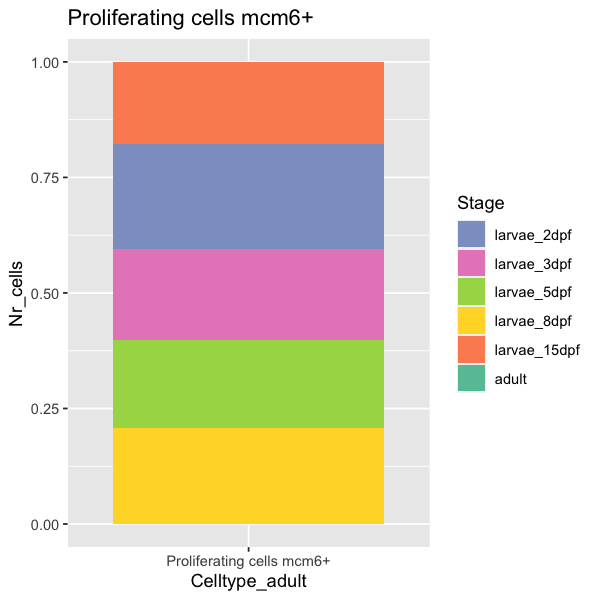

In [57]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Proliferating cells mcm6+")

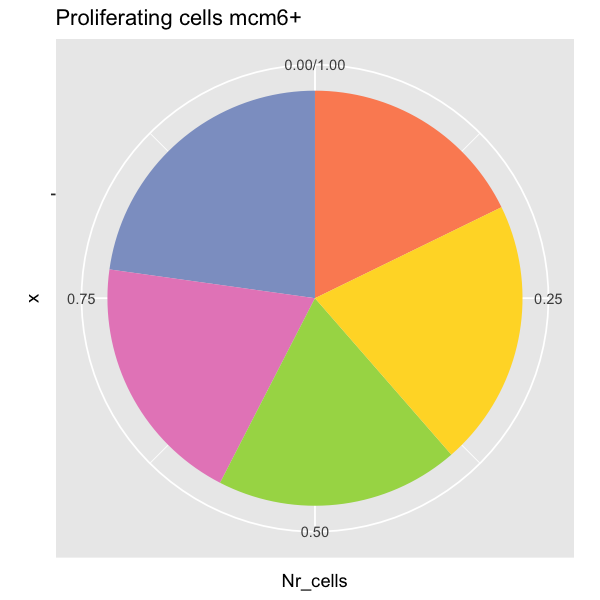

In [58]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Proliferating cells mcm6+") +
    coord_polar("y", start=0) + 
    NoLegend()

In [59]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_prol_mcm6.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Prol mcm6+") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Proliferating cells mki67+

In [60]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Proliferating cells mki67+"),]))
cumsum_vector

6           12           16           20           23           24 
  0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000 
          25           28           29           30           14           17 
  0.00000000   0.00000000   0.00000000   0.00000000   0.08012821   0.16025642 
          22           11           19           27            4           10 
  0.24038463   0.40064104   0.56089745   0.80128207   1.12179489   1.44230771 
          15           21            9           13            0            8 
  1.76282053   2.08333335   2.64423079   3.20512823   4.16666669   5.92948720 
           5            1            3           26            2            7 
  7.85256412  10.57692309  22.11538463  37.01923078  56.33012822  75.80128207 
          18 
100.00000002

In [61]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Proliferating cells mki67+"),])
cutoff_0.1

[1] 10

In [62]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "1"  "3"  "26" "2"  "7"  "18"

In [63]:
sub_table <- stage.by.cluster[, sub_clusters]

In [64]:
sub_table

              
                         1           3          26           2           7
  larvae_15dpf   3.6802290  84.6452668   6.8493151  91.5968105  66.8574934
  larvae_2dpf    1.2353305  16.0592959   0.6176652 122.9153799  94.5027795
  larvae_3dpf    1.9521718 106.8814056   0.4880429 107.8574915  78.0868716
  larvae_5dpf    2.6773762 136.5461847   1.6733601  61.5796519  73.6278447
  larvae_8dpf    2.3917723 103.8029180   1.4350634 108.8256398  74.3841186
              
                        18
  larvae_15dpf  50.8076058
  larvae_2dpf   15.4416306
  larvae_3dpf   23.4260615
  larvae_5dpf   19.0763052
  larvae_8dpf   17.2207606

In [65]:
sub_rowsum <- rowSums(sub_table)

In [66]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    304.4367     250.7721     318.6920     295.1807     308.0603

In [67]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Proliferating cells mki67+")
head(sub_df)

Stage        Nr_cells Celltype_adult            
larvae_15dpf larvae_15dpf 304.4367 Proliferating cells mki67+
larvae_2dpf  larvae_2dpf  250.7721 Proliferating cells mki67+
larvae_3dpf  larvae_3dpf  318.6920 Proliferating cells mki67+
larvae_5dpf  larvae_5dpf  295.1807 Proliferating cells mki67+
larvae_8dpf  larvae_8dpf  308.0603 Proliferating cells mki67+

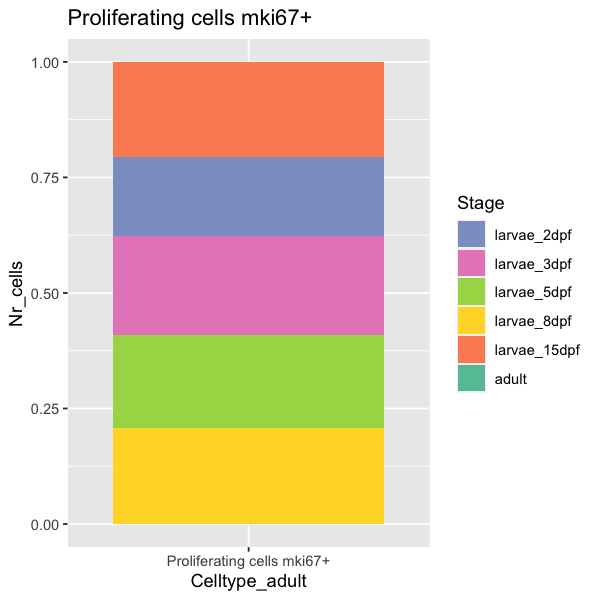

In [68]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Proliferating cells mki67+")

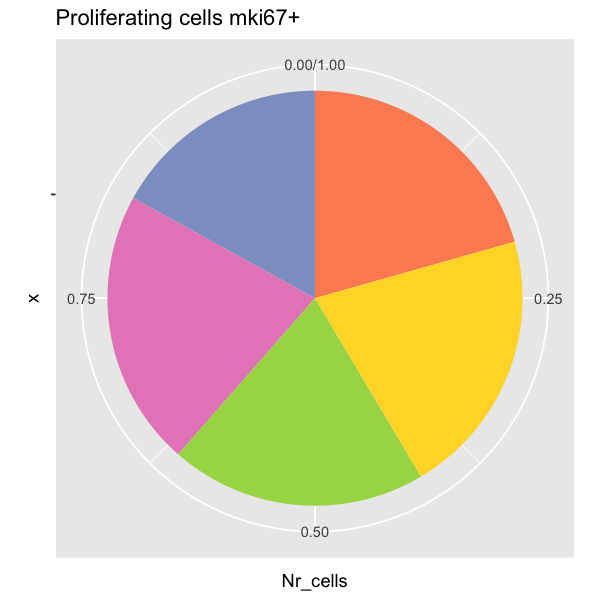

In [69]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Proliferating cells mki67+") +
    coord_polar("y", start=0) +
    NoLegend()

In [70]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_prol_mki67.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Prol mki67+") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia apof+ (mes)

In [71]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia apof+ (mes)"),]))
cumsum_vector

2           5           7           9          10          13 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         17          18          19          23          24          25 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         26          27          29          30           3          14 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0591716   0.1183432 
         15          21          22           0          28           8 
  0.1775148   0.2366864   0.4142012   0.7100592   1.0059172   1.4201184 
         12           4          20          11           1          16 
  1.8343195   2.4852071   3.6094675   5.0295858   6.8639053  36.3905326 
          6 
100.0000000

In [72]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia apof+ (mes)"),])
cutoff_0.1

[1] 10

In [73]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "16" "6"

In [74]:
sub_table <- stage.by.cluster[, sub_clusters]

In [75]:
sub_table

              
                       16          6
  larvae_15dpf 10.2228583 17.2766305
  larvae_2dpf   0.0000000  3.7059914
  larvae_3dpf   0.4880429 11.2249878
  larvae_5dpf   3.0120482 11.3788487
  larvae_8dpf   4.3051901 11.7196843

In [76]:
sub_rowsum <- rowSums(sub_table)

In [77]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
   27.499489     3.705991    11.713031    14.390897    16.024874

In [78]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia apof+ (mes)")
head(sub_df)

Stage        Nr_cells  Celltype_adult         
larvae_15dpf larvae_15dpf 27.499489 Radial glia apof+ (mes)
larvae_2dpf  larvae_2dpf   3.705991 Radial glia apof+ (mes)
larvae_3dpf  larvae_3dpf  11.713031 Radial glia apof+ (mes)
larvae_5dpf  larvae_5dpf  14.390897 Radial glia apof+ (mes)
larvae_8dpf  larvae_8dpf  16.024874 Radial glia apof+ (mes)

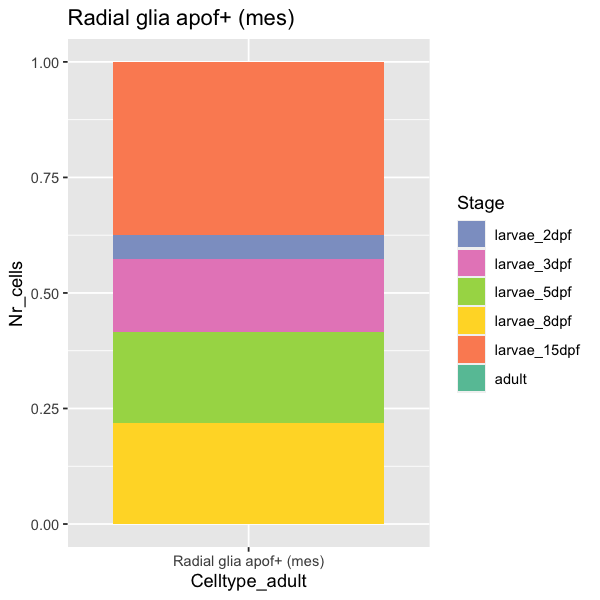

In [79]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia apof+ (mes)")

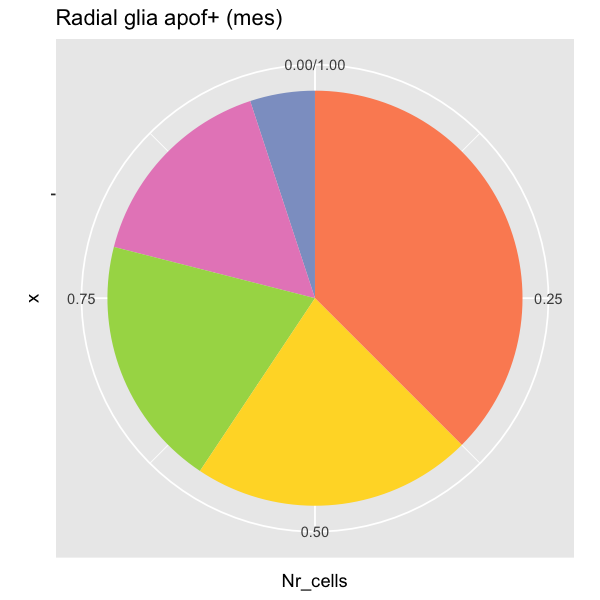

In [80]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia apof+ (mes)") +
    coord_polar("y", start=0) +
    NoLegend()

In [81]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_apof.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG apof+ (mes)") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia crabp1b+ (rhom)

In [82]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia crabp1b+ (rhom)"),]))
cumsum_vector

0           2           4           5           6           7 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
          9          12          16          17          18          20 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         24          27          29          30           3          10 
  0.0000000   0.0000000   0.0000000   0.0000000   0.2457003   0.4914005 
         11          21          25          23          28          14 
  0.7371007   0.9828010   1.2285013   1.9656020   2.7027027   3.9312040 
         22          26           8          19          15           1 
  5.1597052   6.6339067   8.5995086  12.5307126  16.7076167  26.0442261 
         13 
100.0000000

In [83]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia crabp1b+ (rhom)"),])
cutoff_0.1

[1] 10

In [84]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "19" "15" "1"  "13"

In [85]:
sub_table <- stage.by.cluster[, sub_clusters]

In [86]:
sub_table

              
                      19        15         1        13
  larvae_15dpf  6.849315 29.952975  3.680229 38.233490
  larvae_2dpf   0.000000  1.852996  1.235330 17.912291
  larvae_3dpf   4.880429 38.067350  1.952172 18.545632
  larvae_5dpf   7.028112 38.821954  2.677376 29.785810
  larvae_8dpf  10.045444 44.008610  2.391772 32.288926

In [87]:
sub_rowsum <- rowSums(sub_table)

In [88]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    78.71601     21.00062     63.44558     78.31325     88.73475

In [89]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia crabp1b+ (rhom)")
head(sub_df)

Stage        Nr_cells Celltype_adult             
larvae_15dpf larvae_15dpf 78.71601 Radial glia crabp1b+ (rhom)
larvae_2dpf  larvae_2dpf  21.00062 Radial glia crabp1b+ (rhom)
larvae_3dpf  larvae_3dpf  63.44558 Radial glia crabp1b+ (rhom)
larvae_5dpf  larvae_5dpf  78.31325 Radial glia crabp1b+ (rhom)
larvae_8dpf  larvae_8dpf  88.73475 Radial glia crabp1b+ (rhom)

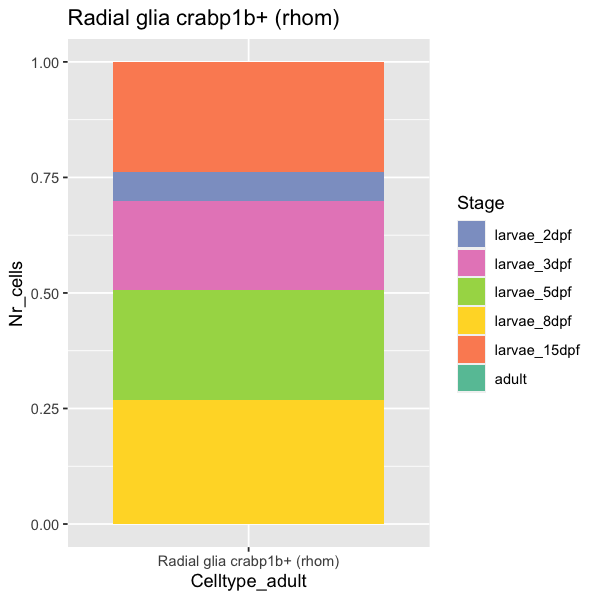

In [90]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia crabp1b+ (rhom)")

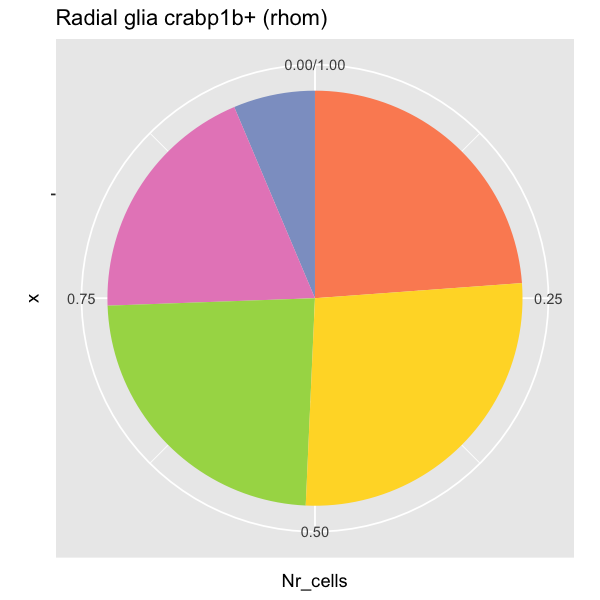

In [91]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia crabp1b+ (rhom)") +
    coord_polar("y", start=0) +
    NoLegend()

In [92]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_crabp1b.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG crabp1b+ (rhom)") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia enkur+

In [93]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia enkur+"),]))
cumsum_vector

2           3           7           8           9          18 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         19          21          25          26          30           0 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.1569859 
         14          22          10          16          24          27 
  0.3139717   0.4709576   0.7849293   1.0989011   1.4128728   1.7268446 
          6          13           5          17          29          20 
  2.1978022   2.6687598   3.4536891   4.3956044   5.3375196   6.4364207 
         12           4          11          28          15           1 
  7.8492936   9.4191523  11.4599686  14.2857143  19.1522763  38.4615384 
         23 
100.0000000

In [94]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia enkur+"),])
cutoff_0.1

[1] 10

In [95]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "11" "28" "15" "1"  "23"

In [96]:
sub_table <- stage.by.cluster[, sub_clusters]

In [97]:
sub_table

              
                       11         28         15          1         23
  larvae_15dpf 35.7800041  0.1022286 29.9529749  3.6802290  6.6448579
  larvae_2dpf   0.0000000  0.0000000  1.8529957  1.2353305  5.5589870
  larvae_3dpf   1.4641288  0.0000000 38.0673499  1.9521718  3.4163006
  larvae_5dpf  12.3828648  0.0000000 38.8219545  2.6773762  2.6773762
  larvae_8dpf  14.8289883  0.0000000 44.0086104  2.3917723  3.5876585

In [98]:
sub_rowsum <- rowSums(sub_table)

In [99]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
   76.160294     8.647313    44.899951    56.559572    64.817030

In [100]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia enkur+")
head(sub_df)

Stage        Nr_cells  Celltype_adult    
larvae_15dpf larvae_15dpf 76.160294 Radial glia enkur+
larvae_2dpf  larvae_2dpf   8.647313 Radial glia enkur+
larvae_3dpf  larvae_3dpf  44.899951 Radial glia enkur+
larvae_5dpf  larvae_5dpf  56.559572 Radial glia enkur+
larvae_8dpf  larvae_8dpf  64.817030 Radial glia enkur+

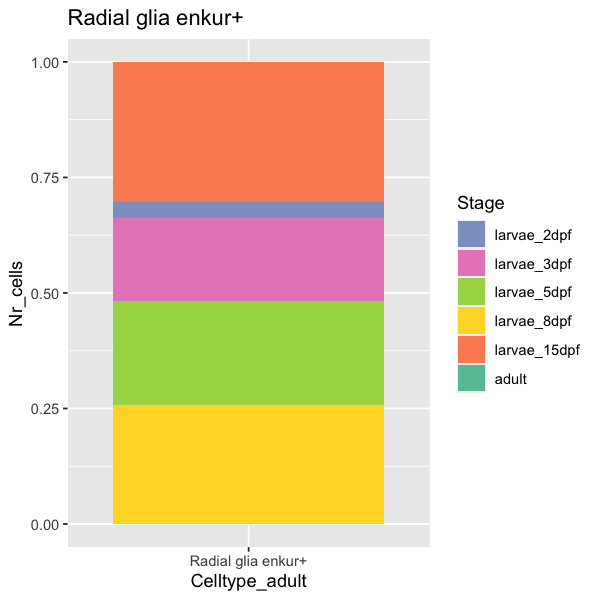

In [101]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia enkur+")

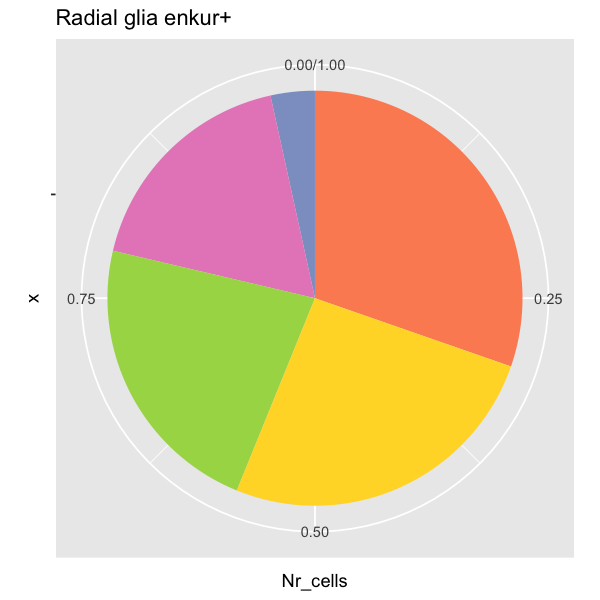

In [102]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia enkur+") +
    coord_polar("y", start=0) +
    NoLegend()

In [103]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_enkur.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG enkur+") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia foxn4+ (mes)

In [104]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia foxn4+ (mes)"),]))
cumsum_vector

3     7    16    21    25    27    29    30     4    17    23    26    12 
  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.2   0.4   0.6   0.8   1.2 
   18    19    20    24    10    13     2     5    11    15    22     6     0 
  1.6   2.0   2.4   2.8   3.4   4.0   4.8   5.6   6.4   7.2   8.0   9.2  10.8 
    9    28     1     8    14 
 12.4  15.0  21.8  30.2 100.0

In [105]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia foxn4+ (mes)"),])
cutoff_0.1

[1] 10

In [106]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "0"  "9"  "28" "1"  "8"  "14"

In [107]:
sub_table <- stage.by.cluster[, sub_clusters]

In [108]:
sub_table

              
                         0           9          28           1           8
  larvae_15dpf 119.0962993  60.0081783   0.1022286   3.6802290  62.5638929
  larvae_2dpf  169.2402718  82.1494750   0.0000000   1.2353305  96.9734404
  larvae_3dpf   90.7759883  73.2064422   0.0000000   1.9521718  94.6803319
  larvae_5dpf   65.9303882  61.2449799   0.0000000   2.6773762  52.8781794
  larvae_8dpf  111.2174121  81.7986128   0.0000000   2.3917723  88.7347525
              
                        14
  larvae_15dpf  31.8953179
  larvae_2dpf   40.7659049
  larvae_3dpf   37.0912640
  larvae_5dpf   35.4752343
  larvae_8dpf   41.6168381

In [109]:
sub_rowsum <- rowSums(sub_table)

In [110]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    277.3461     390.3644     297.7062     218.2062     325.7594

In [111]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia foxn4+ (mes)")
head(sub_df)

Stage        Nr_cells Celltype_adult          
larvae_15dpf larvae_15dpf 277.3461 Radial glia foxn4+ (mes)
larvae_2dpf  larvae_2dpf  390.3644 Radial glia foxn4+ (mes)
larvae_3dpf  larvae_3dpf  297.7062 Radial glia foxn4+ (mes)
larvae_5dpf  larvae_5dpf  218.2062 Radial glia foxn4+ (mes)
larvae_8dpf  larvae_8dpf  325.7594 Radial glia foxn4+ (mes)

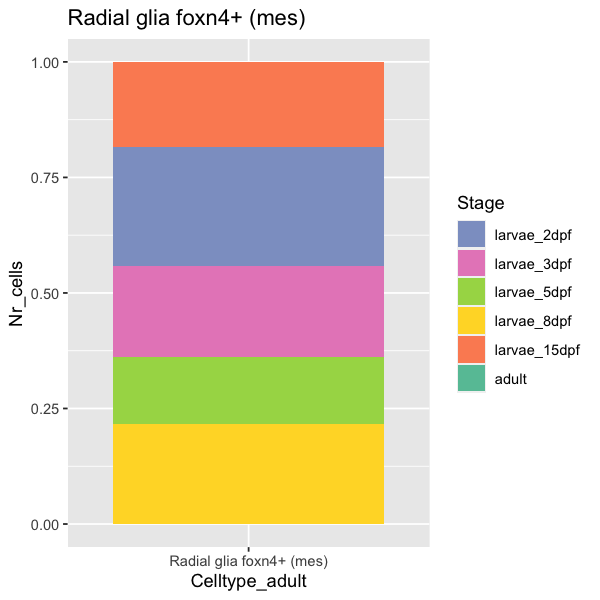

In [112]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia foxn4+ (mes)")

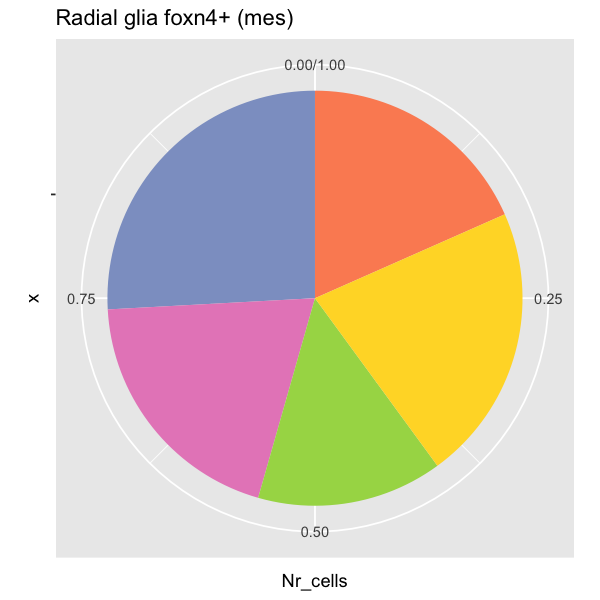

In [113]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia foxn4+ (mes)") +
    coord_polar("y", start=0) +
    NoLegend()

In [114]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_foxn4.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG foxn4+ (mes)") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia gfap++

Manually rename to her4++ in line with new nomenclature

In [115]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia gfap++"),]))
cumsum_vector

7          11          12          16          18          19 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         20          23          24          25          28          29 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         30           3          15          22          26           6 
  0.0000000   0.1587302   0.3174603   0.4761905   0.6349206   0.9523810 
         21          13           5          17           8          27 
  1.2698413   1.7460318   2.3809524   3.0158730   3.8095238   4.6031746 
          2          14           9           4           1           0 
  5.5555556   6.5079365  10.4761905  16.1904762  31.9047619  49.2063492 
         10 
100.0000000

In [116]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia gfap++"),])
cutoff_0.1

[1] 10

In [117]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "9"  "4"  "1"  "0"  "10"

In [118]:
sub_table <- stage.by.cluster[, sub_clusters]

In [119]:
sub_table

              
                        9          4          1          0         10
  larvae_15dpf  60.008178  31.077489   3.680229 119.096299  48.558577
  larvae_2dpf   82.149475  30.883261   1.235330 169.240272 175.416924
  larvae_3dpf   73.206442  19.033675   1.952172  90.775988  40.995608
  larvae_5dpf   61.244980  26.104418   2.677376  65.930388  40.160643
  larvae_8dpf   81.798613  23.200191   2.391772 111.217412  46.161205

In [120]:
sub_rowsum <- rowSums(sub_table)

In [121]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    262.4208     458.9253     225.9639     196.1178     264.7692

In [122]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia gfap++")
head(sub_df)

Stage        Nr_cells Celltype_adult    
larvae_15dpf larvae_15dpf 262.4208 Radial glia gfap++
larvae_2dpf  larvae_2dpf  458.9253 Radial glia gfap++
larvae_3dpf  larvae_3dpf  225.9639 Radial glia gfap++
larvae_5dpf  larvae_5dpf  196.1178 Radial glia gfap++
larvae_8dpf  larvae_8dpf  264.7692 Radial glia gfap++

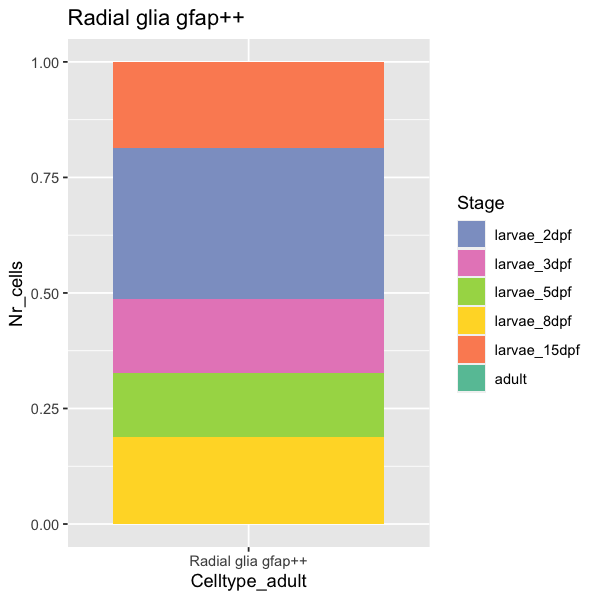

In [123]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia gfap++")

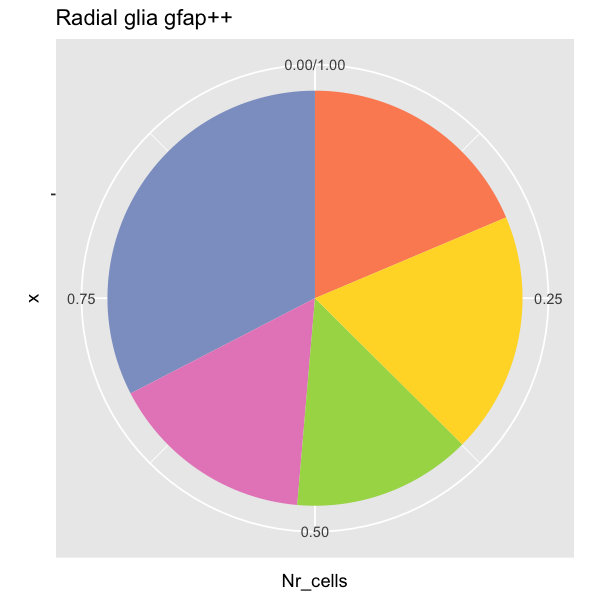

In [124]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia gfap++") +
    coord_polar("y", start=0) +
    NoLegend()

In [125]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_her4.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG her4++") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia id2b+

In [126]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia id2b+"),]))
cumsum_vector

0           2           3           7          18          21 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         30          25          26          29           5           8 
  0.0000000   0.0755287   0.1510574   0.2265861   0.3398792   0.4531722 
         23          16          13          15          24          19 
  0.6419940   0.9063444   1.2839879   1.6616314   2.1903323   2.7567976 
         17           9          20          22          14          12 
  3.5876133   4.6827794   5.7779456   6.9864048   8.4592145  10.0075528 
         10          28          11           6          27           1 
 12.3489426  14.8791541  19.2598187  25.6419939  33.8368580  63.7462236 
          4 
100.0000000

In [127]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia id2b+"),])
cutoff_0.1

[1] 10

In [128]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "12" "10" "28" "11" "6"  "27" "1"  "4"

In [129]:
sub_table <- stage.by.cluster[, sub_clusters]

In [130]:
sub_table

              
                        12          10          28          11           6
  larvae_15dpf  16.6632590  48.5585770   0.1022286  35.7800041  17.2766305
  larvae_2dpf   46.9425571 175.4169240   0.0000000   0.0000000   3.7059914
  larvae_3dpf   48.8042948  40.9956076   0.0000000   1.4641288  11.2249878
  larvae_5dpf   53.5475234  40.1606426   0.0000000  12.3828648  11.3788487
  larvae_8dpf   23.4393686  46.1612055   0.0000000  14.8289883  11.7196843
              
                        27           1           4
  larvae_15dpf   0.0000000   3.6802290  31.0774893
  larvae_2dpf    0.0000000   1.2353305  30.8832613
  larvae_3dpf    0.0000000   1.9521718  19.0336750
  larvae_5dpf    0.0000000   2.6773762  26.1044177
  larvae_8dpf    0.2391772   2.3917723  23.2001913

In [131]:
sub_rowsum <- rowSums(sub_table)

In [132]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    153.1384     258.1841     123.4749     146.2517     121.9804

In [133]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia id2b+")
head(sub_df)

Stage        Nr_cells Celltype_adult   
larvae_15dpf larvae_15dpf 153.1384 Radial glia id2b+
larvae_2dpf  larvae_2dpf  258.1841 Radial glia id2b+
larvae_3dpf  larvae_3dpf  123.4749 Radial glia id2b+
larvae_5dpf  larvae_5dpf  146.2517 Radial glia id2b+
larvae_8dpf  larvae_8dpf  121.9804 Radial glia id2b+

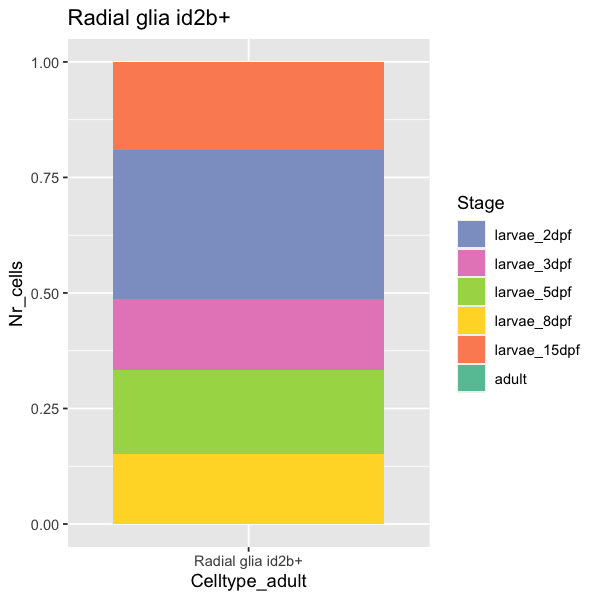

In [134]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia id2b+")

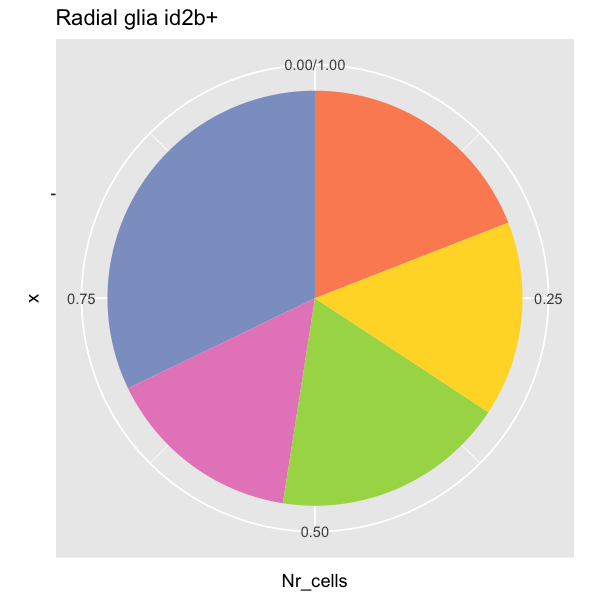

In [135]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia id2b+") +
    coord_polar("y", start=0) +
    NoLegend()

In [136]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_id2b.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG id2b+") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia id3+ (dien)

In [137]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia id3+ (dien)"),]))
cumsum_vector

0           3           6           7           8          13 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         16          18          19          26          27          29 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         30           2          21          22          24          12 
  0.0000000   0.1342282   0.2684564   0.4026846   0.5369128   0.8053691 
         20          23           5          15          25          10 
  1.0738255   1.4765101   2.1476510   2.9530201   3.8926175   5.1006712 
         14           9          11           4          28           1 
  6.7114094   8.7248322  10.7382551  20.4026846  30.0671141  44.8322148 
         17 
100.0000000

In [138]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia id3+ (dien)"),])
cutoff_0.1

[1] 10

In [139]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "11" "4"  "28" "1"  "17"

In [140]:
sub_table <- stage.by.cluster[, sub_clusters]

In [141]:
sub_table

              
                       11          4         28          1         17
  larvae_15dpf 35.7800041 31.0774893  0.1022286  3.6802290 29.0329176
  larvae_2dpf   0.0000000 30.8832613  0.0000000  1.2353305 12.3533045
  larvae_3dpf   1.4641288 19.0336750  0.0000000  1.9521718 12.6891166
  larvae_5dpf  12.3828648 26.1044177  0.0000000  2.6773762 30.7898260
  larvae_8dpf  14.8289883 23.2001913  0.0000000  2.3917723 19.8517101

In [142]:
sub_rowsum <- rowSums(sub_table)

In [143]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    99.67287     44.47190     35.13909     71.95448     60.27266

In [144]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia id3+ (dien)")
head(sub_df)

Stage        Nr_cells Celltype_adult         
larvae_15dpf larvae_15dpf 99.67287 Radial glia id3+ (dien)
larvae_2dpf  larvae_2dpf  44.47190 Radial glia id3+ (dien)
larvae_3dpf  larvae_3dpf  35.13909 Radial glia id3+ (dien)
larvae_5dpf  larvae_5dpf  71.95448 Radial glia id3+ (dien)
larvae_8dpf  larvae_8dpf  60.27266 Radial glia id3+ (dien)

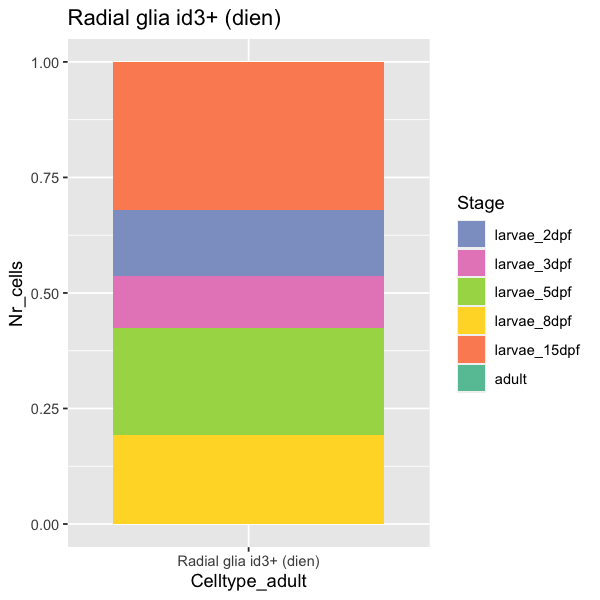

In [145]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia id3+ (dien)")

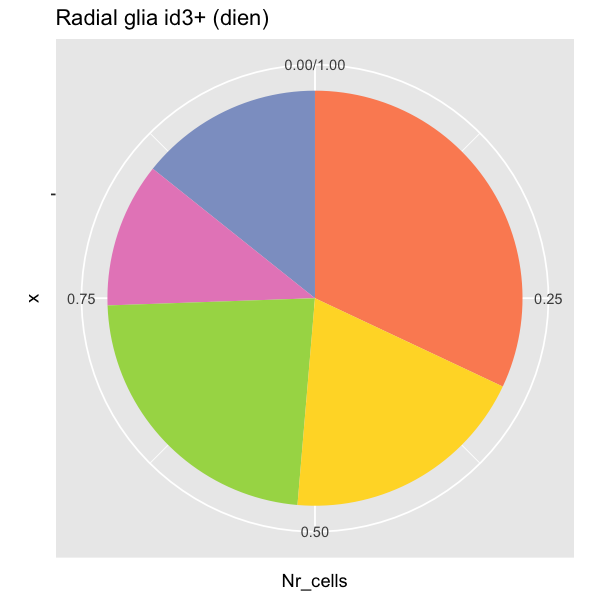

In [146]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia id3+ (dien)") +
    coord_polar("y", start=0) +
    NoLegend()

In [147]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_id3.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG id3+ (dien)") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia nppc+

In [148]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia nppc+"),]))
cumsum_vector

0            2            3            7            9           17 
  0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000 
          18           19           21           24           25           26 
  0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000 
          10           14           29            5            8           27 
  0.08658009   0.17316018   0.25974027   0.43290044   0.60606061   0.77922078 
          28           15           13           30           23           20 
  0.95238095   1.21212121   1.64502164   2.07792207   2.59740259   3.54978354 
           6           16           22            4            1           11 
  4.67532467   5.80086580   9.95670996  14.28571429  20.77922078  47.96536797 
          12 
100.00000000

In [149]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia nppc+"),])
cutoff_0.1

[1] 10

In [150]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "4"  "1"  "11" "12"

In [151]:
sub_table <- stage.by.cluster[, sub_clusters]

In [152]:
sub_table

              
                       4         1        11        12
  larvae_15dpf 31.077489  3.680229 35.780004 16.663259
  larvae_2dpf  30.883261  1.235330  0.000000 46.942557
  larvae_3dpf  19.033675  1.952172  1.464129 48.804295
  larvae_5dpf  26.104418  2.677376 12.382865 53.547523
  larvae_8dpf  23.200191  2.391772 14.828988 23.439369

In [153]:
sub_rowsum <- rowSums(sub_table)

In [154]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    87.20098     79.06115     71.25427     94.71218     63.86032

In [155]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia nppc+")
head(sub_df)

Stage        Nr_cells Celltype_adult   
larvae_15dpf larvae_15dpf 87.20098 Radial glia nppc+
larvae_2dpf  larvae_2dpf  79.06115 Radial glia nppc+
larvae_3dpf  larvae_3dpf  71.25427 Radial glia nppc+
larvae_5dpf  larvae_5dpf  94.71218 Radial glia nppc+
larvae_8dpf  larvae_8dpf  63.86032 Radial glia nppc+

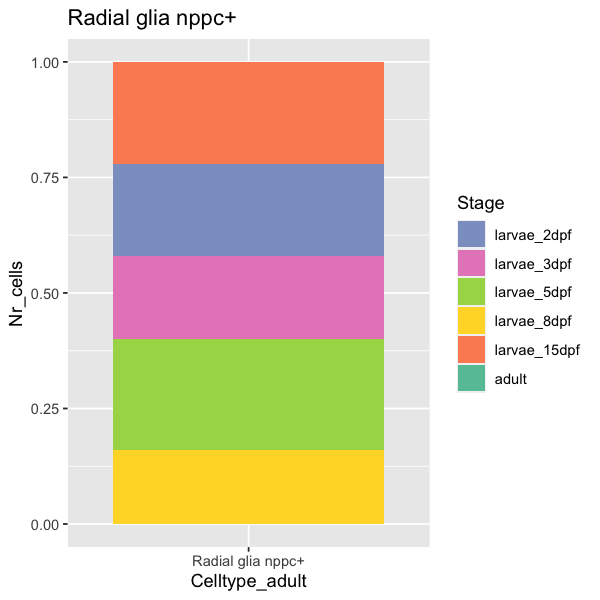

In [156]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia nppc+")

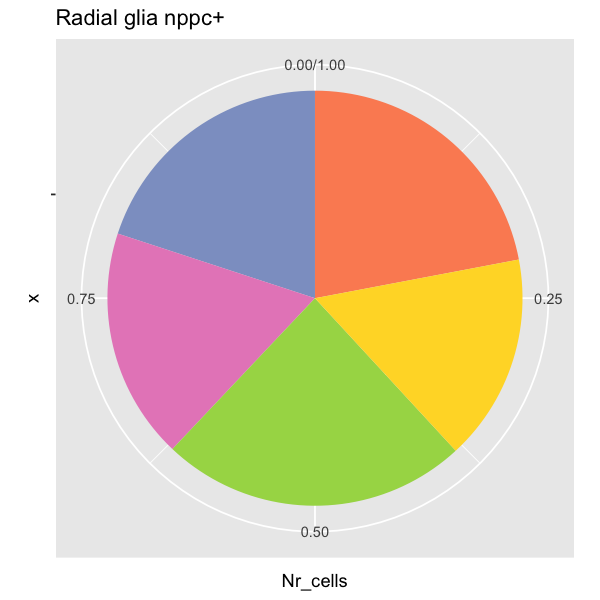

In [157]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia nppc+") +
    coord_polar("y", start=0) +
    NoLegend()

In [158]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_nppc.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG nppc+") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia nrg1+ (rhom)

In [159]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia nrg1+ (rhom)"),]))
cumsum_vector

0           2           3           5           7           8 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
          9          10          15          16          17          18 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         21          25          26          27          28          29 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         30          14          19          23          24          13 
  0.0000000   0.2604167   0.5208333   0.7812500   1.0416667   1.8229167 
         20           6          11          12           4           1 
  2.6041667   3.6458334   5.2083334  10.9375000  17.9687500  31.5104167 
         22 
100.0000000

In [160]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia nrg1+ (rhom)"),])
cutoff_0.1

[1] 10

In [161]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "12" "4"  "1"  "22"

In [162]:
sub_table <- stage.by.cluster[, sub_clusters]

In [163]:
sub_table

              
                      12         4         1        22
  larvae_15dpf 16.663259 31.077489  3.680229 12.778573
  larvae_2dpf  46.942557 30.883261  1.235330 23.471279
  larvae_3dpf  48.804295 19.033675  1.952172 19.521718
  larvae_5dpf  53.547523 26.104418  2.677376 16.398929
  larvae_8dpf  23.439369 23.200191  2.391772 12.198039

In [164]:
sub_rowsum <- rowSums(sub_table)

In [165]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    64.19955    102.53243     89.31186     98.72825     61.22937

In [166]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia nrg1+ (rhom)")
head(sub_df)

Stage        Nr_cells  Celltype_adult          
larvae_15dpf larvae_15dpf  64.19955 Radial glia nrg1+ (rhom)
larvae_2dpf  larvae_2dpf  102.53243 Radial glia nrg1+ (rhom)
larvae_3dpf  larvae_3dpf   89.31186 Radial glia nrg1+ (rhom)
larvae_5dpf  larvae_5dpf   98.72825 Radial glia nrg1+ (rhom)
larvae_8dpf  larvae_8dpf   61.22937 Radial glia nrg1+ (rhom)

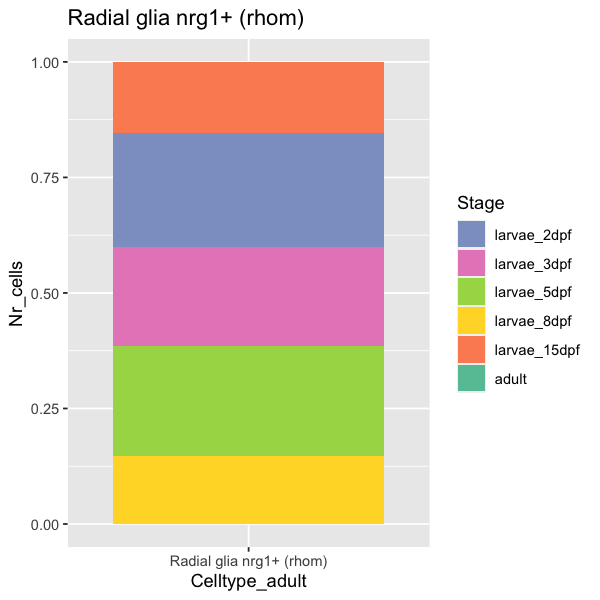

In [167]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia nrg1+ (rhom)")

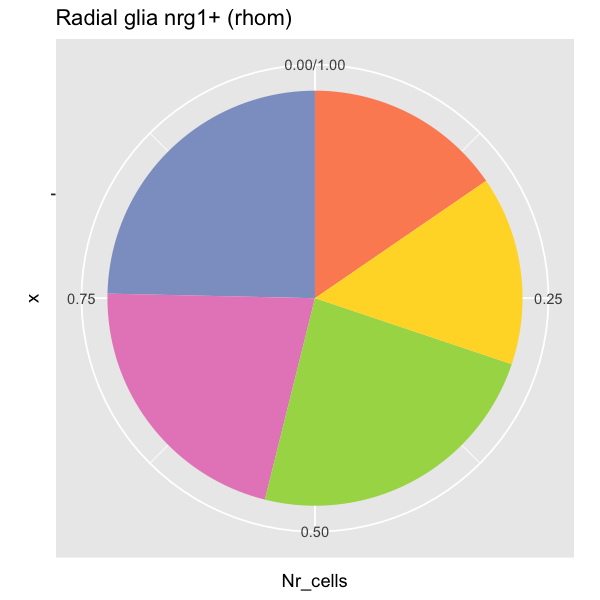

In [168]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia nrg1+ (rhom)") +
    coord_polar("y", start=0) +
    NoLegend()

In [169]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_nrg1.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG nrg1+ (rhom)") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia ntn1b+ (dien)

In [170]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia ntn1b+ (dien)"),]))
cumsum_vector

0           3           7           8          13          15 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         16          18          21          22          23          24 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         25          26          30           5           6          20 
  0.0000000   0.0000000   0.0000000   0.2590674   0.5181347   0.7772021 
         27          28          29           2          10          14 
  1.0362694   1.2953368   1.5544042   2.0725389   2.5906736   3.1088083 
         19           9          12          11           1          17 
  3.6269430   4.4041451   6.4766840  12.6943006  30.3108809  53.8860104 
          4 
100.0000000

In [171]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia ntn1b+ (dien)"),])
cutoff_0.1

[1] 10

In [172]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "11" "1"  "17" "4"

In [173]:
sub_table <- stage.by.cluster[, sub_clusters]

In [174]:
sub_table

              
                      11         1        17         4
  larvae_15dpf 35.780004  3.680229 29.032918 31.077489
  larvae_2dpf   0.000000  1.235330 12.353305 30.883261
  larvae_3dpf   1.464129  1.952172 12.689117 19.033675
  larvae_5dpf  12.382865  2.677376 30.789826 26.104418
  larvae_8dpf  14.828988  2.391772 19.851710 23.200191

In [175]:
sub_rowsum <- rowSums(sub_table)

In [176]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    99.57064     44.47190     35.13909     71.95448     60.27266

In [177]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia ntn1b+ (dien)")
head(sub_df)

Stage        Nr_cells Celltype_adult           
larvae_15dpf larvae_15dpf 99.57064 Radial glia ntn1b+ (dien)
larvae_2dpf  larvae_2dpf  44.47190 Radial glia ntn1b+ (dien)
larvae_3dpf  larvae_3dpf  35.13909 Radial glia ntn1b+ (dien)
larvae_5dpf  larvae_5dpf  71.95448 Radial glia ntn1b+ (dien)
larvae_8dpf  larvae_8dpf  60.27266 Radial glia ntn1b+ (dien)

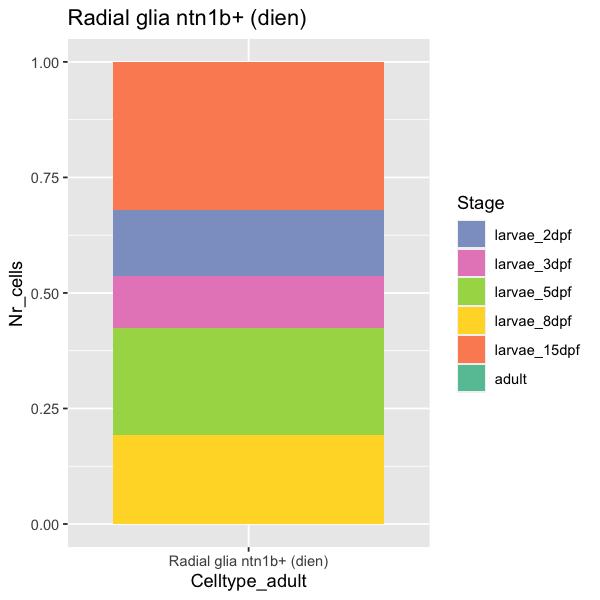

In [178]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia ntn1b+ (dien)")

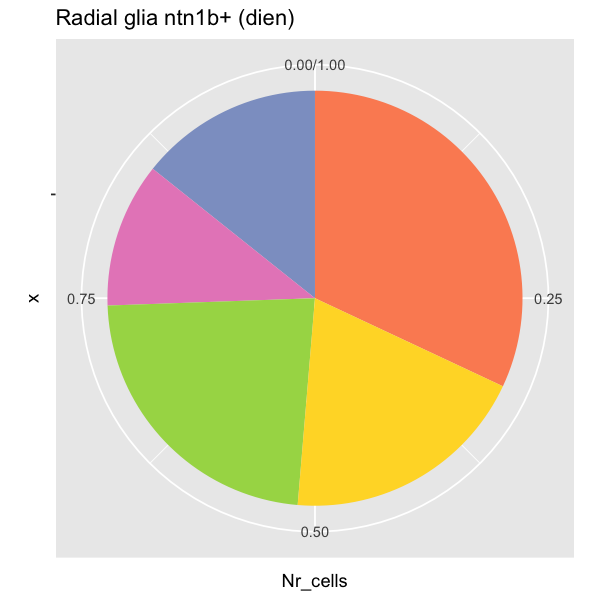

In [179]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia ntn1b+ (dien)") +
    coord_polar("y", start=0) +
    NoLegend()

In [180]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_ntn1b.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG ntn1b+") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia prss35+ (rhom)

In [181]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia prss35+ (rhom)"),]))
cumsum_vector

2           3           7           8           9          10 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         11          12          16          17          18          23 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         24          25          26          27          29          30 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
          6          14          28           4          15          21 
  0.1136364   0.2272727   0.3409091   0.6818182   1.0227273   1.3636363 
          5          20           0          22          13           1 
  1.9318182   2.5000000   3.2954545   4.6590909   6.2500000  14.5454545 
         19 
100.0000000

In [182]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia prss35+ (rhom)"),])
cutoff_0.1

[1] 10

In [183]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "1"  "19"

In [184]:
sub_table <- stage.by.cluster[, sub_clusters]

In [185]:
sub_table

              
                       1        19
  larvae_15dpf  3.680229  6.849315
  larvae_2dpf   1.235330  0.000000
  larvae_3dpf   1.952172  4.880429
  larvae_5dpf   2.677376  7.028112
  larvae_8dpf   2.391772 10.045444

In [186]:
sub_rowsum <- rowSums(sub_table)

In [187]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
   10.529544     1.235330     6.832601     9.705489    12.437216

In [188]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia prss35+ (rhom)")
head(sub_df)

Stage        Nr_cells  Celltype_adult            
larvae_15dpf larvae_15dpf 10.529544 Radial glia prss35+ (rhom)
larvae_2dpf  larvae_2dpf   1.235330 Radial glia prss35+ (rhom)
larvae_3dpf  larvae_3dpf   6.832601 Radial glia prss35+ (rhom)
larvae_5dpf  larvae_5dpf   9.705489 Radial glia prss35+ (rhom)
larvae_8dpf  larvae_8dpf  12.437216 Radial glia prss35+ (rhom)

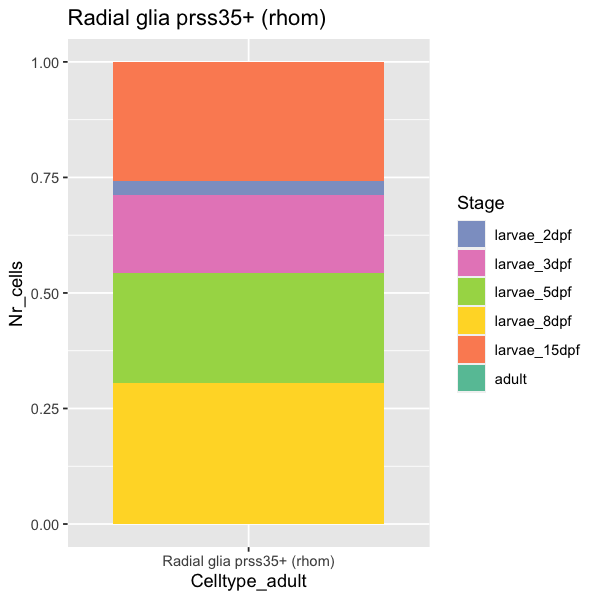

In [189]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia prss35+ (rhom)")

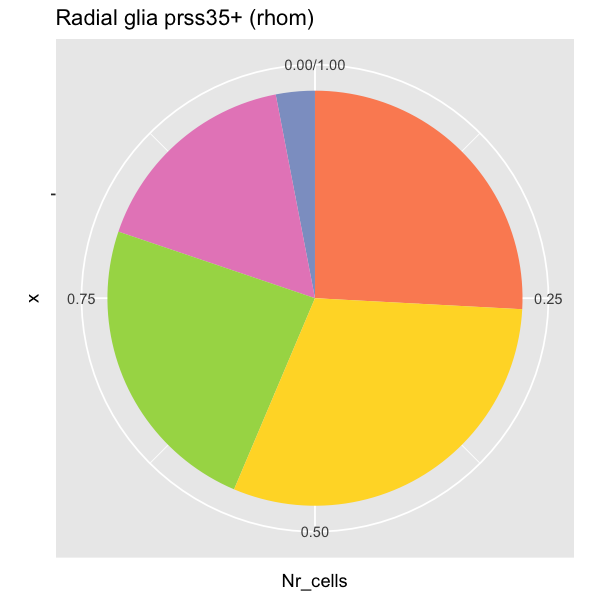

In [190]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia prss35+ (rhom)") +
    coord_polar("y", start=0) +
    NoLegend()

In [191]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_prss35.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG prss35+ (rhom)") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia RP high(rhom)

In [192]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia RP high(rhom)"),]))
cumsum_vector

7          17          18          19          20          22 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         23          24          25          26          27          28 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         29          30           2           6          16          12 
  0.0000000   0.0000000   0.4310345   0.8620690   1.2931034   2.1551724 
          8           9          10           0          13           5 
  3.4482759   4.7413793   6.0344828   7.7586207   9.9137931  12.5000000 
          4          11          14          21           1           3 
 15.5172414  18.5344828  21.5517241  25.4310345  30.6034483  44.3965517 
         15 
100.0000000

In [193]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia RP high(rhom)"),])
cutoff_0.1

[1] 10

In [194]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "5"  "4"  "11" "14" "21" "1"  "3"  "15"

In [195]:
sub_table <- stage.by.cluster[, sub_clusters]

In [196]:
sub_table

              
                        5          4         11         14         21
  larvae_15dpf  80.760581  31.077489  35.780004  31.895318  29.748518
  larvae_2dpf    8.647313  30.883261   0.000000  40.765905   3.705991
  larvae_3dpf   56.612982  19.033675   1.464129  37.091264  50.268424
  larvae_5dpf  137.884873  26.104418  12.382865  35.475234  26.104418
  larvae_8dpf   59.555130  23.200191  14.828988  41.616838  44.247788
              
                        1          3         15
  larvae_15dpf   3.680229  84.645267  29.952975
  larvae_2dpf    1.235330  16.059296   1.852996
  larvae_3dpf    1.952172 106.881406  38.067350
  larvae_5dpf    2.677376 136.546185  38.821954
  larvae_8dpf    2.391772 103.802918  44.008610

In [197]:
sub_rowsum <- rowSums(sub_table)

In [198]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    327.5404     103.1501     311.3714     415.9973     333.6522

In [199]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia RP high(rhom)")
head(sub_df)

Stage        Nr_cells Celltype_adult           
larvae_15dpf larvae_15dpf 327.5404 Radial glia RP high(rhom)
larvae_2dpf  larvae_2dpf  103.1501 Radial glia RP high(rhom)
larvae_3dpf  larvae_3dpf  311.3714 Radial glia RP high(rhom)
larvae_5dpf  larvae_5dpf  415.9973 Radial glia RP high(rhom)
larvae_8dpf  larvae_8dpf  333.6522 Radial glia RP high(rhom)

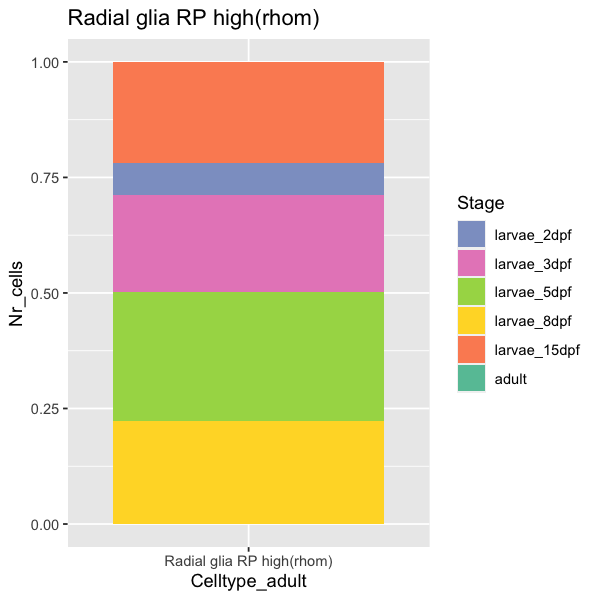

In [200]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia RP high(rhom)")

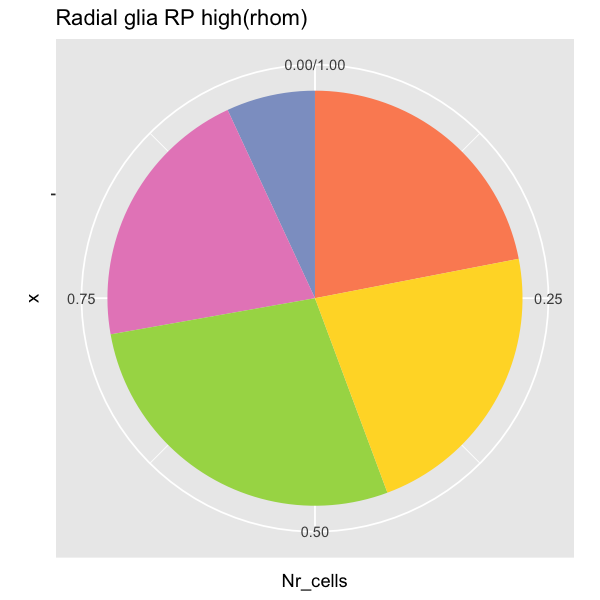

In [201]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia RP high(rhom)") +
    coord_polar("y", start=0) +
    NoLegend()

In [202]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_rp.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG RP high (rhom)") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia snap25a+

In [203]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia snap25a+"),]))
cumsum_vector

7           18           30            2            8           23 
  0.00000000   0.00000000   0.00000000   0.03144654   0.06289308   0.09433962 
          25           29            9           14           22           13 
  0.12578616   0.15723270   0.31446540   0.47169810   0.62893080   0.97484275 
          26           24            0           17           27           12 
  1.38364778   1.82389935   2.29559746   2.83018865   3.36477984   3.93081758 
          28           19           10            3           21            4 
  4.62264148   5.59748425   6.63522010   7.73584903   9.40251570  11.28930815 
           5            6           15           11           16            1 
 15.15723268  19.33962262  27.98742136  37.95597482  50.88050312  75.31446538 
          20 
 99.99999997

In [204]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia snap25a+"),])
cutoff_0.1

[1] 10

In [205]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "4"  "5"  "6"  "15" "11" "16" "1"  "20"

In [206]:
sub_table <- stage.by.cluster[, sub_clusters]

In [207]:
sub_table

              
                         4           5           6          15          11
  larvae_15dpf  31.0774893  80.7605807  17.2766305  29.9529749  35.7800041
  larvae_2dpf   30.8832613   8.6473132   3.7059914   1.8529957   0.0000000
  larvae_3dpf   19.0336750  56.6129819  11.2249878  38.0673499   1.4641288
  larvae_5dpf   26.1044177 137.8848728  11.3788487  38.8219545  12.3828648
  larvae_8dpf   23.2001913  59.5551304  11.7196843  44.0086104  14.8289883
              
                        16           1          20
  larvae_15dpf  10.2228583   3.6802290   2.1468002
  larvae_2dpf    0.0000000   1.2353305   0.0000000
  larvae_3dpf    0.4880429   1.9521718   1.4641288
  larvae_5dpf    3.0120482   2.6773762   1.6733601
  larvae_8dpf    4.3051901   2.3917723   0.2391772

In [208]:
sub_rowsum <- rowSums(sub_table)

In [209]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
   210.89757     46.32489    130.30747    233.93574    160.24874

In [210]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia snap25a+")
head(sub_df)

Stage        Nr_cells  Celltype_adult      
larvae_15dpf larvae_15dpf 210.89757 Radial glia snap25a+
larvae_2dpf  larvae_2dpf   46.32489 Radial glia snap25a+
larvae_3dpf  larvae_3dpf  130.30747 Radial glia snap25a+
larvae_5dpf  larvae_5dpf  233.93574 Radial glia snap25a+
larvae_8dpf  larvae_8dpf  160.24874 Radial glia snap25a+

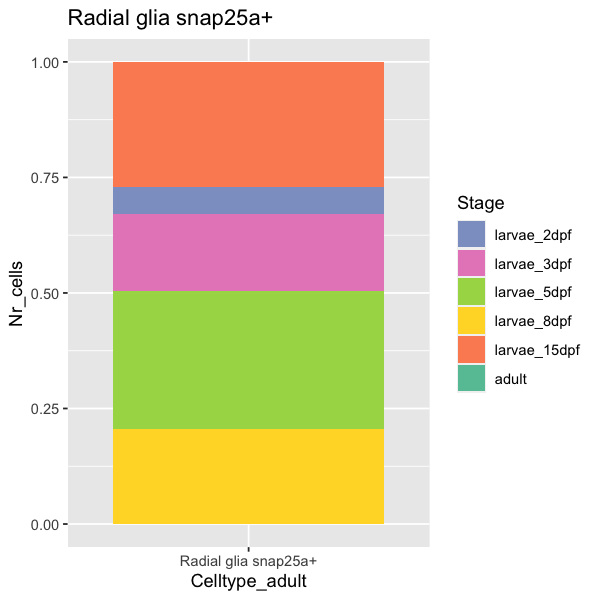

In [211]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia snap25a+")

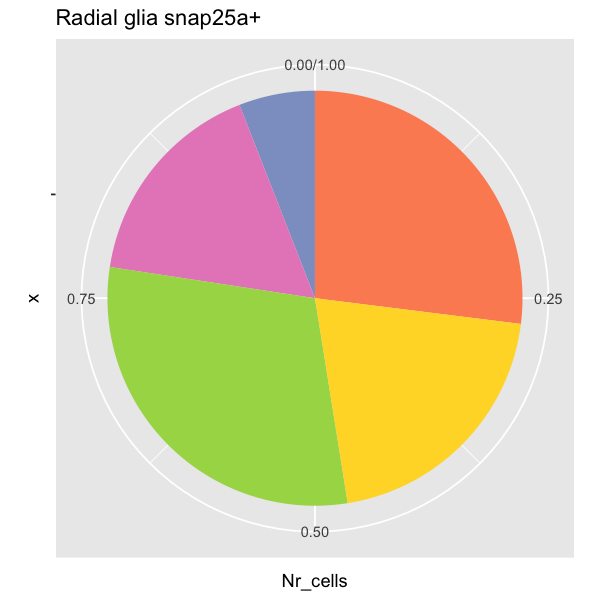

In [212]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia snap25a+") +
    coord_polar("y", start=0) +
    NoLegend()

In [213]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_snap25a.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG snap25a+") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia stat2+

In [214]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia stat2+"),]))
cumsum_vector

0           2           3           7           8           9 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         10          13          14          18          19          21 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000 
         24          25          26          29          30           5 
  0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   0.7194245 
         12          17          22          23          27          28 
  1.4388489   2.1582734   2.8776978   3.5971223   4.3165468   5.0359712 
          1          15          20           6          16          11 
  7.9136691  11.5107914  18.7050360  31.6546762  47.4820144  69.7841727 
          4 
100.0000000

In [215]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia stat2+"),])
cutoff_0.1

[1] 10

In [216]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "15" "20" "6"  "16" "11" "4"

In [217]:
sub_table <- stage.by.cluster[, sub_clusters]

In [218]:
sub_table

              
                       15         20          6         16         11
  larvae_15dpf 29.9529749  2.1468002 17.2766305 10.2228583 35.7800041
  larvae_2dpf   1.8529957  0.0000000  3.7059914  0.0000000  0.0000000
  larvae_3dpf  38.0673499  1.4641288 11.2249878  0.4880429  1.4641288
  larvae_5dpf  38.8219545  1.6733601 11.3788487  3.0120482 12.3828648
  larvae_8dpf  44.0086104  0.2391772 11.7196843  4.3051901 14.8289883
              
                        4
  larvae_15dpf 31.0774893
  larvae_2dpf  30.8832613
  larvae_3dpf  19.0336750
  larvae_5dpf  26.1044177
  larvae_8dpf  23.2001913

In [219]:
sub_rowsum <- rowSums(sub_table)

In [220]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
   126.45676     36.44225     71.74231     93.37349     98.30184

In [221]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia stat2+")
head(sub_df)

Stage        Nr_cells  Celltype_adult    
larvae_15dpf larvae_15dpf 126.45676 Radial glia stat2+
larvae_2dpf  larvae_2dpf   36.44225 Radial glia stat2+
larvae_3dpf  larvae_3dpf   71.74231 Radial glia stat2+
larvae_5dpf  larvae_5dpf   93.37349 Radial glia stat2+
larvae_8dpf  larvae_8dpf   98.30184 Radial glia stat2+

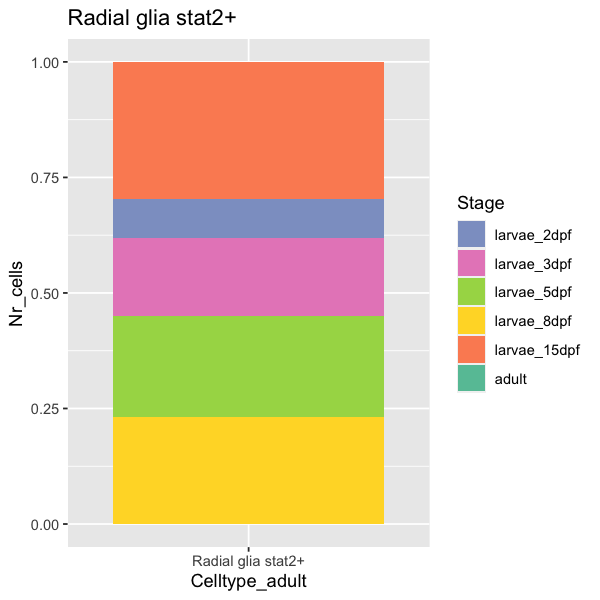

In [222]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia stat2+")

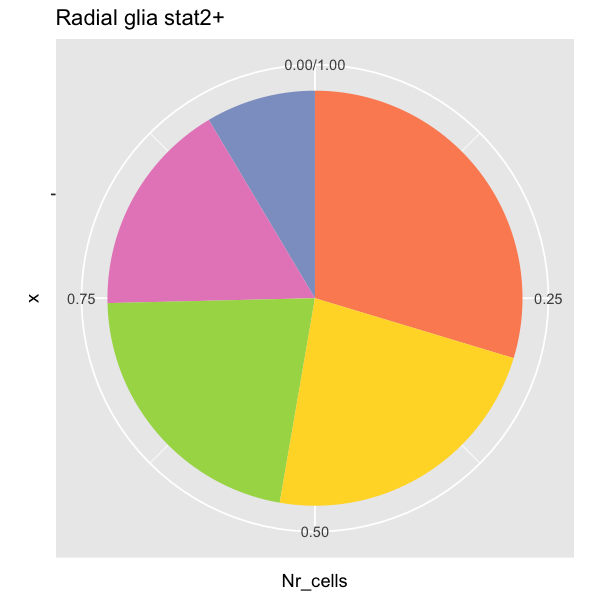

In [223]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia stat2+") +
    coord_polar("y", start=0) +
    NoLegend()

In [224]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_stat2.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG stat2+") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)

##### Radial glia stra6+ (mes)

In [225]:
cumsum_vector <- cumsum(sort(celltype_ad.by.cluster[c("Radial glia stra6+ (mes)"),]))
cumsum_vector

0          2          3          5          7          8          9 
  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000 
        13         15         17         18         19         21         22 
  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000 
        23         24         25         26         27         29         30 
  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000 
        10         11         28          4         12         16         20 
  1.333333   2.666667   4.000000   6.666667   9.333333  13.333333  20.000000 
        14          1          6 
 28.000000  37.333333 100.000000

In [226]:
cutoff_0.1 <- 0.1*sum(celltype_ad.by.cluster[c("Radial glia stra6+ (mes)"),])
cutoff_0.1

[1] 10

In [227]:
# pick all clusters in which 90% of the cells are
# (ie exclude clusters which have cumsum values below the 10% cutoff)
sub_clusters <- names(cumsum_vector[which(cumsum_vector > cutoff_0.1)])
sub_clusters

[1] "16" "20" "14" "1"  "6"

In [228]:
sub_table <- stage.by.cluster[, sub_clusters]

In [229]:
sub_table

              
                       16         20         14          1          6
  larvae_15dpf 10.2228583  2.1468002 31.8953179  3.6802290 17.2766305
  larvae_2dpf   0.0000000  0.0000000 40.7659049  1.2353305  3.7059914
  larvae_3dpf   0.4880429  1.4641288 37.0912640  1.9521718 11.2249878
  larvae_5dpf   3.0120482  1.6733601 35.4752343  2.6773762 11.3788487
  larvae_8dpf   4.3051901  0.2391772 41.6168381  2.3917723 11.7196843

In [230]:
sub_rowsum <- rowSums(sub_table)

In [231]:
sub_rowsum

larvae_15dpf  larvae_2dpf  larvae_3dpf  larvae_5dpf  larvae_8dpf 
    65.22184     45.70723     52.22060     54.21687     60.27266

In [232]:
sub_df <- data.frame("Stage" = names(sub_rowsum),
                       "Nr_cells" = sub_rowsum,
                       "Celltype_adult" = "Radial glia stra6+ (mes)")
head(sub_df)

Stage        Nr_cells Celltype_adult          
larvae_15dpf larvae_15dpf 65.22184 Radial glia stra6+ (mes)
larvae_2dpf  larvae_2dpf  45.70723 Radial glia stra6+ (mes)
larvae_3dpf  larvae_3dpf  52.22060 Radial glia stra6+ (mes)
larvae_5dpf  larvae_5dpf  54.21687 Radial glia stra6+ (mes)
larvae_8dpf  larvae_8dpf  60.27266 Radial glia stra6+ (mes)

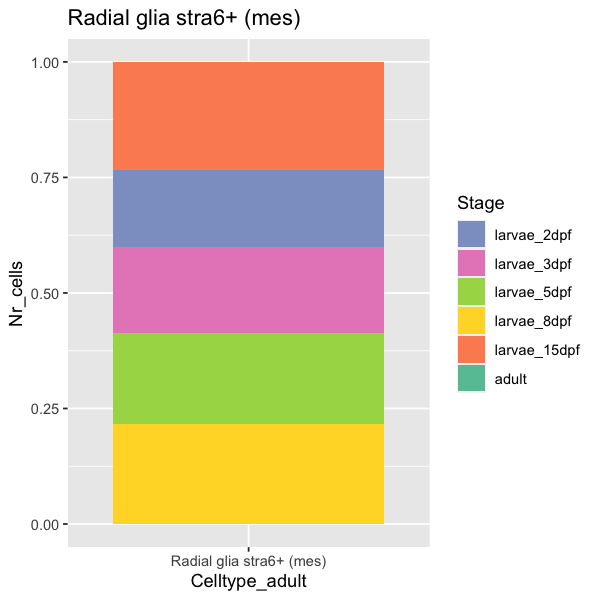

In [233]:
ggplot(data = sub_df, aes(x = Celltype_adult, y = Nr_cells, fill = Stage)) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia stra6+ (mes)")

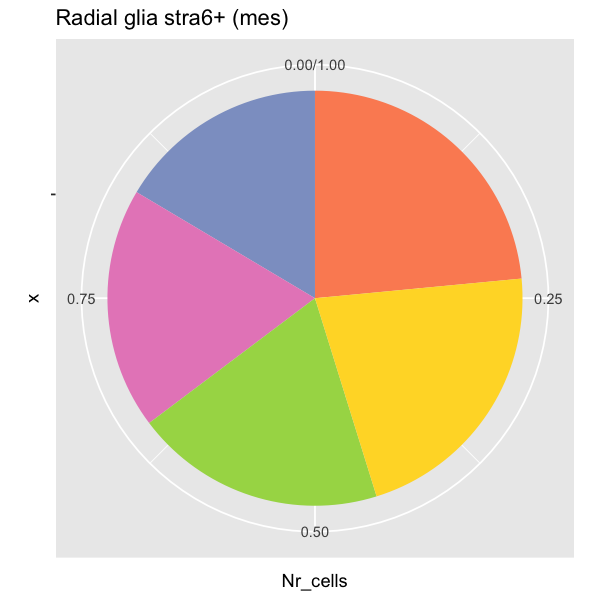

In [234]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("Radial glia stra6+ (mes)") +
    coord_polar("y", start=0) +
    NoLegend()

In [235]:
ggsave(filename = "/local/Nina/jupyterlab/larvae_adult_int/figs_seu_lar/pie_rg_stra6.pdf", 
    plot = ggplot(data = sub_df, aes(x = "", y = Nr_cells, fill = factor(Stage, levels = c("larvae_2dpf", "larvae_3dpf", "larvae_5dpf", "larvae_8dpf", "larvae_15dpf")))) + 
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_manual(values = stage_colors) +
    ggtitle("RG stra6+ (mes)") +
    coord_polar("y", start=0) +
    theme_void() +
    theme(plot.title = element_text(hjust = 0.5)) +
    NoLegend(), 
   units = "in", height = 2.5, width = 2.5)